# Import library and support function

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm 
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import json
import os
from datasets import load_dataset
import torch_geometric.data 
import data
from collections import Counter
import pandas as pd
import numpy as np
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.metrics import (ConfusionMatrixDisplay, roc_auc_score, precision_score, average_precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve, auc, classification_report,auc,confusion_matrix,matthews_corrcoef)
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time

/home/jupyter-iec2023se05/pytorch_gpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("X_matrix_final.json",'r') as f:
    SEMANTIC_EMBEDDING = json.load(f)

# Model hyperparameters
EPOCH_LIST = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500]          
BATCH_LIST = [32, 64, 128, 192, 256, 512] 
EMBEDDED_DIMENSION = 768
HIDDEN_DIM = 12
NUM_HEADS = 12
OUTPUT_DIM = 1
# TRAIN_EPOCHS = 100
LEARNING_RATE = 1e-4
# BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Result
RESULT_PATH = "Result/Final_Train_BERT_BRUTEFORCE_EPOCH_BATCH_Out_Dataset.csv"
CHART_PATH = "Result/Charts"
res_df = pd.DataFrame(columns=[
    "Data Type",
    "STT",
    "Train Epochs",
    "Batch Size",
    "Result Type",
    "Loss",
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "TNR",
    "Confusion Matrix",
    "Training Time",
    "Testing Time"
])
res_df.to_csv(RESULT_PATH, mode='a', header=not os.path.exists(RESULT_PATH), index=False)

# Loss
# EPOCHS_LOSS = []

In [3]:
# FUNCTION - API SEQUENCE TO GRAPH
def API_seq_to_graph(api_sequence, label):
    api_sequence = [api for api in api_sequence if isinstance(api, str) and api]
    if len(api_sequence) < 2:
        return None

    # Graph edges
    transitions = [(api_sequence[i], api_sequence[i+1]) for i in range(len(api_sequence)-1)]
    edge_counters = Counter(transitions)

    unique_apis = list(set(api_sequence))
    apis_call_time = {api: idx for idx, api in enumerate(unique_apis)}
    number_nodes = len(unique_apis)

    src, dst, edge_weights = [], [], []
    for (u, v), count in edge_counters.items():
        src.append(apis_call_time[u])
        dst.append(apis_call_time[v])
        edge_weights.append(count)

    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1,1)

    # Node features
    nodes_features = []
    for api in unique_apis:
        embedding = SEMANTIC_EMBEDDING.get(api)
        if embedding is None:
            nodes_features.append(np.zeros(EMBEDDED_DIMENSION))
        else:
            nodes_features.append(embedding)
    #     if embedding is None:
    #         print(f"{api} -> None (zero vector)")
    #         nodes_features.append(np.zeros(EMBEDDED_DIMENSION))
    #     else:
    #         embedding = np.array(embedding)
    #         print(f"{api} -> shape: {embedding.shape}")
    
    #         if embedding.ndim != 1:
    #             print("❌ ERROR: Embedding is not 1D!")
    #         elif embedding.shape[0] != EMBEDDED_DIMENSION:
    #             print(f"❌ ERROR: Wrong dimension {embedding.shape[0]} expected {EMBEDDED_DIMENSION}")

    #         nodes_features.append(embedding)
        
    # for i, nf in enumerate(nodes_features):
    #     if not isinstance(nf, np.ndarray):
    #         print("❌ Not ndarray at index", i, type(nf))
    #     else:
    #         if nf.shape != (EMBEDDED_DIMENSION,):
    #             print(f"❌ Wrong shape at index {i} shape={nf.shape}")
    nodes_features = np.array(nodes_features)
    
    X = torch.tensor(nodes_features, dtype=torch.float32)
    y = torch.tensor(label, dtype=torch.float32)

    return Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=y, num_nodes=number_nodes)


In [4]:
class DawnGNN_GAT(nn.Module):
    def __init__(self):
        super(DawnGNN_GAT, self).__init__()
        self.conv1 = GATConv(EMBEDDED_DIMENSION, HIDDEN_DIM, heads=NUM_HEADS, dropout=0.6)
        self.conv2 = GATConv(HIDDEN_DIM * NUM_HEADS, HIDDEN_DIM, heads=1, concat=False, dropout=0.6)

        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM//2, OUTPUT_DIM)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = global_add_pool(x, batch)
        x = self.classifier(x)
        return torch.sigmoid(x).squeeze(1)

In [5]:
# EVALUATION FUNCTION
def evaluate_model(DATASET, epoch, model, loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, device, criterion, val_test, training_time, cumulative_testing_time=0):
    model.eval()
    start_test = time.time()
    total_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out.float(), data.y.float())
            total_loss += loss.item() * data.num_graphs
            y_pred.extend((out>0.5).long().cpu().tolist())
            y_true.extend(data.y.long().cpu().tolist())

    end_test = time.time()
    testing_time = end_test - start_test
    cumulative_testing_time += testing_time
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    TNR = tn / (tn + fp)
    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)
    NPV = tn / (tn + fn)

    if (val_test == 'Test'):
        LABELS = ['Benign', 'Malware']
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
        plt.title('Confusion Matrix', fontsize=17, pad=20)
        plt.ylabel('Actual', fontsize=13)
        plt.xlabel('Prediction', fontsize=13)
        plt.gca().xaxis.set_label_position('top') 
        plt.gca().xaxis.tick_top()
        plt.show()

    res_df.loc[len(res_df)] = [
        DATASET,
        epoch,
        TRAIN_EPOCHS,
        BATCH_SIZE,
        val_test,
        total_loss/len(loader.dataset),
        acc,
        precision,
        recall,
        f1,
        TNR,
        str(cm.tolist()),
        training_time,
        cumulative_testing_time
    ]
    if ((epoch == TRAIN_EPOCHS) and (val_test == 'Test')):
        res_df.to_csv(RESULT_PATH, mode='a', header=False, index=False)

    avg_epoch_loss = total_loss/len(loader.dataset)
    EPOCHS_LOSS.append(avg_epoch_loss)

    return total_loss/len(loader.dataset), acc, f1, precision, recall, TNR, cumulative_testing_time


In [6]:
def main_train_test_gat():
    print("==================== CONVERT API SEQUENCE TO GRAPH ====================")
    # LOAD DATASET
    # dataset = ["APIMDS", "MalBehavD-V1-dataset", "WINDOWS_PE_APICALLS"]
    dataset = ["MalAnalysis_API_Call_Sequences"]
    # Load Dataset
    for ds in dataset: 
        DATASET_PATH = f"../Dataset/{ds}.csv"
        DATASET = ds    
        # DATASET_PATH = "Dataset/WINDOWS_PE_APICALLS_CSV9.csv"
        # DATASET = "WINDOWS_PE_APICALLS_CSV9"
        df = pd.read_csv(DATASET_PATH, low_memory=False)
        # print(df.head(5))
        if ds == 'MalBehavD-V1-dataset':
            start_api = 2
            label_col_name = 'labels'
        elif ds == 'APIMDS':
            start_api = 2
            label_col_name = 'labels'
        elif ds == 'WINDOWS_PE_APICALLS':
            start_api = 1
            df['labels'] = df['Malware'].apply(lambda x: 0 if x.lower() in ['benign', 'normal'] else 1)
            label_col_name = 'labels'
        elif ds == 'MalAnalysis_API_Call_Sequences':
            start_api = 3
            label_col_name = 'malware'
            
        # LABELS = df[label_col_name]
        # print(f"Label: {LABELS}")
        # print(df.head(5))
        data_list = []
        LABELS = []
        for index, row in tqdm(df.iterrows(), total=len(df)):
            api_sequence = row.iloc[start_api:].dropna().tolist()
            label = float(row[label_col_name])
            
            graph = API_seq_to_graph(api_sequence, label)
            if graph is not None:
                data_list.append(graph)
                LABELS.append(label)
    
        # Split dataset
        train_data, temp_data, train_labels, temp_labels = train_test_split(data_list, LABELS, test_size=0.2, random_state=42, stratify=LABELS)
        val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)
    
        # Model & optimizer
        model = DawnGNN_GAT().to(DEVICE)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
        # Training
        for epoch in EPOCH_LIST:
            for batch in BATCH_LIST:    
                TRAIN_EPOCHS = epoch
                BATCH_SIZE = batch
                EPOCHS_LOSS = []
    
                train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
                val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
                test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

               #  print(f"\n==========")
               # # xem số lượng batch
               #  print("Train batches:", len(train_loader))
               #  print("Val batches:", len(val_loader))
               #  print("Test batches:", len(test_loader))
                
               #  # lấy 1 batch để xem shape
               #  batch = next(iter(train_loader))
                
               #  print("\nĐặc trưng node:", batch.x.shape)
               #  print("edge_index:", batch.edge_index.shape)
               #  print("Label:", batch.y.shape)
               #  print(f"\n==========")
               #  ẻkef
                
                print(f"\n===== RUNNING WITH EPOCH={epoch}  |  BATCH={batch} =====")
                cumulative_testing_time = 0
                for epoch in range(1, TRAIN_EPOCHS+1):
                    model.train()
                    start_train = time.time()
                    total_loss = 0
                    for data in train_loader:
                        optimizer.zero_grad()
                        data = data.to(DEVICE)
                        out = model(data)
                        loss = criterion(out.float(), data.y.float())
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item() * data.num_graphs
            
                    end_train = time.time()
                    training_time = end_train - start_train
                    
                    val_loss, val_acc, val_f1, val_pre, val_recall, val_TNR, cumulative_testing_time = evaluate_model(DATASET, epoch, model, val_loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, DEVICE, criterion, val_test="Validation", training_time=training_time,
                        cumulative_testing_time=cumulative_testing_time)
                    print(f"Epoch {epoch} | Train Loss: {total_loss/len(train_data):.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val Precision: {val_pre:.4f} | Val Recall: {val_recall:.4f} | Val TNR: {val_TNR:.4f}")
    
                # # if __name__ == "__main__":
                # print("==================== TRAINING ====================")
                # model, test_loader, criterion = main_train_gat()
    
                plt.figure(figsize=(8,5))
                plt.plot(range(1, len(EPOCHS_LOSS)+1), EPOCHS_LOSS, marker='o', linestyle='-')
                plt.title("Training Loss per Epoch", fontsize=15)
                plt.xlabel("Epoch", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(True)
                
                chart_path = f"{CHART_PATH}/{DATASET}_Loss_E{epoch}_B{batch}.png"
                plt.savefig(chart_path, dpi=300)    
                plt.show()
    
                print("==================== TESTING ====================")
                test_loss, test_acc, test_f1, test_precision, test_recall, test_TNR, cumulative_testing_time = evaluate_model(DATASET, epoch, model, test_loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, DEVICE, criterion, val_test="Test", training_time=0, cumulative_testing_time=0)
                print("\n=======================================================")
                print(f"✅ FINAL TEST PERFORMANCE (GAT Classifier):")
                print(f"Accuracy: {test_acc:.4f} | F1-Score: {test_f1:.4f} | Loss: {test_loss:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f} | TNR: {test_TNR:.4f}")
                print("=======================================================")

            
    return model, test_loader, criterion

==================== TRAINING ====================
==================== CONVERT API SEQUENCE TO GRAPH ====================


100%|██████████| 43876/43876 [00:28<00:00, 1541.83it/s]



===== RUNNING WITH EPOCH=25  |  BATCH=32 =====


/tmp/ipykernel_440579/3931422262.py:29: RuntimeWarning: invalid value encountered in scalar divide
  NPV = tn / (tn + fn)


Epoch 1 | Train Loss: 0.1154 | Val Acc: 0.9754 | Val F1: 0.9875 | Val Precision: 0.9754 | Val Recall: 1.0000 | Val TNR: 0.0000
Epoch 2 | Train Loss: 0.0986 | Val Acc: 0.9749 | Val F1: 0.9873 | Val Precision: 0.9754 | Val Recall: 0.9995 | Val TNR: 0.0000
Epoch 3 | Train Loss: 0.0917 | Val Acc: 0.9747 | Val F1: 0.9871 | Val Precision: 0.9802 | Val Recall: 0.9942 | Val TNR: 0.2037
Epoch 4 | Train Loss: 0.0878 | Val Acc: 0.9763 | Val F1: 0.9880 | Val Precision: 0.9791 | Val Recall: 0.9970 | Val TNR: 0.1574
Epoch 5 | Train Loss: 0.0863 | Val Acc: 0.9624 | Val F1: 0.9807 | Val Precision: 0.9831 | Val Recall: 0.9783 | Val TNR: 0.3333
Epoch 6 | Train Loss: 0.0833 | Val Acc: 0.9574 | Val F1: 0.9780 | Val Precision: 0.9848 | Val Recall: 0.9713 | Val TNR: 0.4074
Epoch 7 | Train Loss: 0.0831 | Val Acc: 0.9585 | Val F1: 0.9786 | Val Precision: 0.9853 | Val Recall: 0.9720 | Val TNR: 0.4259
Epoch 8 | Train Loss: 0.0805 | Val Acc: 0.9658 | Val F1: 0.9825 | Val Precision: 0.9836 | Val Recall: 0.9813 | 

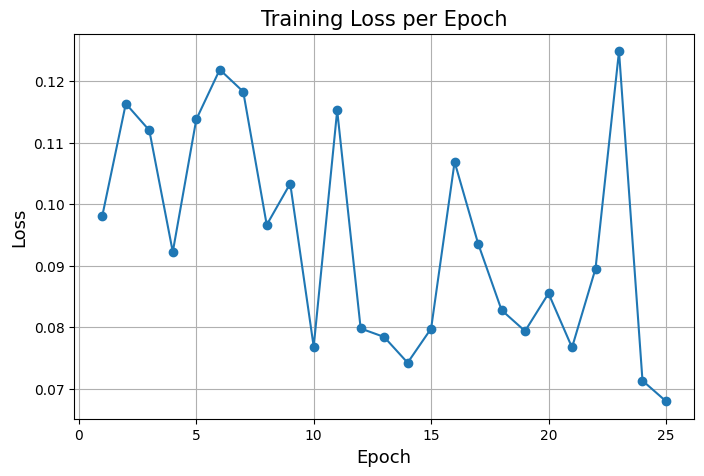

==================== TESTING ====================


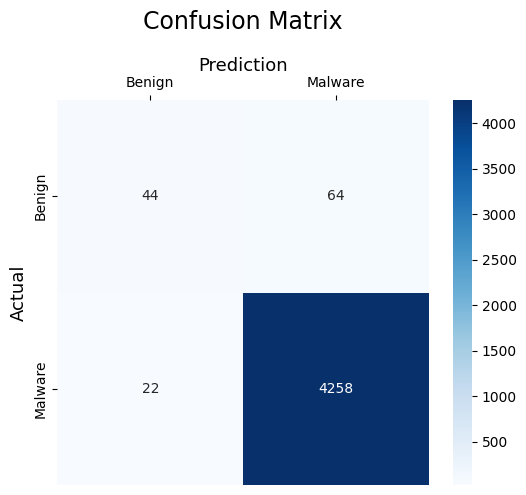


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9804 | F1-Score: 0.9900 | Loss: 0.0618 | Recall: 0.9949 | Precision: 0.9852 | TNR: 0.4074

===== RUNNING WITH EPOCH=25  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0694 | Val Acc: 0.9758 | Val F1: 0.9877 | Val Precision: 0.9835 | Val Recall: 0.9918 | Val TNR: 0.3426
Epoch 2 | Train Loss: 0.0673 | Val Acc: 0.9777 | Val F1: 0.9886 | Val Precision: 0.9849 | Val Recall: 0.9923 | Val TNR: 0.3981
Epoch 3 | Train Loss: 0.0669 | Val Acc: 0.9802 | Val F1: 0.9899 | Val Precision: 0.9841 | Val Recall: 0.9958 | Val TNR: 0.3611
Epoch 4 | Train Loss: 0.0665 | Val Acc: 0.9756 | Val F1: 0.9875 | Val Precision: 0.9869 | Val Recall: 0.9881 | Val TNR: 0.4815
Epoch 5 | Train Loss: 0.0670 | Val Acc: 0.9804 | Val F1: 0.9900 | Val Precision: 0.9834 | Val Recall: 0.9967 | Val TNR: 0.3333
Epoch 6 | Train Loss: 0.0666 | Val Acc: 0.9799 | Val F1: 0.9898 | Val Precision: 0.9838 | Val Recall: 0.9958 | Val TNR: 0.3519
Epoch 7 | Train Loss: 0.0664 | Val Acc: 0.96

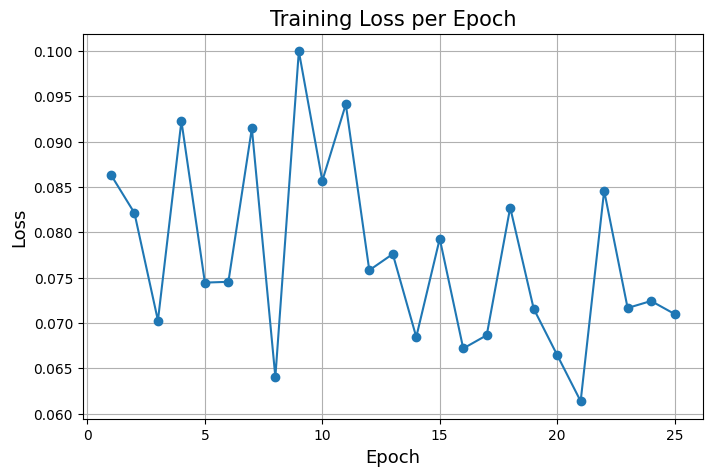

==================== TESTING ====================


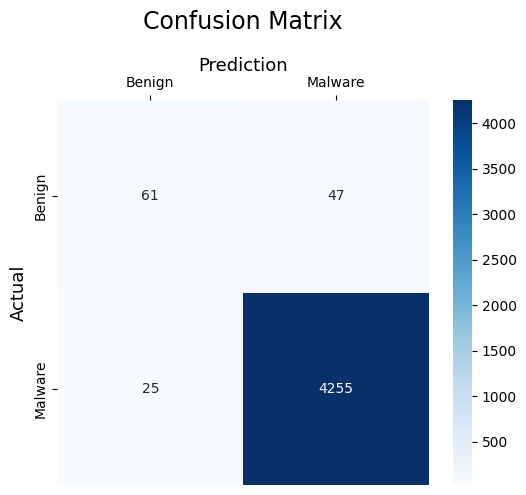


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9836 | F1-Score: 0.9916 | Loss: 0.0645 | Recall: 0.9942 | Precision: 0.9891 | TNR: 0.5648

===== RUNNING WITH EPOCH=25  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0601 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9865 | Val Recall: 0.9939 | Val TNR: 0.4630
Epoch 2 | Train Loss: 0.0609 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9843 | Val Recall: 0.9963 | Val TNR: 0.3704
Epoch 3 | Train Loss: 0.0609 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9866 | Val Recall: 0.9949 | Val TNR: 0.4630
Epoch 4 | Train Loss: 0.0604 | Val Acc: 0.9672 | Val F1: 0.9831 | Val Precision: 0.9882 | Val Recall: 0.9780 | Val TNR: 0.5370
Epoch 5 | Train Loss: 0.0598 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9857 | Val Recall: 0.9951 | Val TNR: 0.4259
Epoch 6 | Train Loss: 0.0605 | Val Acc: 0.9793 | Val F1: 0.9894 | Val Precision: 0.9883 | Val Recall: 0.9904 | Val TNR: 0.5370
Epoch 7 | Train Loss: 0.0603 | Val Acc: 0.9

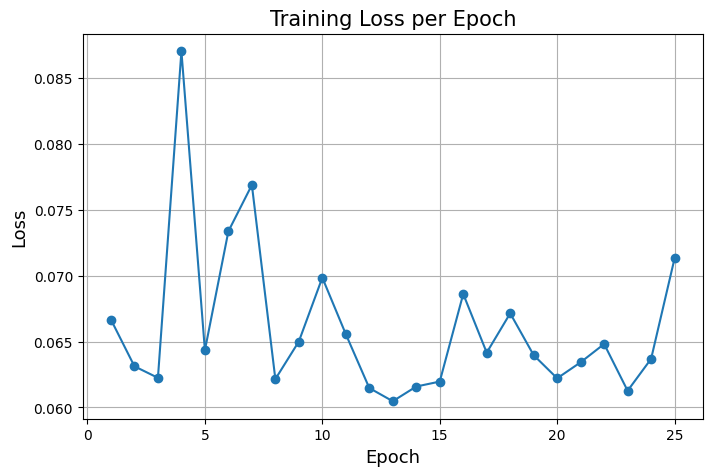

==================== TESTING ====================


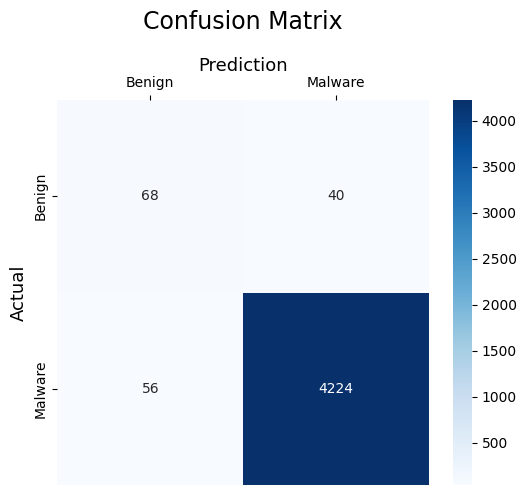


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9781 | F1-Score: 0.9888 | Loss: 0.0651 | Recall: 0.9869 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=25  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0589 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9868 | Val Recall: 0.9925 | Val TNR: 0.4722
Epoch 2 | Train Loss: 0.0578 | Val Acc: 0.9802 | Val F1: 0.9899 | Val Precision: 0.9879 | Val Recall: 0.9918 | Val TNR: 0.5185
Epoch 3 | Train Loss: 0.0575 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9861 | Val Recall: 0.9942 | Val TNR: 0.4444
Epoch 4 | Train Loss: 0.0590 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9884 | Val Recall: 0.9921 | Val TNR: 0.5370
Epoch 5 | Train Loss: 0.0571 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9886 | Val Recall: 0.9897 | Val TNR: 0.5463
Epoch 6 | Train Loss: 0.0569 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9877 | Val Recall: 0.9932 | Val TNR: 0.5093
Epoch 7 | Train Loss: 0.0556 | Val Acc: 0.9

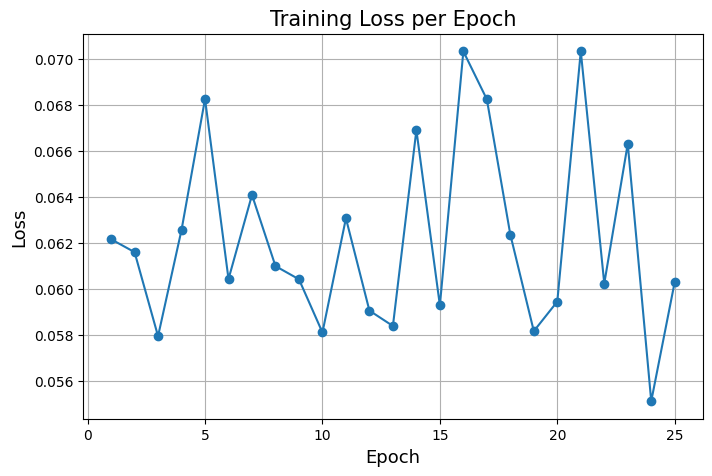

==================== TESTING ====================


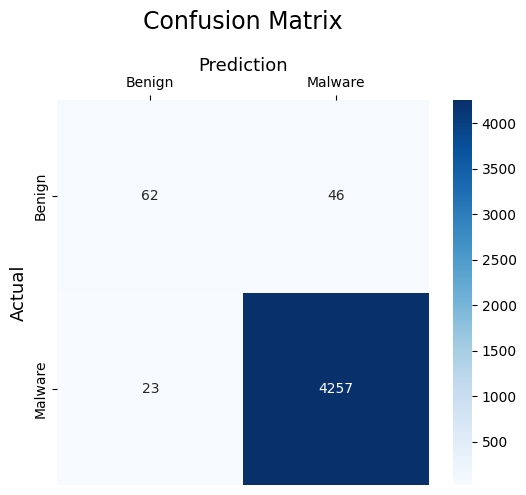


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9843 | F1-Score: 0.9920 | Loss: 0.0555 | Recall: 0.9946 | Precision: 0.9893 | TNR: 0.5741

===== RUNNING WITH EPOCH=25  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0540 | Val Acc: 0.9813 | Val F1: 0.9905 | Val Precision: 0.9872 | Val Recall: 0.9937 | Val TNR: 0.4907
Epoch 2 | Train Loss: 0.0550 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9870 | Val Recall: 0.9944 | Val TNR: 0.4815
Epoch 3 | Train Loss: 0.0554 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9879 | Val Recall: 0.9916 | Val TNR: 0.5185
Epoch 4 | Train Loss: 0.0544 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9872 | Val Recall: 0.9949 | Val TNR: 0.4907
Epoch 5 | Train Loss: 0.0554 | Val Acc: 0.9815 | Val F1: 0.9906 | Val Precision: 0.9877 | Val Recall: 0.9935 | Val TNR: 0.5093
Epoch 6 | Train Loss: 0.0560 | Val Acc: 0.9793 | Val F1: 0.9894 | Val Precision: 0.9888 | Val Recall: 0.9900 | Val TNR: 0.5556
Epoch 7 | Train Loss: 0.0544 | Val Acc: 0.9

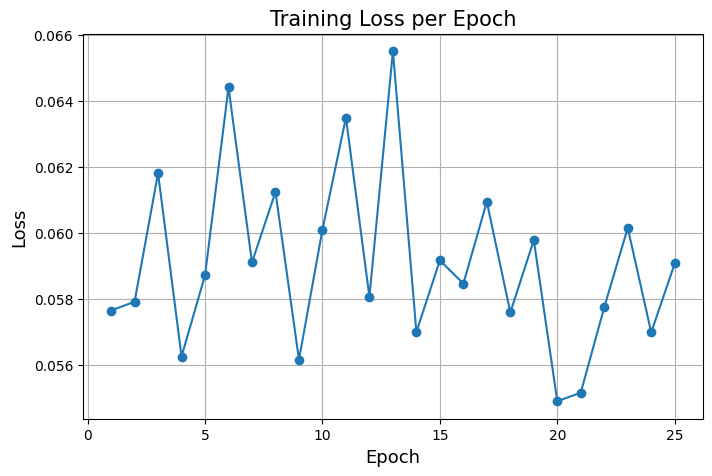

==================== TESTING ====================


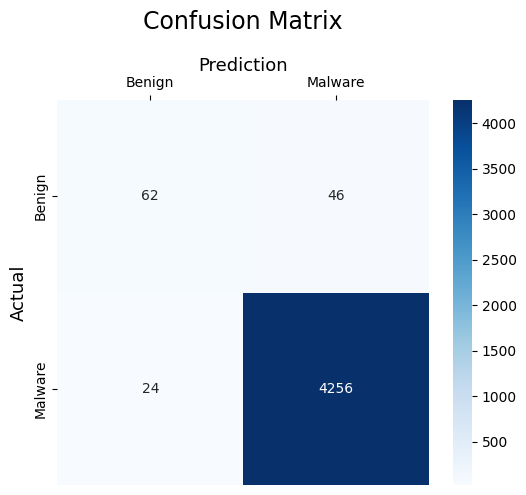


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9840 | F1-Score: 0.9918 | Loss: 0.0543 | Recall: 0.9944 | Precision: 0.9893 | TNR: 0.5741

===== RUNNING WITH EPOCH=25  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0533 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9886 | Val Recall: 0.9911 | Val TNR: 0.5463
Epoch 2 | Train Loss: 0.0536 | Val Acc: 0.9815 | Val F1: 0.9906 | Val Precision: 0.9879 | Val Recall: 0.9932 | Val TNR: 0.5185
Epoch 3 | Train Loss: 0.0529 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9886 | Val Recall: 0.9909 | Val TNR: 0.5463
Epoch 4 | Train Loss: 0.0544 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9893 | Val Recall: 0.9916 | Val TNR: 0.5741
Epoch 5 | Train Loss: 0.0537 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9866 | Val Recall: 0.9949 | Val TNR: 0.4630
Epoch 6 | Train Loss: 0.0534 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9879 | Val Recall: 0.9925 | Val TNR: 0.5185
Epoch 7 | Train Loss: 0.0526 | Val Acc: 0.9

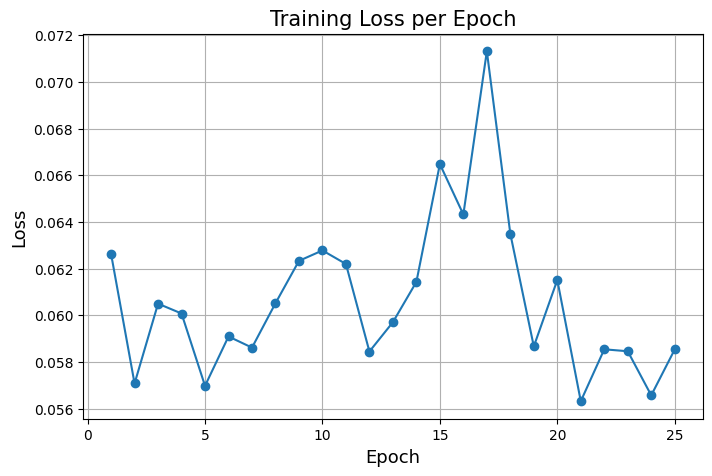

==================== TESTING ====================


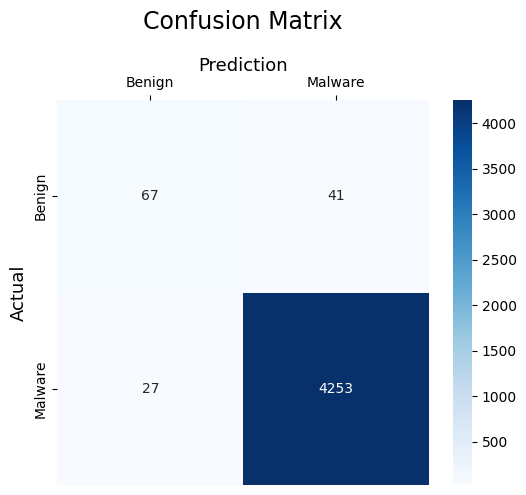


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9845 | F1-Score: 0.9921 | Loss: 0.0530 | Recall: 0.9937 | Precision: 0.9905 | TNR: 0.6204

===== RUNNING WITH EPOCH=50  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0603 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9859 | Val Recall: 0.9974 | Val TNR: 0.4352
Epoch 2 | Train Loss: 0.0572 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9861 | Val Recall: 0.9960 | Val TNR: 0.4444
Epoch 3 | Train Loss: 0.0573 | Val Acc: 0.9742 | Val F1: 0.9867 | Val Precision: 0.9906 | Val Recall: 0.9829 | Val TNR: 0.6296
Epoch 4 | Train Loss: 0.0561 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9888 | Val Recall: 0.9939 | Val TNR: 0.5556
Epoch 5 | Train Loss: 0.0550 | Val Acc: 0.9840 | Val F1: 0.9919 | Val Precision: 0.9873 | Val Recall: 0.9965 | Val TNR: 0.4907
Epoch 6 | Train Loss: 0.0570 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9884 | Val Recall: 0.9939 | Val TNR: 0.5370
Epoch 7 | Train Loss: 0.0549 | Val Acc: 0.97

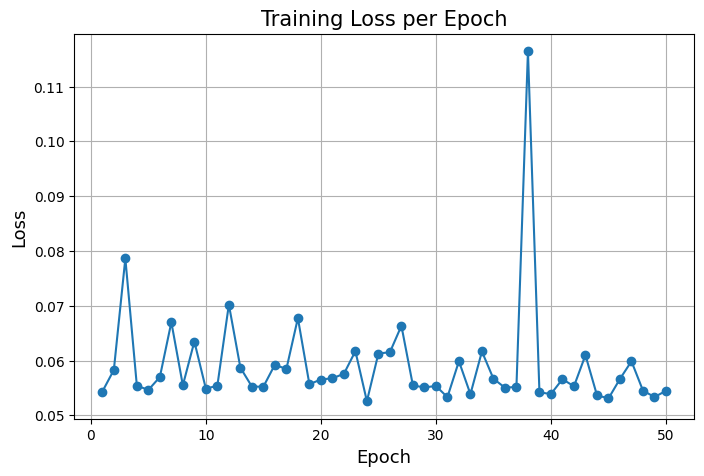

==================== TESTING ====================


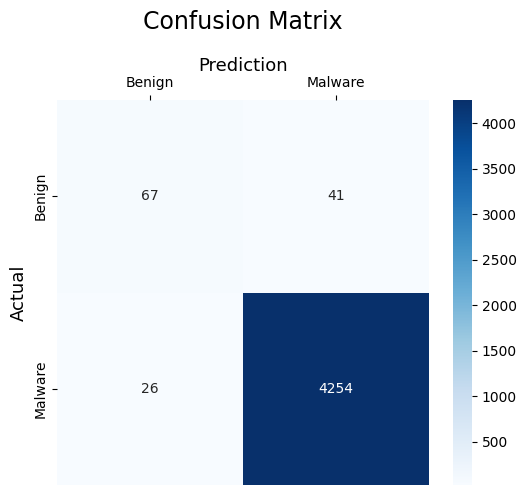


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9847 | F1-Score: 0.9922 | Loss: 0.0501 | Recall: 0.9939 | Precision: 0.9905 | TNR: 0.6204

===== RUNNING WITH EPOCH=50  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0506 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9902 | Val Recall: 0.9918 | Val TNR: 0.6111
Epoch 2 | Train Loss: 0.0500 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9911 | Val Recall: 0.9862 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0510 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9891 | Val Recall: 0.9942 | Val TNR: 0.5648
Epoch 4 | Train Loss: 0.0517 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9906 | Val Recall: 0.9888 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0494 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9904 | Val Recall: 0.9916 | Val TNR: 0.6204
Epoch 6 | Train Loss: 0.0509 | Val Acc: 0.9829 | Val F1: 0.9913 | Val Precision: 0.9879 | Val Recall: 0.9946 | Val TNR: 0.5185
Epoch 7 | Train Loss: 0.0493 | Val Acc: 0.98

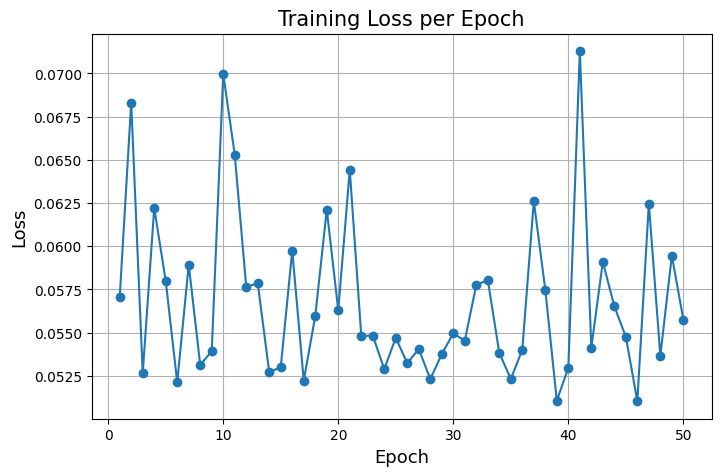

==================== TESTING ====================


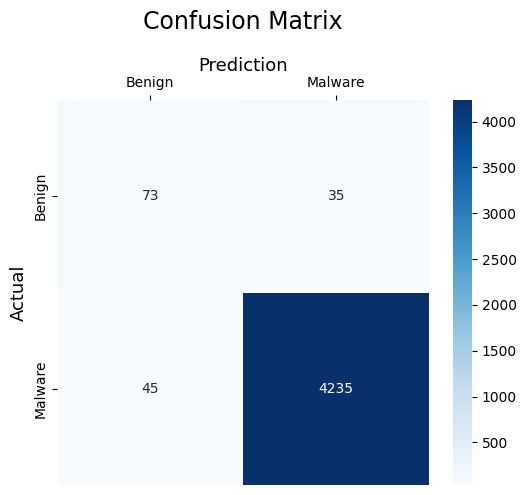


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9818 | F1-Score: 0.9906 | Loss: 0.0537 | Recall: 0.9895 | Precision: 0.9918 | TNR: 0.6759

===== RUNNING WITH EPOCH=50  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0469 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9902 | Val Recall: 0.9925 | Val TNR: 0.6111
Epoch 2 | Train Loss: 0.0461 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9898 | Val Recall: 0.9935 | Val TNR: 0.5926
Epoch 3 | Train Loss: 0.0468 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9907 | Val Recall: 0.9907 | Val TNR: 0.6296
Epoch 4 | Train Loss: 0.0463 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9908 | Val Recall: 0.9834 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0467 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9909 | Val Recall: 0.9869 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0466 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9906 | Val Recall: 0.9897 | Val TNR: 0.6296
Epoch 7 | Train Loss: 0.0472 | Val Acc: 0.9

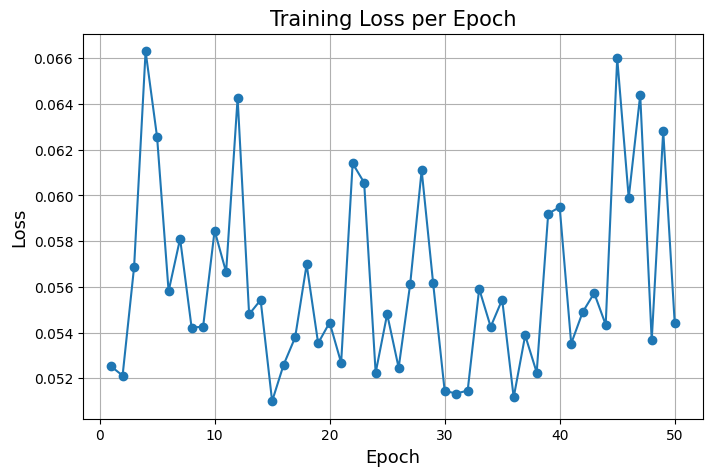

==================== TESTING ====================


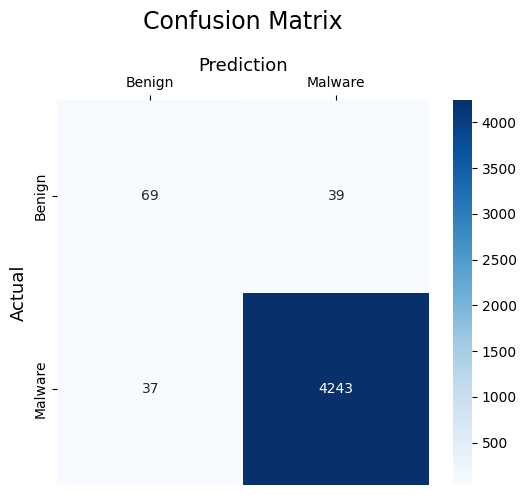


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9827 | F1-Score: 0.9911 | Loss: 0.0525 | Recall: 0.9914 | Precision: 0.9909 | TNR: 0.6389

===== RUNNING WITH EPOCH=50  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0454 | Val Acc: 0.9829 | Val F1: 0.9912 | Val Precision: 0.9909 | Val Recall: 0.9916 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0451 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9909 | Val Recall: 0.9909 | Val TNR: 0.6389
Epoch 3 | Train Loss: 0.0455 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9909 | Val Recall: 0.9886 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0465 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9911 | Val Recall: 0.9879 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0460 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9909 | Val Recall: 0.9909 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0444 | Val Acc: 0.9850 | Val F1: 0.9923 | Val Precision: 0.9907 | Val Recall: 0.9939 | Val TNR: 0.6296
Epoch 7 | Train Loss: 0.0469 | Val Acc: 0.9

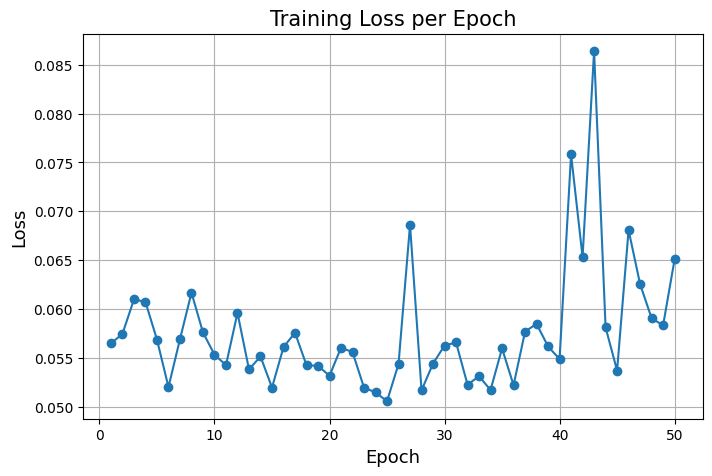

==================== TESTING ====================


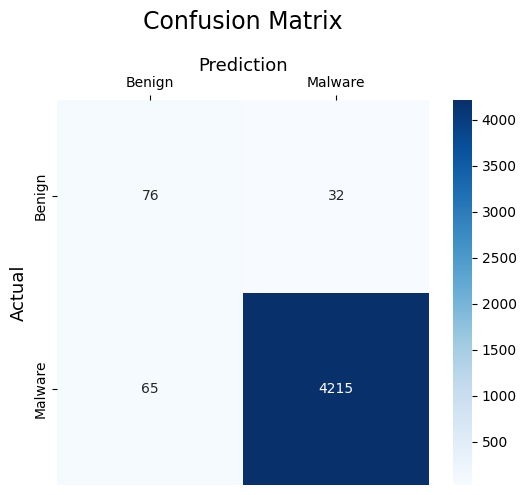


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9779 | F1-Score: 0.9886 | Loss: 0.0626 | Recall: 0.9848 | Precision: 0.9925 | TNR: 0.7037

===== RUNNING WITH EPOCH=50  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0451 | Val Acc: 0.9838 | Val F1: 0.9917 | Val Precision: 0.9909 | Val Recall: 0.9925 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0446 | Val Acc: 0.9829 | Val F1: 0.9912 | Val Precision: 0.9900 | Val Recall: 0.9925 | Val TNR: 0.6019
Epoch 3 | Train Loss: 0.0447 | Val Acc: 0.9770 | Val F1: 0.9882 | Val Precision: 0.9913 | Val Recall: 0.9850 | Val TNR: 0.6574
Epoch 4 | Train Loss: 0.0447 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9909 | Val Recall: 0.9911 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0450 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9911 | Val Recall: 0.9886 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0460 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9909 | Val Recall: 0.9909 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0444 | Val Acc: 0.9

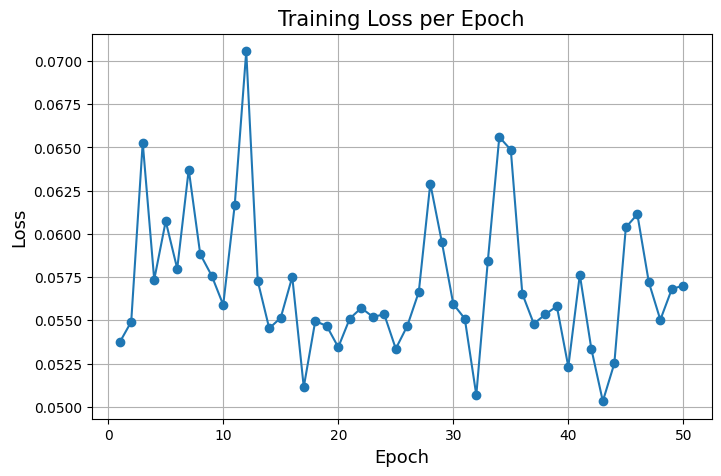

==================== TESTING ====================


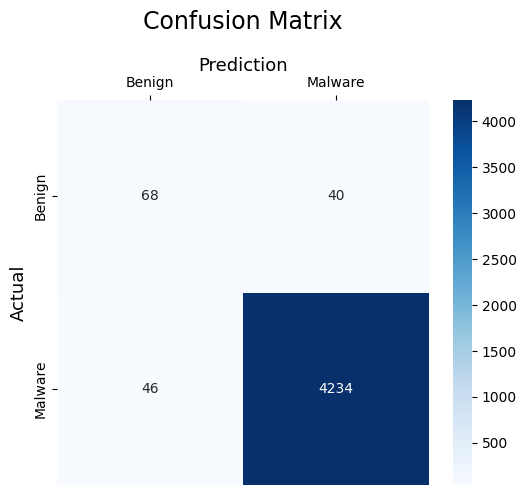


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9804 | F1-Score: 0.9899 | Loss: 0.0550 | Recall: 0.9893 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=50  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0459 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9909 | Val Recall: 0.9914 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0443 | Val Acc: 0.9829 | Val F1: 0.9912 | Val Precision: 0.9909 | Val Recall: 0.9916 | Val TNR: 0.6389
Epoch 3 | Train Loss: 0.0452 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9911 | Val Recall: 0.9897 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0441 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9909 | Val Recall: 0.9904 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0448 | Val Acc: 0.9804 | Val F1: 0.9899 | Val Precision: 0.9909 | Val Recall: 0.9890 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0439 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9909 | Val Recall: 0.9923 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0442 | Val Acc: 0.9

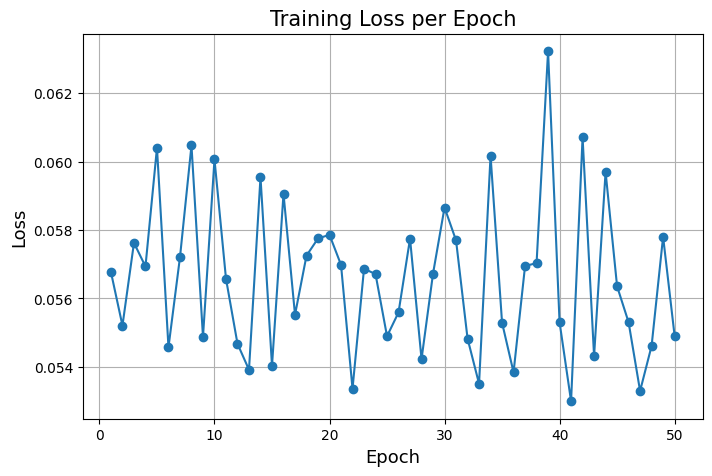

==================== TESTING ====================


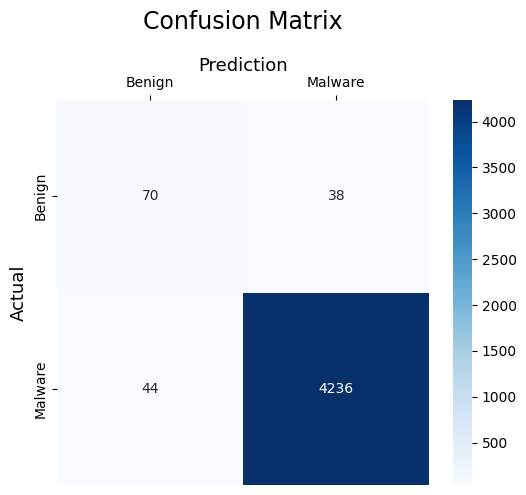


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9813 | F1-Score: 0.9904 | Loss: 0.0530 | Recall: 0.9897 | Precision: 0.9911 | TNR: 0.6481

===== RUNNING WITH EPOCH=75  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0490 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9908 | Val Recall: 0.9834 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0473 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9904 | Val Recall: 0.9914 | Val TNR: 0.6204
Epoch 3 | Train Loss: 0.0479 | Val Acc: 0.9752 | Val F1: 0.9872 | Val Precision: 0.9911 | Val Recall: 0.9834 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0465 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9909 | Val Recall: 0.9907 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0487 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9907 | Val Recall: 0.9911 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0452 | Val Acc: 0.9834 | Val F1: 0.9915 | Val Precision: 0.9900 | Val Recall: 0.9930 | Val TNR: 0.6019
Epoch 7 | Train Loss: 0.0448 | Val Acc: 0.98

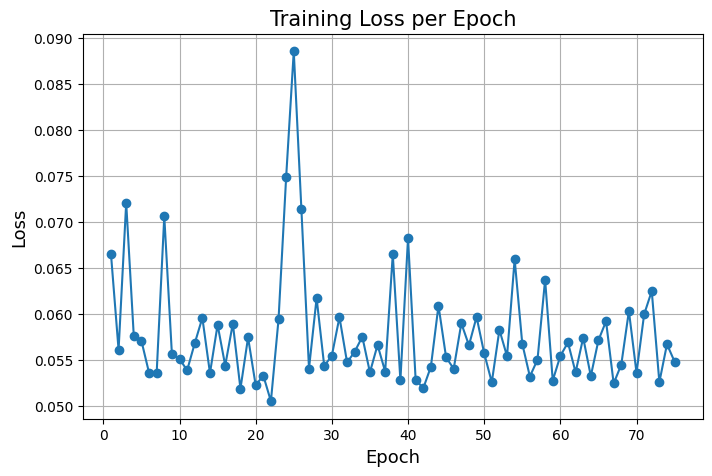

==================== TESTING ====================


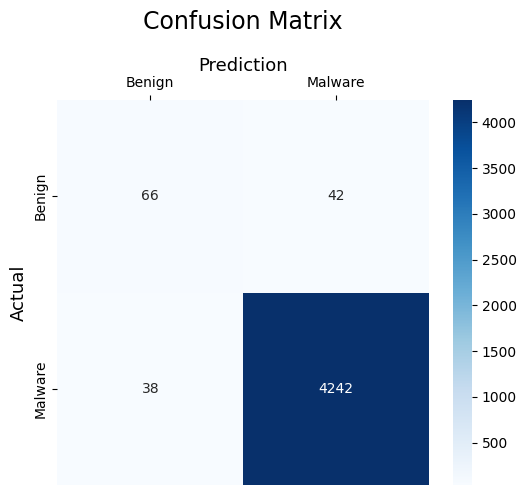


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9818 | F1-Score: 0.9907 | Loss: 0.0509 | Recall: 0.9911 | Precision: 0.9902 | TNR: 0.6111

===== RUNNING WITH EPOCH=75  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0430 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9907 | Val Recall: 0.9909 | Val TNR: 0.6296
Epoch 2 | Train Loss: 0.0434 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9907 | Val Recall: 0.9911 | Val TNR: 0.6296
Epoch 3 | Train Loss: 0.0446 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9904 | Val Recall: 0.9916 | Val TNR: 0.6204
Epoch 4 | Train Loss: 0.0434 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9907 | Val Recall: 0.9921 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0436 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9911 | Val Recall: 0.9893 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0442 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9909 | Val Recall: 0.9909 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0444 | Val Acc: 0.98

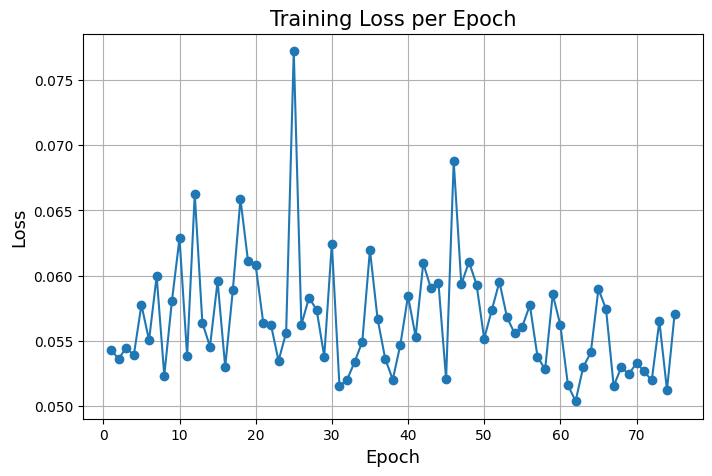

==================== TESTING ====================


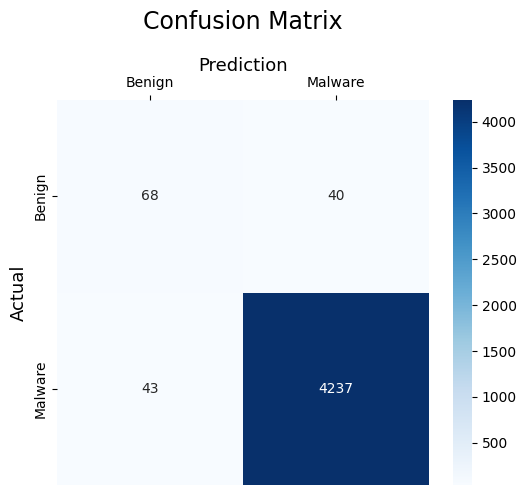


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9811 | F1-Score: 0.9903 | Loss: 0.0566 | Recall: 0.9900 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=75  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0430 | Val Acc: 0.9843 | Val F1: 0.9920 | Val Precision: 0.9902 | Val Recall: 0.9937 | Val TNR: 0.6111
Epoch 2 | Train Loss: 0.0427 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9900 | Val Recall: 0.9918 | Val TNR: 0.6019
Epoch 3 | Train Loss: 0.0431 | Val Acc: 0.9843 | Val F1: 0.9920 | Val Precision: 0.9895 | Val Recall: 0.9944 | Val TNR: 0.5833
Epoch 4 | Train Loss: 0.0455 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9909 | Val Recall: 0.9893 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0426 | Val Acc: 0.9829 | Val F1: 0.9913 | Val Precision: 0.9898 | Val Recall: 0.9928 | Val TNR: 0.5926
Epoch 6 | Train Loss: 0.0418 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9911 | Val Recall: 0.9893 | Val TNR: 0.6481
Epoch 7 | Train Loss: 0.0426 | Val Acc: 0.9

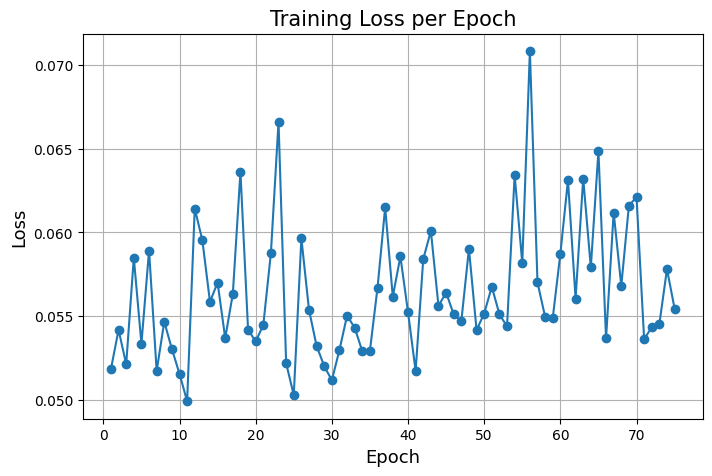

==================== TESTING ====================


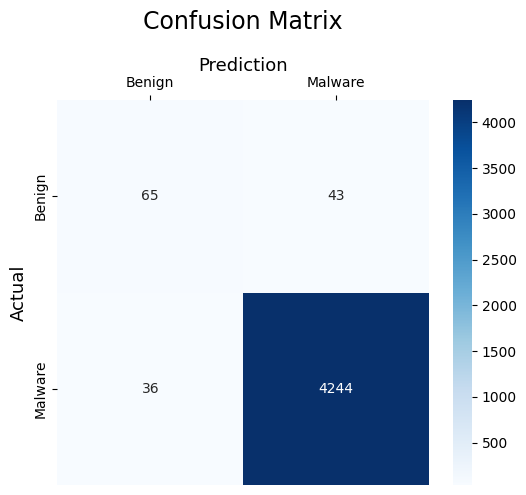


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9820 | F1-Score: 0.9908 | Loss: 0.0540 | Recall: 0.9916 | Precision: 0.9900 | TNR: 0.6019

===== RUNNING WITH EPOCH=75  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0423 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9902 | Val Recall: 0.9930 | Val TNR: 0.6111
Epoch 2 | Train Loss: 0.0402 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9902 | Val Recall: 0.9916 | Val TNR: 0.6111
Epoch 3 | Train Loss: 0.0396 | Val Acc: 0.9843 | Val F1: 0.9920 | Val Precision: 0.9895 | Val Recall: 0.9944 | Val TNR: 0.5833
Epoch 4 | Train Loss: 0.0410 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9913 | Val Recall: 0.9890 | Val TNR: 0.6574
Epoch 5 | Train Loss: 0.0410 | Val Acc: 0.9804 | Val F1: 0.9899 | Val Precision: 0.9909 | Val Recall: 0.9890 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0412 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9893 | Val Recall: 0.9923 | Val TNR: 0.5741
Epoch 7 | Train Loss: 0.0414 | Val Acc: 0.9

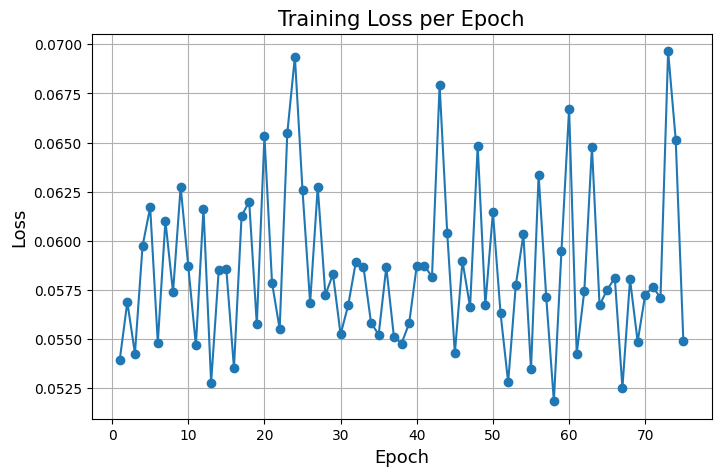

==================== TESTING ====================


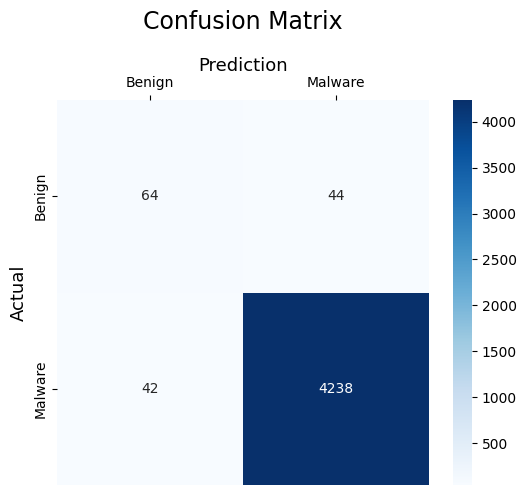


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9804 | F1-Score: 0.9900 | Loss: 0.0535 | Recall: 0.9902 | Precision: 0.9897 | TNR: 0.5926

===== RUNNING WITH EPOCH=75  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0401 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9913 | Val Recall: 0.9869 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0395 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9913 | Val Recall: 0.9869 | Val TNR: 0.6574
Epoch 3 | Train Loss: 0.0405 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9897 | Val Recall: 0.9907 | Val TNR: 0.5926
Epoch 4 | Train Loss: 0.0418 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9897 | Val Recall: 0.9897 | Val TNR: 0.5926
Epoch 5 | Train Loss: 0.0406 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9899 | Val Recall: 0.9895 | Val TNR: 0.6019
Epoch 6 | Train Loss: 0.0402 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9900 | Val Recall: 0.9909 | Val TNR: 0.6019
Epoch 7 | Train Loss: 0.0411 | Val Acc: 0.9

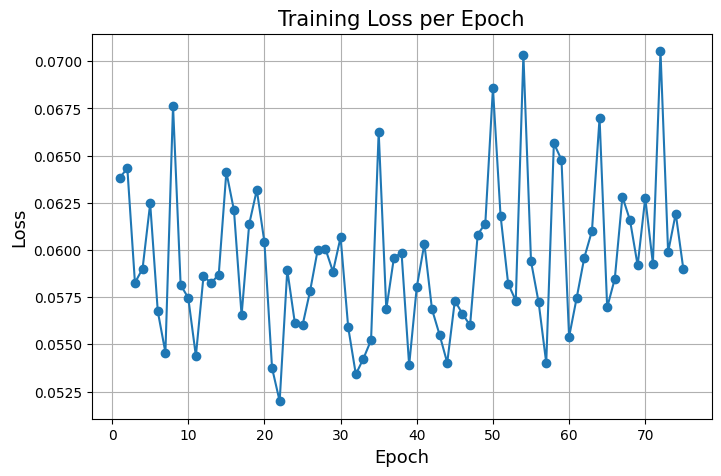

==================== TESTING ====================


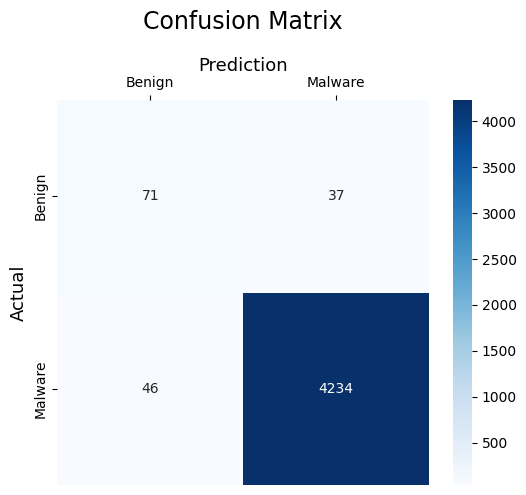


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9811 | F1-Score: 0.9903 | Loss: 0.0561 | Recall: 0.9893 | Precision: 0.9913 | TNR: 0.6574

===== RUNNING WITH EPOCH=75  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0396 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9909 | Val Recall: 0.9900 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0408 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9904 | Val Recall: 0.9879 | Val TNR: 0.6204
Epoch 3 | Train Loss: 0.0389 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9902 | Val Recall: 0.9925 | Val TNR: 0.6111
Epoch 4 | Train Loss: 0.0396 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9909 | Val Recall: 0.9900 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0388 | Val Acc: 0.9804 | Val F1: 0.9899 | Val Precision: 0.9909 | Val Recall: 0.9890 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0401 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9902 | Val Recall: 0.9930 | Val TNR: 0.6111
Epoch 7 | Train Loss: 0.0387 | Val Acc: 0.9

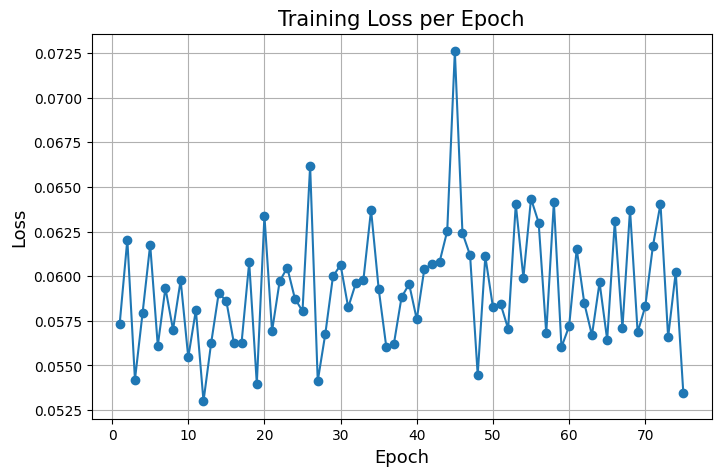

==================== TESTING ====================


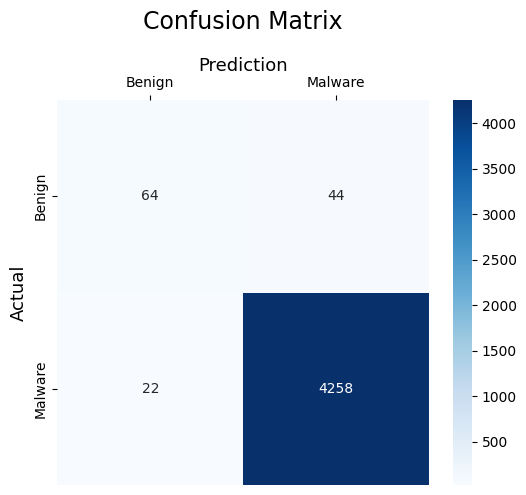


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9850 | F1-Score: 0.9923 | Loss: 0.0506 | Recall: 0.9949 | Precision: 0.9898 | TNR: 0.5926

===== RUNNING WITH EPOCH=100  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0440 | Val Acc: 0.9786 | Val F1: 0.9890 | Val Precision: 0.9886 | Val Recall: 0.9895 | Val TNR: 0.5463
Epoch 2 | Train Loss: 0.0429 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9915 | Val Recall: 0.9836 | Val TNR: 0.6667
Epoch 3 | Train Loss: 0.0445 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9900 | Val Recall: 0.9923 | Val TNR: 0.6019
Epoch 4 | Train Loss: 0.0427 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9884 | Val Recall: 0.9939 | Val TNR: 0.5370
Epoch 5 | Train Loss: 0.0421 | Val Acc: 0.9829 | Val F1: 0.9913 | Val Precision: 0.9884 | Val Recall: 0.9942 | Val TNR: 0.5370
Epoch 6 | Train Loss: 0.0431 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9916 | Val Recall: 0.9900 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0423 | Val Acc: 0.9

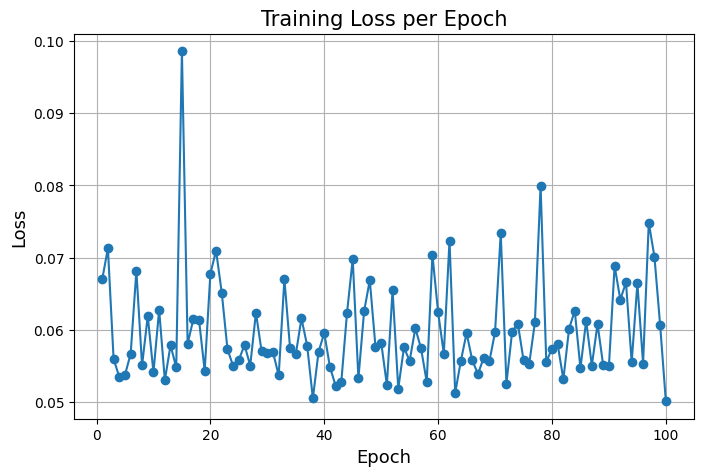

==================== TESTING ====================


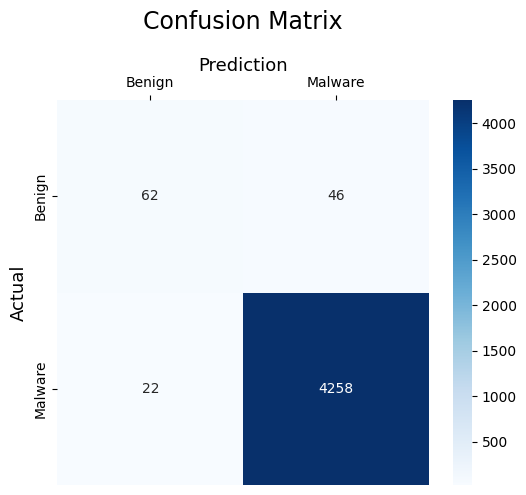


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9845 | F1-Score: 0.9921 | Loss: 0.0496 | Recall: 0.9949 | Precision: 0.9893 | TNR: 0.5741

===== RUNNING WITH EPOCH=100  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0406 | Val Acc: 0.9770 | Val F1: 0.9882 | Val Precision: 0.9904 | Val Recall: 0.9860 | Val TNR: 0.6204
Epoch 2 | Train Loss: 0.0405 | Val Acc: 0.9790 | Val F1: 0.9892 | Val Precision: 0.9918 | Val Recall: 0.9867 | Val TNR: 0.6759
Epoch 3 | Train Loss: 0.0411 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9909 | Val Recall: 0.9897 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0406 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9904 | Val Recall: 0.9900 | Val TNR: 0.6204
Epoch 5 | Train Loss: 0.0425 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9909 | Val Recall: 0.9923 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0401 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9913 | Val Recall: 0.9881 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0405 | Val Acc: 0.9

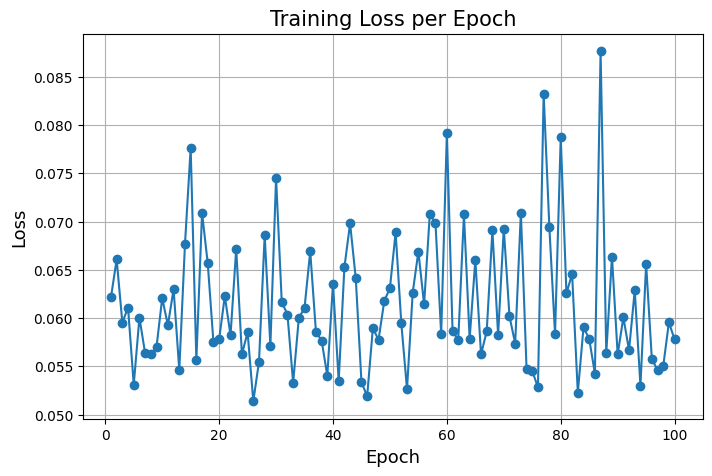

==================== TESTING ====================


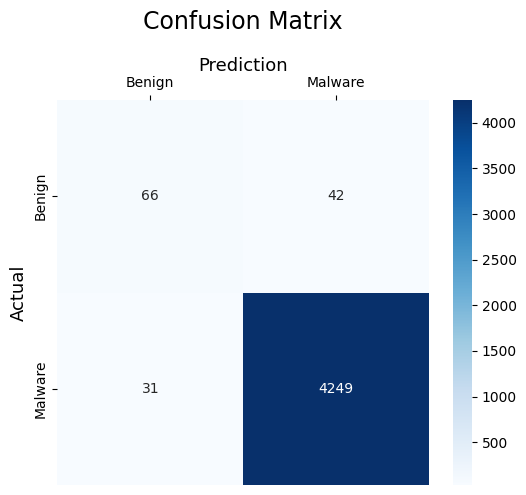


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9834 | F1-Score: 0.9915 | Loss: 0.0559 | Recall: 0.9928 | Precision: 0.9902 | TNR: 0.6111

===== RUNNING WITH EPOCH=100  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0404 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9909 | Val Recall: 0.9893 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0384 | Val Acc: 0.9793 | Val F1: 0.9894 | Val Precision: 0.9909 | Val Recall: 0.9879 | Val TNR: 0.6389
Epoch 3 | Train Loss: 0.0397 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9909 | Val Recall: 0.9883 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0398 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9904 | Val Recall: 0.9923 | Val TNR: 0.6204
Epoch 5 | Train Loss: 0.0407 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9909 | Val Recall: 0.9883 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0385 | Val Acc: 0.9838 | Val F1: 0.9917 | Val Precision: 0.9902 | Val Recall: 0.9932 | Val TNR: 0.6111
Epoch 7 | Train Loss: 0.0397 | Val Acc: 0.

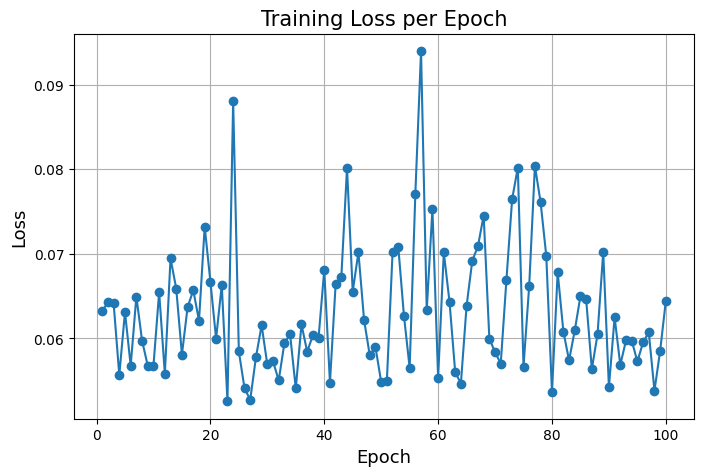

==================== TESTING ====================


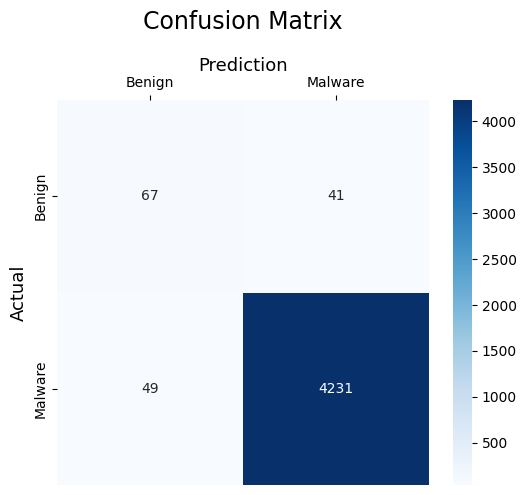


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9795 | F1-Score: 0.9895 | Loss: 0.0638 | Recall: 0.9886 | Precision: 0.9904 | TNR: 0.6204

===== RUNNING WITH EPOCH=100  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0382 | Val Acc: 0.9804 | Val F1: 0.9900 | Val Precision: 0.9900 | Val Recall: 0.9900 | Val TNR: 0.6019
Epoch 2 | Train Loss: 0.0405 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9895 | Val Recall: 0.9921 | Val TNR: 0.5833
Epoch 3 | Train Loss: 0.0373 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9909 | Val Recall: 0.9904 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0373 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9902 | Val Recall: 0.9916 | Val TNR: 0.6111
Epoch 5 | Train Loss: 0.0389 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9906 | Val Recall: 0.9888 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0383 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9909 | Val Recall: 0.9914 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0393 | Val Acc: 0.

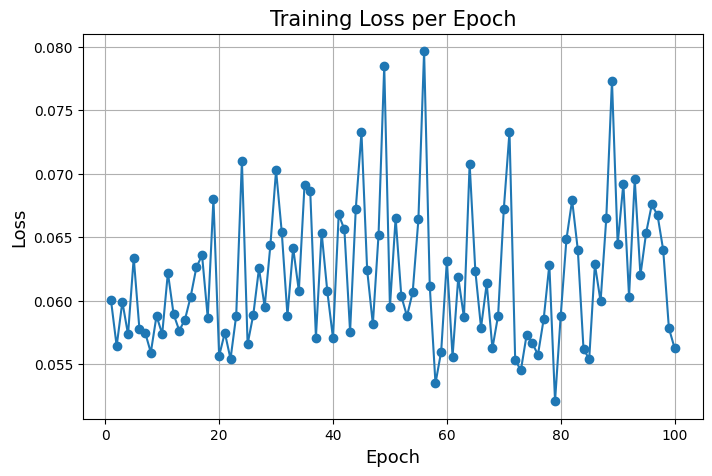

==================== TESTING ====================


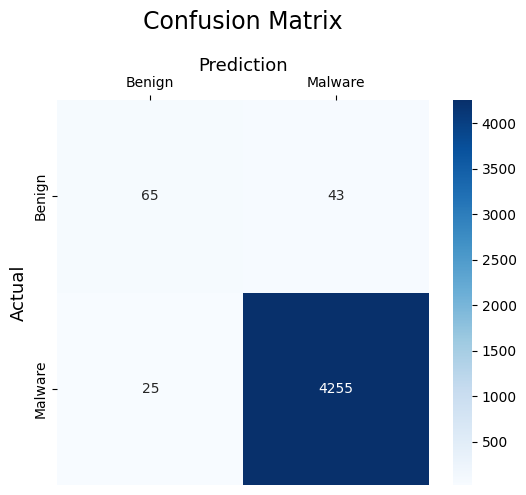


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9845 | F1-Score: 0.9921 | Loss: 0.0521 | Recall: 0.9942 | Precision: 0.9900 | TNR: 0.6019

===== RUNNING WITH EPOCH=100  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0401 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9909 | Val Recall: 0.9886 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0381 | Val Acc: 0.9815 | Val F1: 0.9905 | Val Precision: 0.9907 | Val Recall: 0.9904 | Val TNR: 0.6296
Epoch 3 | Train Loss: 0.0382 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9909 | Val Recall: 0.9893 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0385 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9902 | Val Recall: 0.9907 | Val TNR: 0.6111
Epoch 5 | Train Loss: 0.0374 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9904 | Val Recall: 0.9874 | Val TNR: 0.6204
Epoch 6 | Train Loss: 0.0374 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9902 | Val Recall: 0.9902 | Val TNR: 0.6111
Epoch 7 | Train Loss: 0.0381 | Val Acc: 0.

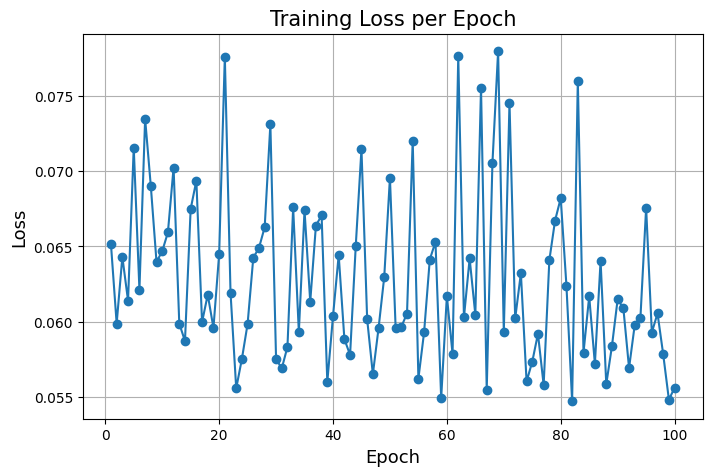

==================== TESTING ====================


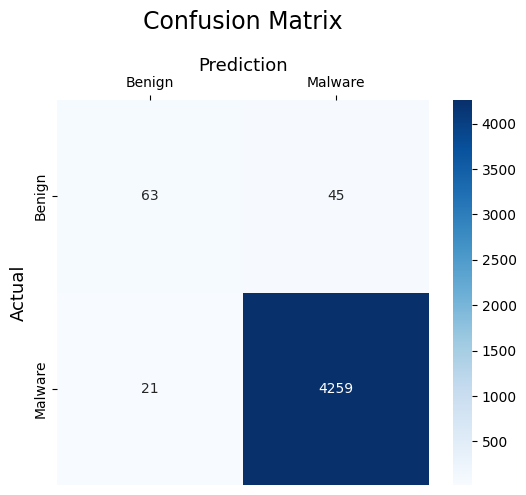


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9850 | F1-Score: 0.9923 | Loss: 0.0514 | Recall: 0.9951 | Precision: 0.9895 | TNR: 0.5833

===== RUNNING WITH EPOCH=100  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0360 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9909 | Val Recall: 0.9907 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0380 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9911 | Val Recall: 0.9848 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0372 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9911 | Val Recall: 0.9855 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0376 | Val Acc: 0.9790 | Val F1: 0.9892 | Val Precision: 0.9909 | Val Recall: 0.9876 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0386 | Val Acc: 0.9786 | Val F1: 0.9890 | Val Precision: 0.9909 | Val Recall: 0.9871 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0374 | Val Acc: 0.9777 | Val F1: 0.9885 | Val Precision: 0.9913 | Val Recall: 0.9857 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0364 | Val Acc: 0.

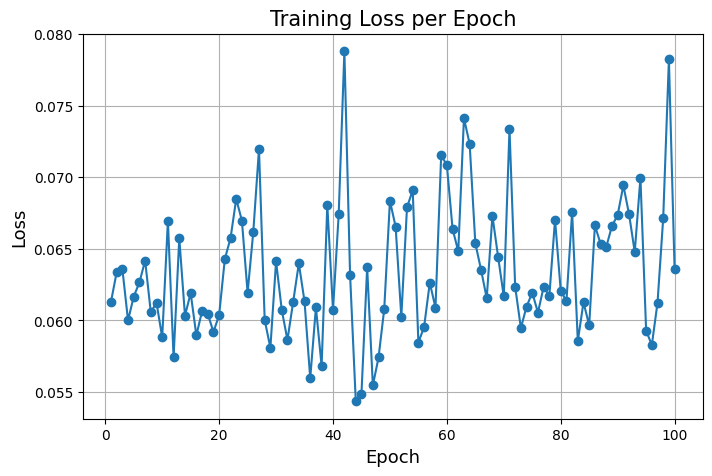

==================== TESTING ====================


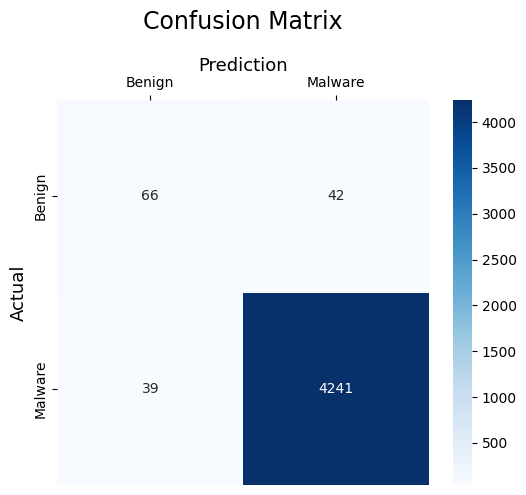


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9815 | F1-Score: 0.9905 | Loss: 0.0615 | Recall: 0.9909 | Precision: 0.9902 | TNR: 0.6111

===== RUNNING WITH EPOCH=125  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0423 | Val Acc: 0.9815 | Val F1: 0.9905 | Val Precision: 0.9907 | Val Recall: 0.9904 | Val TNR: 0.6296
Epoch 2 | Train Loss: 0.0401 | Val Acc: 0.9836 | Val F1: 0.9916 | Val Precision: 0.9884 | Val Recall: 0.9949 | Val TNR: 0.5370
Epoch 3 | Train Loss: 0.0401 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9909 | Val Recall: 0.9904 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0390 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9909 | Val Recall: 0.9900 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0398 | Val Acc: 0.9790 | Val F1: 0.9892 | Val Precision: 0.9911 | Val Recall: 0.9874 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0415 | Val Acc: 0.9711 | Val F1: 0.9851 | Val Precision: 0.9906 | Val Recall: 0.9797 | Val TNR: 0.6296
Epoch 7 | Train Loss: 0.0403 | Val Acc: 0.9

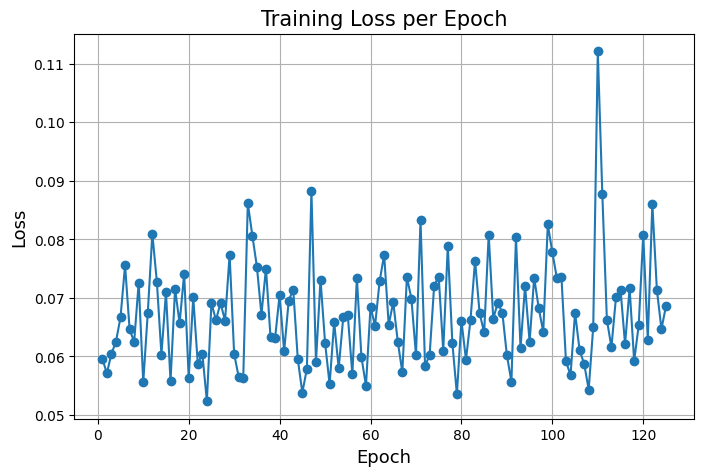

==================== TESTING ====================


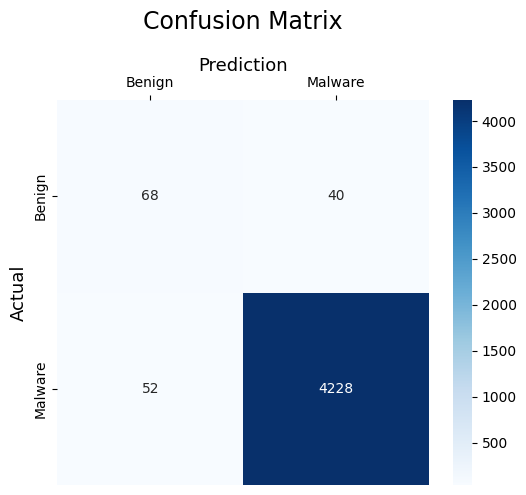


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9790 | F1-Score: 0.9892 | Loss: 0.0694 | Recall: 0.9879 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=125  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0383 | Val Acc: 0.9697 | Val F1: 0.9844 | Val Precision: 0.9915 | Val Recall: 0.9773 | Val TNR: 0.6667
Epoch 2 | Train Loss: 0.0385 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9906 | Val Recall: 0.9820 | Val TNR: 0.6296
Epoch 3 | Train Loss: 0.0385 | Val Acc: 0.9781 | Val F1: 0.9888 | Val Precision: 0.9908 | Val Recall: 0.9867 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0387 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9906 | Val Recall: 0.9883 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0397 | Val Acc: 0.9642 | Val F1: 0.9815 | Val Precision: 0.9926 | Val Recall: 0.9706 | Val TNR: 0.7130
Epoch 6 | Train Loss: 0.0394 | Val Acc: 0.9740 | Val F1: 0.9866 | Val Precision: 0.9894 | Val Recall: 0.9839 | Val TNR: 0.5833
Epoch 7 | Train Loss: 0.0393 | Val Acc: 0.9

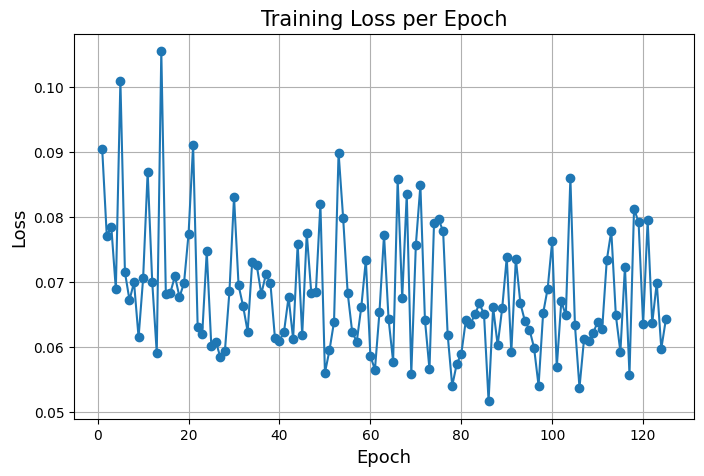

==================== TESTING ====================


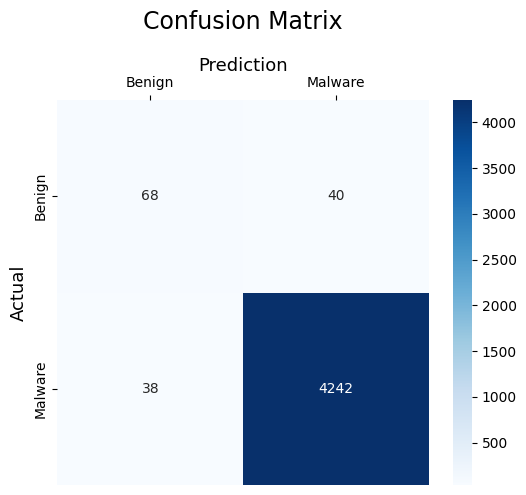


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9822 | F1-Score: 0.9909 | Loss: 0.0613 | Recall: 0.9911 | Precision: 0.9907 | TNR: 0.6296

===== RUNNING WITH EPOCH=125  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0369 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9906 | Val Recall: 0.9900 | Val TNR: 0.6296
Epoch 2 | Train Loss: 0.0372 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9904 | Val Recall: 0.9890 | Val TNR: 0.6204
Epoch 3 | Train Loss: 0.0370 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9904 | Val Recall: 0.9918 | Val TNR: 0.6204
Epoch 4 | Train Loss: 0.0380 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9906 | Val Recall: 0.9902 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0393 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9888 | Val Recall: 0.9914 | Val TNR: 0.5556
Epoch 6 | Train Loss: 0.0378 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9906 | Val Recall: 0.9886 | Val TNR: 0.6296
Epoch 7 | Train Loss: 0.0370 | Val Acc: 0.

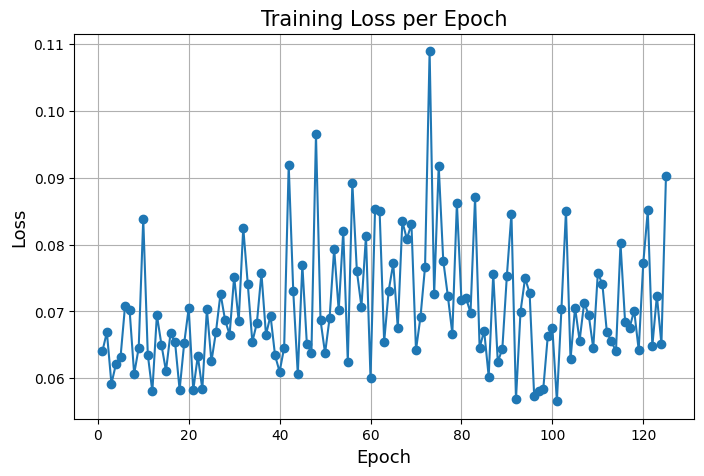

==================== TESTING ====================


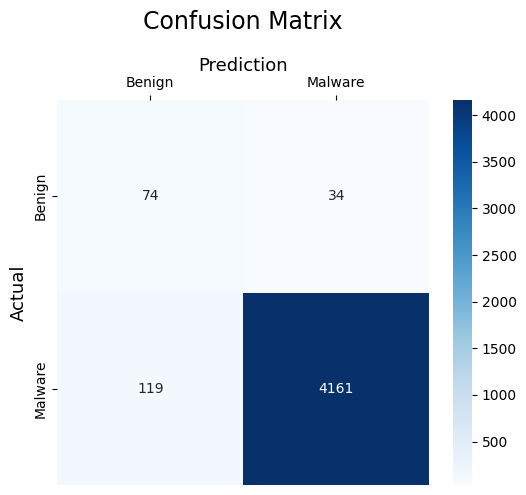


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9651 | F1-Score: 0.9819 | Loss: 0.0947 | Recall: 0.9722 | Precision: 0.9919 | TNR: 0.6852

===== RUNNING WITH EPOCH=125  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0368 | Val Acc: 0.9754 | Val F1: 0.9873 | Val Precision: 0.9913 | Val Recall: 0.9834 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0363 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9915 | Val Recall: 0.9836 | Val TNR: 0.6667
Epoch 3 | Train Loss: 0.0374 | Val Acc: 0.9665 | Val F1: 0.9827 | Val Precision: 0.9928 | Val Recall: 0.9727 | Val TNR: 0.7222
Epoch 4 | Train Loss: 0.0373 | Val Acc: 0.9774 | Val F1: 0.9884 | Val Precision: 0.9915 | Val Recall: 0.9853 | Val TNR: 0.6667
Epoch 5 | Train Loss: 0.0363 | Val Acc: 0.9722 | Val F1: 0.9857 | Val Precision: 0.9917 | Val Recall: 0.9797 | Val TNR: 0.6759
Epoch 6 | Train Loss: 0.0379 | Val Acc: 0.9756 | Val F1: 0.9875 | Val Precision: 0.9913 | Val Recall: 0.9836 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0375 | Val Acc: 0.

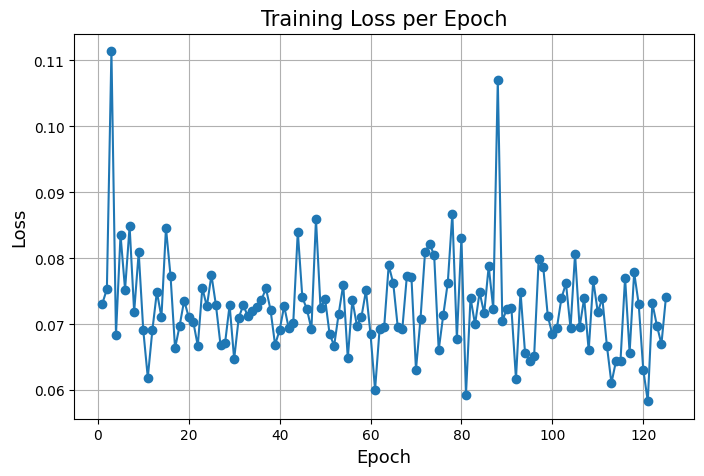

==================== TESTING ====================


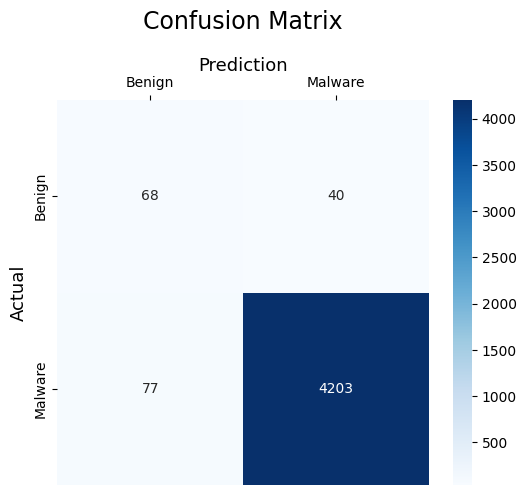


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9733 | F1-Score: 0.9863 | Loss: 0.0750 | Recall: 0.9820 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=125  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0365 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9911 | Val Recall: 0.9867 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0360 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9911 | Val Recall: 0.9841 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0366 | Val Acc: 0.9768 | Val F1: 0.9881 | Val Precision: 0.9899 | Val Recall: 0.9862 | Val TNR: 0.6019
Epoch 4 | Train Loss: 0.0384 | Val Acc: 0.9754 | Val F1: 0.9873 | Val Precision: 0.9913 | Val Recall: 0.9834 | Val TNR: 0.6574
Epoch 5 | Train Loss: 0.0365 | Val Acc: 0.9754 | Val F1: 0.9873 | Val Precision: 0.9908 | Val Recall: 0.9839 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0367 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9915 | Val Recall: 0.9827 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0359 | Val Acc: 0.

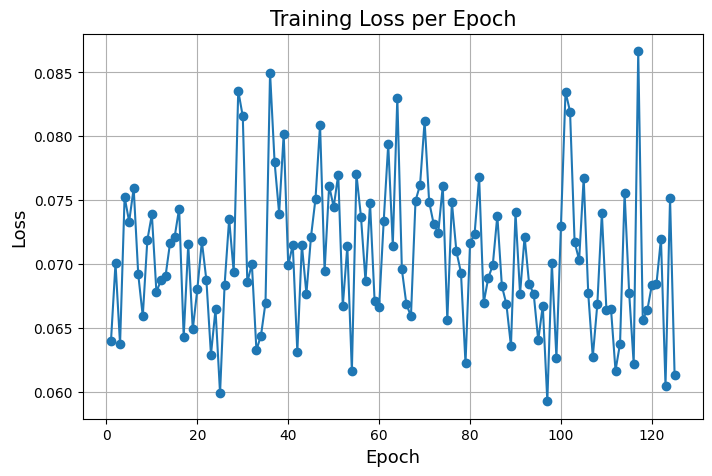

==================== TESTING ====================


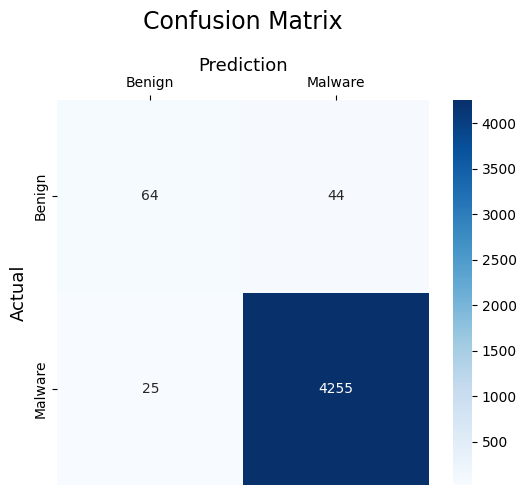


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9843 | F1-Score: 0.9920 | Loss: 0.0600 | Recall: 0.9942 | Precision: 0.9898 | TNR: 0.5926

===== RUNNING WITH EPOCH=125  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0374 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9911 | Val Recall: 0.9855 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0354 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9902 | Val Recall: 0.9916 | Val TNR: 0.6111
Epoch 3 | Train Loss: 0.0372 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9911 | Val Recall: 0.9843 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0351 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9911 | Val Recall: 0.9871 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0353 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9890 | Val Recall: 0.9918 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0358 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9904 | Val Recall: 0.9914 | Val TNR: 0.6204
Epoch 7 | Train Loss: 0.0372 | Val Acc: 0.

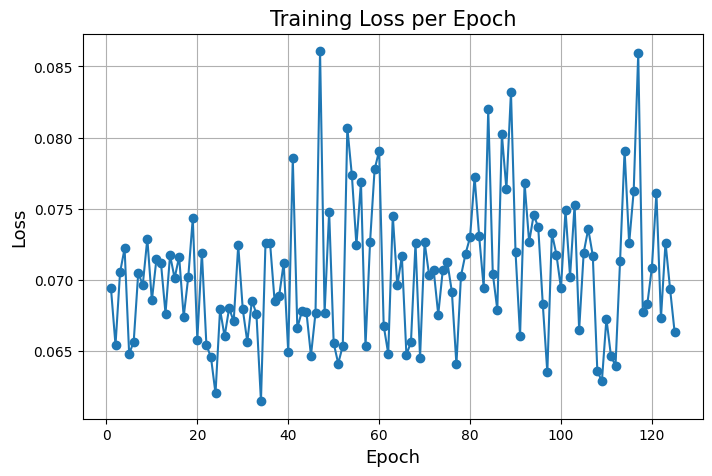

==================== TESTING ====================


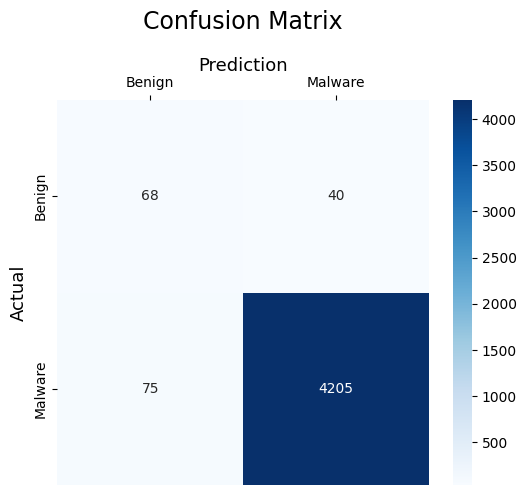


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9738 | F1-Score: 0.9865 | Loss: 0.0667 | Recall: 0.9825 | Precision: 0.9906 | TNR: 0.6296

===== RUNNING WITH EPOCH=150  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0404 | Val Acc: 0.9690 | Val F1: 0.9840 | Val Precision: 0.9917 | Val Recall: 0.9764 | Val TNR: 0.6759
Epoch 2 | Train Loss: 0.0401 | Val Acc: 0.9708 | Val F1: 0.9850 | Val Precision: 0.9899 | Val Recall: 0.9801 | Val TNR: 0.6019
Epoch 3 | Train Loss: 0.0383 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9890 | Val Recall: 0.9916 | Val TNR: 0.5648
Epoch 4 | Train Loss: 0.0390 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9892 | Val Recall: 0.9862 | Val TNR: 0.5741
Epoch 5 | Train Loss: 0.0394 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9906 | Val Recall: 0.9897 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0383 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9904 | Val Recall: 0.9869 | Val TNR: 0.6204
Epoch 7 | Train Loss: 0.0380 | Val Acc: 0.9

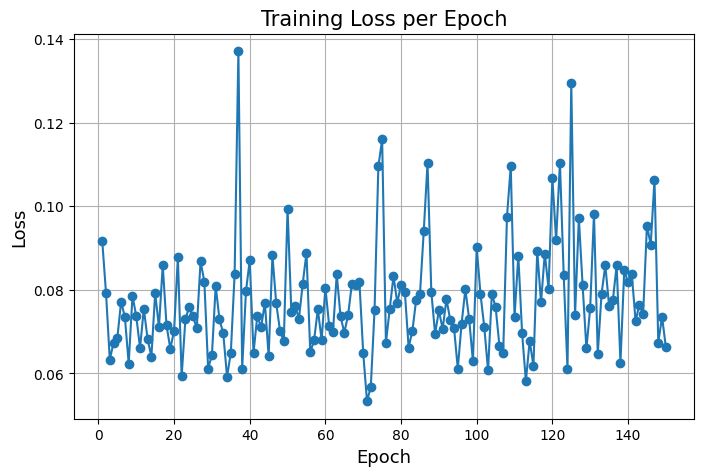

==================== TESTING ====================


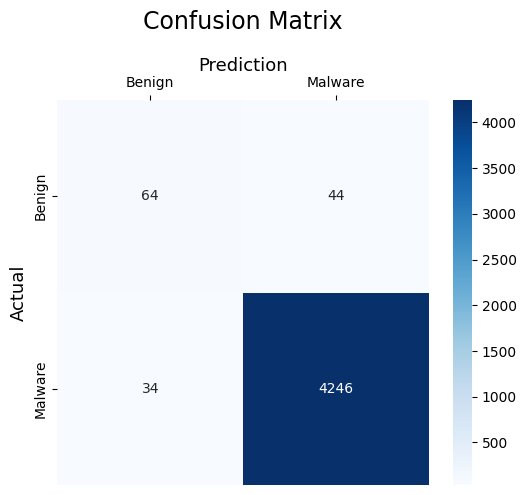


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9822 | F1-Score: 0.9909 | Loss: 0.0643 | Recall: 0.9921 | Precision: 0.9897 | TNR: 0.5926

===== RUNNING WITH EPOCH=150  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0370 | Val Acc: 0.9781 | Val F1: 0.9888 | Val Precision: 0.9908 | Val Recall: 0.9867 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0364 | Val Acc: 0.9745 | Val F1: 0.9869 | Val Precision: 0.9910 | Val Recall: 0.9827 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0372 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9891 | Val Recall: 0.9925 | Val TNR: 0.5648
Epoch 4 | Train Loss: 0.0378 | Val Acc: 0.9715 | Val F1: 0.9853 | Val Precision: 0.9922 | Val Recall: 0.9785 | Val TNR: 0.6944
Epoch 5 | Train Loss: 0.0373 | Val Acc: 0.9752 | Val F1: 0.9872 | Val Precision: 0.9913 | Val Recall: 0.9832 | Val TNR: 0.6574
Epoch 6 | Train Loss: 0.0374 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9913 | Val Recall: 0.9813 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0359 | Val Acc: 0.9

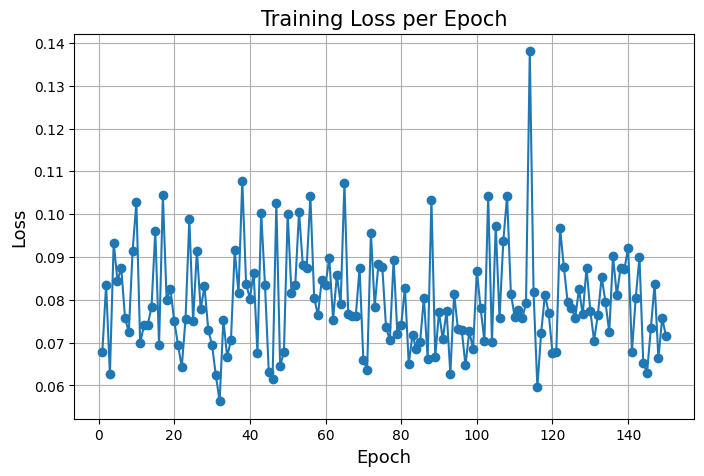

==================== TESTING ====================


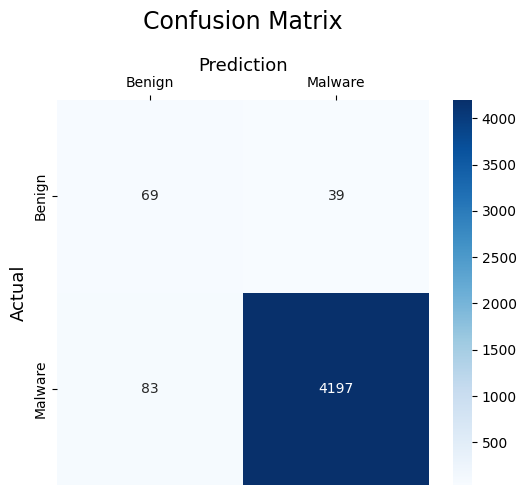


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9722 | F1-Score: 0.9857 | Loss: 0.0738 | Recall: 0.9806 | Precision: 0.9908 | TNR: 0.6389

===== RUNNING WITH EPOCH=150  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0380 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9911 | Val Recall: 0.9862 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0365 | Val Acc: 0.9756 | Val F1: 0.9875 | Val Precision: 0.9913 | Val Recall: 0.9836 | Val TNR: 0.6574
Epoch 3 | Train Loss: 0.0359 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9907 | Val Recall: 0.9907 | Val TNR: 0.6296
Epoch 4 | Train Loss: 0.0359 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9915 | Val Recall: 0.9811 | Val TNR: 0.6667
Epoch 5 | Train Loss: 0.0361 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9911 | Val Recall: 0.9843 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0356 | Val Acc: 0.9690 | Val F1: 0.9840 | Val Precision: 0.9919 | Val Recall: 0.9762 | Val TNR: 0.6852
Epoch 7 | Train Loss: 0.0364 | Val Acc: 0.

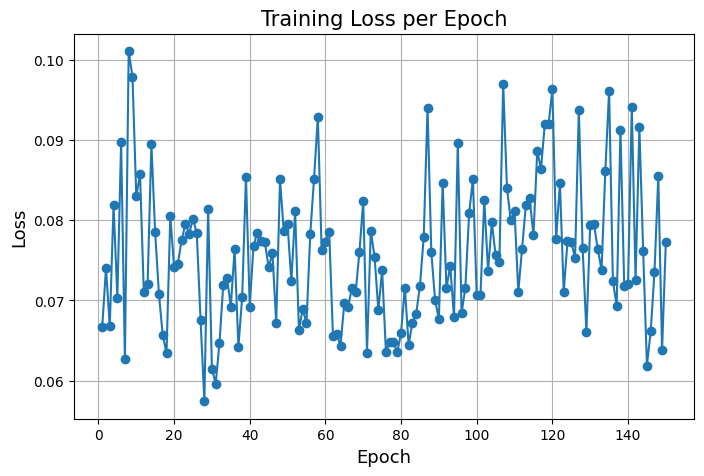

==================== TESTING ====================


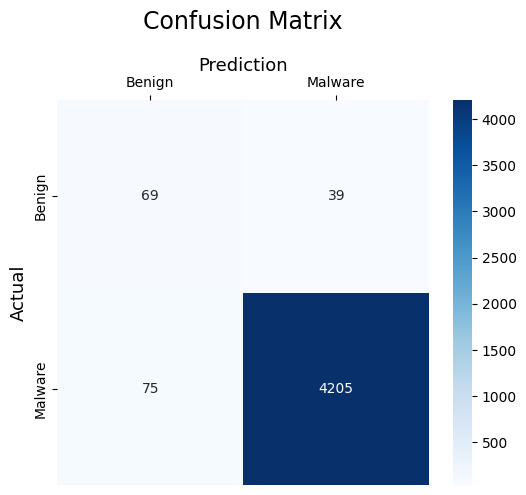


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9740 | F1-Score: 0.9866 | Loss: 0.0784 | Recall: 0.9825 | Precision: 0.9908 | TNR: 0.6389

===== RUNNING WITH EPOCH=150  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0378 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9913 | Val Recall: 0.9846 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0363 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9901 | Val Recall: 0.9850 | Val TNR: 0.6111
Epoch 3 | Train Loss: 0.0342 | Val Acc: 0.9768 | Val F1: 0.9880 | Val Precision: 0.9911 | Val Recall: 0.9850 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0381 | Val Acc: 0.9692 | Val F1: 0.9841 | Val Precision: 0.9910 | Val Recall: 0.9773 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0352 | Val Acc: 0.9768 | Val F1: 0.9881 | Val Precision: 0.9908 | Val Recall: 0.9853 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0351 | Val Acc: 0.9686 | Val F1: 0.9838 | Val Precision: 0.9915 | Val Recall: 0.9762 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0361 | Val Acc: 0.

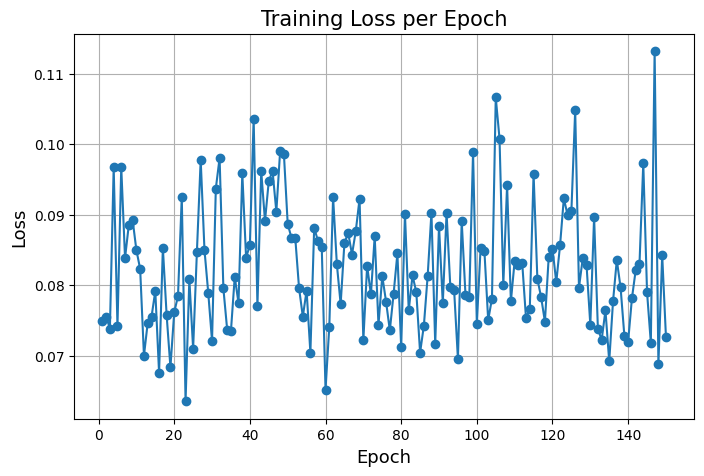

==================== TESTING ====================


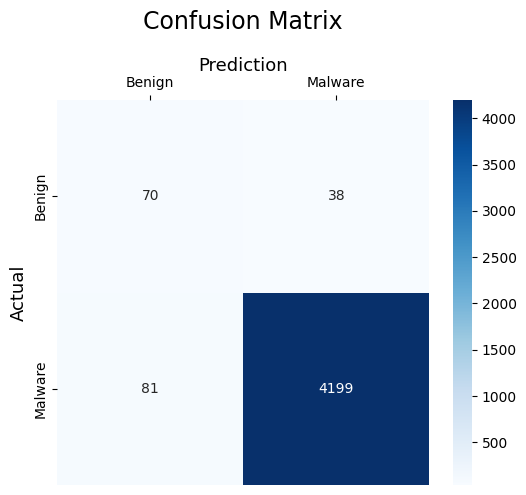


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9729 | F1-Score: 0.9860 | Loss: 0.0710 | Recall: 0.9811 | Precision: 0.9910 | TNR: 0.6481

===== RUNNING WITH EPOCH=150  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0372 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9908 | Val Recall: 0.9846 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0354 | Val Acc: 0.9752 | Val F1: 0.9872 | Val Precision: 0.9894 | Val Recall: 0.9850 | Val TNR: 0.5833
Epoch 3 | Train Loss: 0.0346 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9915 | Val Recall: 0.9811 | Val TNR: 0.6667
Epoch 4 | Train Loss: 0.0347 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9906 | Val Recall: 0.9853 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0345 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9913 | Val Recall: 0.9841 | Val TNR: 0.6574
Epoch 6 | Train Loss: 0.0345 | Val Acc: 0.9717 | Val F1: 0.9854 | Val Precision: 0.9913 | Val Recall: 0.9797 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0359 | Val Acc: 0.

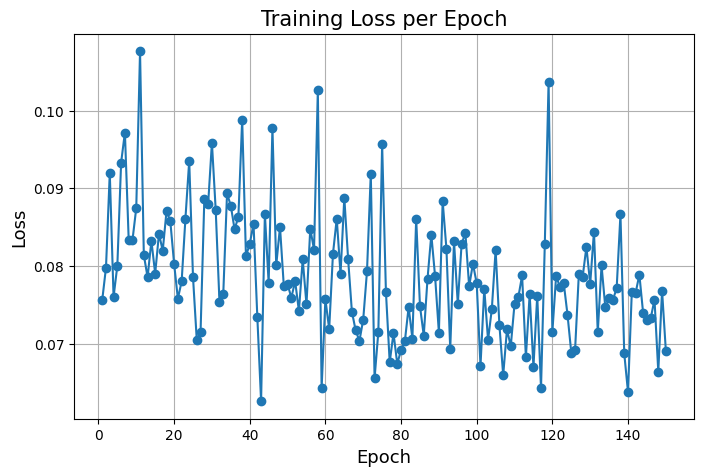

==================== TESTING ====================


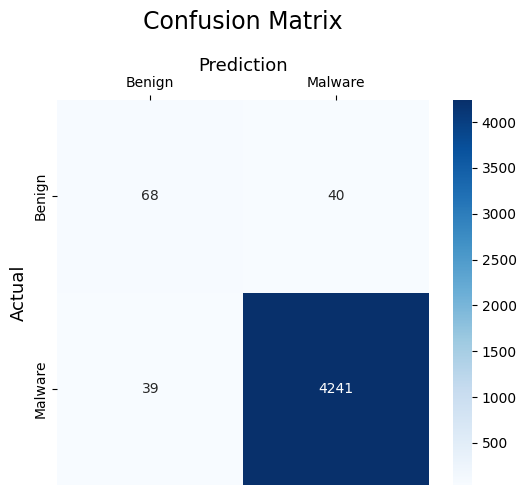


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9820 | F1-Score: 0.9908 | Loss: 0.0679 | Recall: 0.9909 | Precision: 0.9907 | TNR: 0.6296

===== RUNNING WITH EPOCH=150  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0349 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9893 | Val Recall: 0.9930 | Val TNR: 0.5741
Epoch 2 | Train Loss: 0.0348 | Val Acc: 0.9754 | Val F1: 0.9873 | Val Precision: 0.9911 | Val Recall: 0.9836 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0347 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9895 | Val Recall: 0.9864 | Val TNR: 0.5833
Epoch 4 | Train Loss: 0.0354 | Val Acc: 0.9742 | Val F1: 0.9868 | Val Precision: 0.9897 | Val Recall: 0.9839 | Val TNR: 0.5926
Epoch 5 | Train Loss: 0.0346 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9906 | Val Recall: 0.9897 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0349 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9904 | Val Recall: 0.9904 | Val TNR: 0.6204
Epoch 7 | Train Loss: 0.0349 | Val Acc: 0.

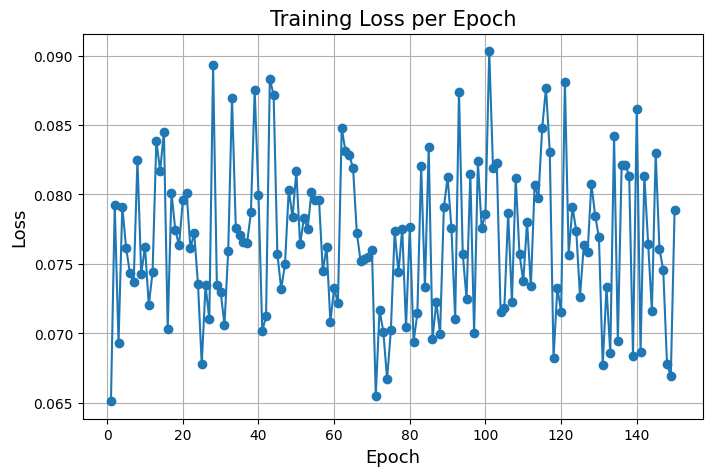

==================== TESTING ====================


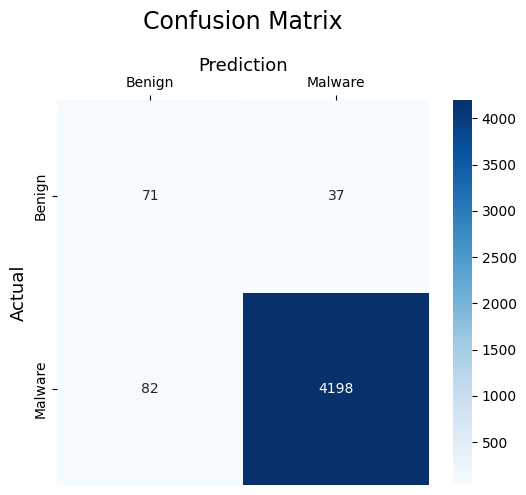


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9729 | F1-Score: 0.9860 | Loss: 0.0767 | Recall: 0.9808 | Precision: 0.9913 | TNR: 0.6574

===== RUNNING WITH EPOCH=175  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0393 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9904 | Val Recall: 0.9890 | Val TNR: 0.6204
Epoch 2 | Train Loss: 0.0369 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9890 | Val Recall: 0.9911 | Val TNR: 0.5648
Epoch 3 | Train Loss: 0.0386 | Val Acc: 0.9663 | Val F1: 0.9825 | Val Precision: 0.9921 | Val Recall: 0.9731 | Val TNR: 0.6944
Epoch 4 | Train Loss: 0.0376 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9895 | Val Recall: 0.9928 | Val TNR: 0.5833
Epoch 5 | Train Loss: 0.0367 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9892 | Val Recall: 0.9864 | Val TNR: 0.5741
Epoch 6 | Train Loss: 0.0364 | Val Acc: 0.9711 | Val F1: 0.9851 | Val Precision: 0.9917 | Val Recall: 0.9785 | Val TNR: 0.6759
Epoch 7 | Train Loss: 0.0365 | Val Acc: 0.9

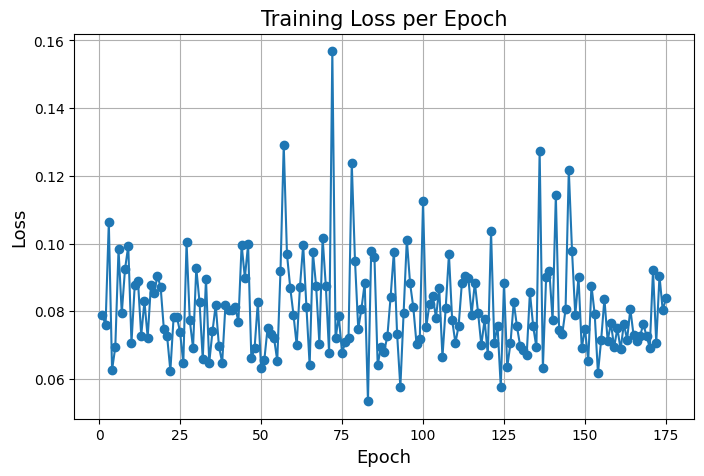

==================== TESTING ====================


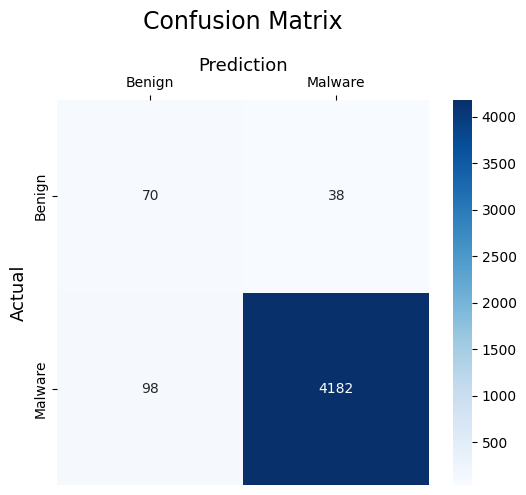


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9690 | F1-Score: 0.9840 | Loss: 0.0862 | Recall: 0.9771 | Precision: 0.9910 | TNR: 0.6481

===== RUNNING WITH EPOCH=175  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0366 | Val Acc: 0.9781 | Val F1: 0.9888 | Val Precision: 0.9908 | Val Recall: 0.9867 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0361 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9911 | Val Recall: 0.9846 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0354 | Val Acc: 0.9742 | Val F1: 0.9867 | Val Precision: 0.9917 | Val Recall: 0.9818 | Val TNR: 0.6759
Epoch 4 | Train Loss: 0.0353 | Val Acc: 0.9847 | Val F1: 0.9922 | Val Precision: 0.9907 | Val Recall: 0.9937 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0369 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9907 | Val Recall: 0.9911 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0370 | Val Acc: 0.9829 | Val F1: 0.9912 | Val Precision: 0.9909 | Val Recall: 0.9916 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0349 | Val Acc: 0.9

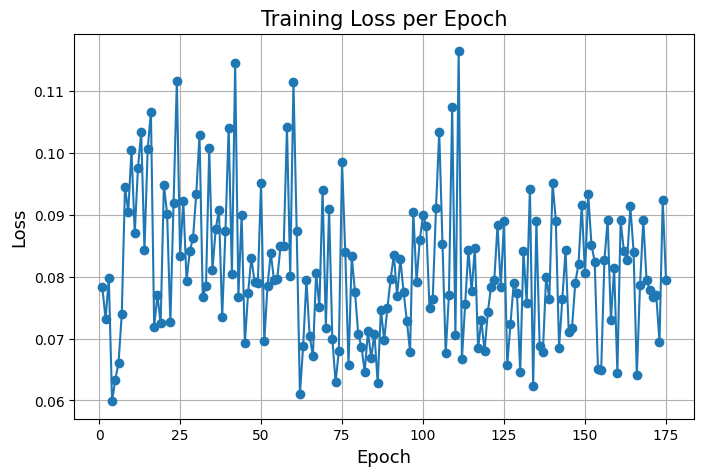

==================== TESTING ====================


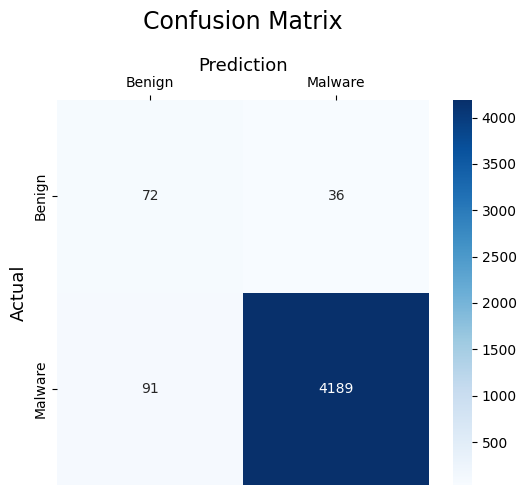


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9711 | F1-Score: 0.9851 | Loss: 0.0807 | Recall: 0.9787 | Precision: 0.9915 | TNR: 0.6667

===== RUNNING WITH EPOCH=175  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0359 | Val Acc: 0.9729 | Val F1: 0.9860 | Val Precision: 0.9917 | Val Recall: 0.9804 | Val TNR: 0.6759
Epoch 2 | Train Loss: 0.0356 | Val Acc: 0.9738 | Val F1: 0.9865 | Val Precision: 0.9913 | Val Recall: 0.9818 | Val TNR: 0.6574
Epoch 3 | Train Loss: 0.0347 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9915 | Val Recall: 0.9825 | Val TNR: 0.6667
Epoch 4 | Train Loss: 0.0357 | Val Acc: 0.9768 | Val F1: 0.9880 | Val Precision: 0.9913 | Val Recall: 0.9848 | Val TNR: 0.6574
Epoch 5 | Train Loss: 0.0366 | Val Acc: 0.9713 | Val F1: 0.9852 | Val Precision: 0.9917 | Val Recall: 0.9787 | Val TNR: 0.6759
Epoch 6 | Train Loss: 0.0345 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9913 | Val Recall: 0.9829 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0353 | Val Acc: 0.

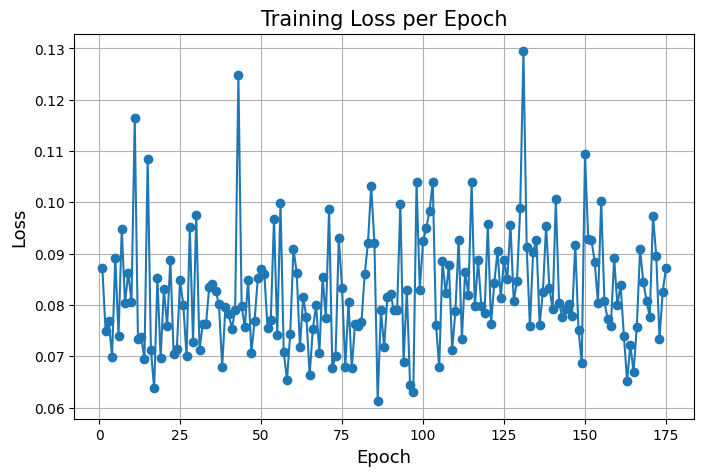

==================== TESTING ====================


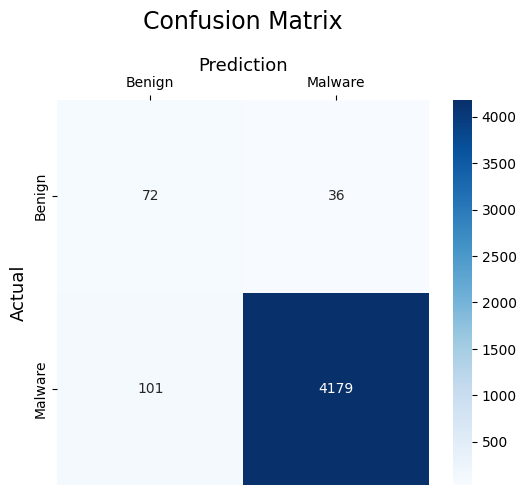


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9688 | F1-Score: 0.9839 | Loss: 0.0879 | Recall: 0.9764 | Precision: 0.9915 | TNR: 0.6667

===== RUNNING WITH EPOCH=175  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0350 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9913 | Val Recall: 0.9843 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0345 | Val Acc: 0.9711 | Val F1: 0.9851 | Val Precision: 0.9919 | Val Recall: 0.9783 | Val TNR: 0.6852
Epoch 3 | Train Loss: 0.0338 | Val Acc: 0.9756 | Val F1: 0.9874 | Val Precision: 0.9915 | Val Recall: 0.9834 | Val TNR: 0.6667
Epoch 4 | Train Loss: 0.0350 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9911 | Val Recall: 0.9879 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0351 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9915 | Val Recall: 0.9827 | Val TNR: 0.6667
Epoch 6 | Train Loss: 0.0366 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9915 | Val Recall: 0.9825 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0348 | Val Acc: 0.

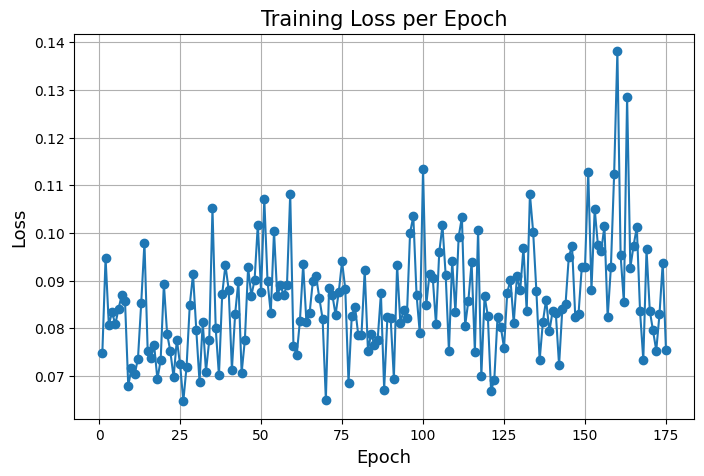

==================== TESTING ====================


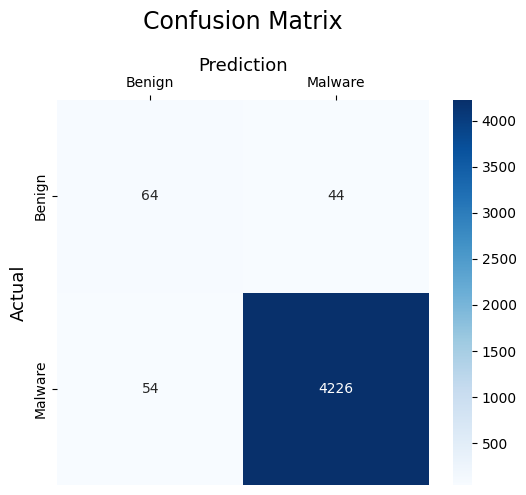


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9777 | F1-Score: 0.9885 | Loss: 0.0785 | Recall: 0.9874 | Precision: 0.9897 | TNR: 0.5926

===== RUNNING WITH EPOCH=175  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0365 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9908 | Val Recall: 0.9846 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0342 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9908 | Val Recall: 0.9857 | Val TNR: 0.6389
Epoch 3 | Train Loss: 0.0347 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9908 | Val Recall: 0.9832 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0335 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9911 | Val Recall: 0.9855 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0353 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9909 | Val Recall: 0.9869 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0353 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9909 | Val Recall: 0.9883 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0352 | Val Acc: 0.

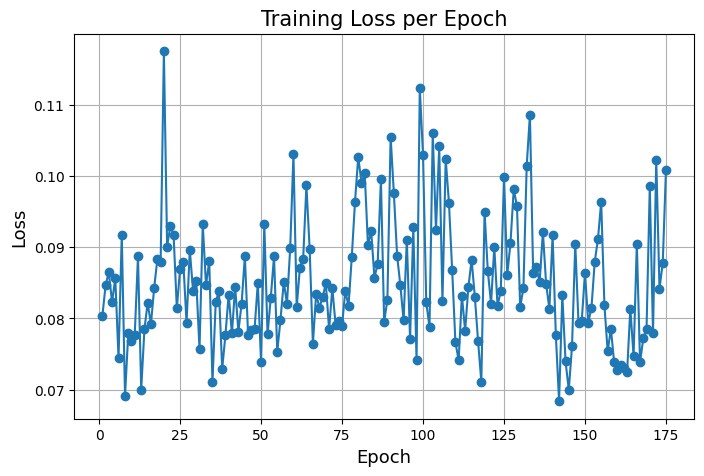

==================== TESTING ====================


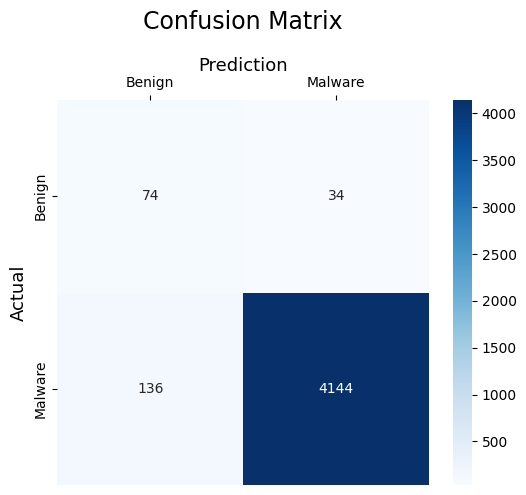


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9613 | F1-Score: 0.9799 | Loss: 0.1020 | Recall: 0.9682 | Precision: 0.9919 | TNR: 0.6852

===== RUNNING WITH EPOCH=175  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0336 | Val Acc: 0.9729 | Val F1: 0.9860 | Val Precision: 0.9910 | Val Recall: 0.9811 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0331 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9910 | Val Recall: 0.9829 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0328 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9910 | Val Recall: 0.9829 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0345 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9913 | Val Recall: 0.9827 | Val TNR: 0.6574
Epoch 5 | Train Loss: 0.0341 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9913 | Val Recall: 0.9827 | Val TNR: 0.6574
Epoch 6 | Train Loss: 0.0340 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9913 | Val Recall: 0.9829 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0330 | Val Acc: 0.

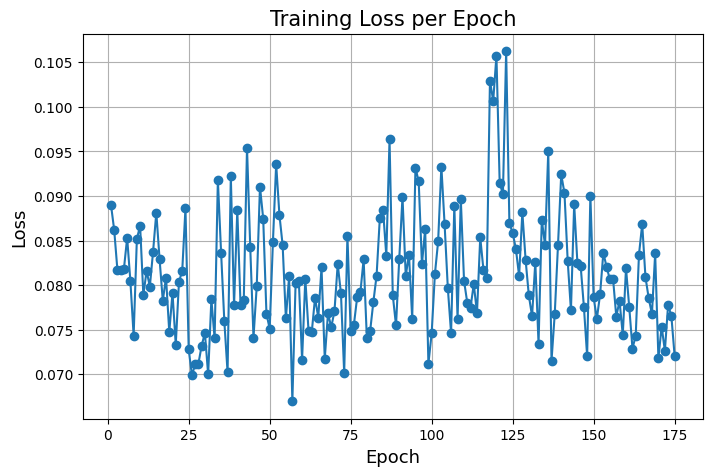

==================== TESTING ====================


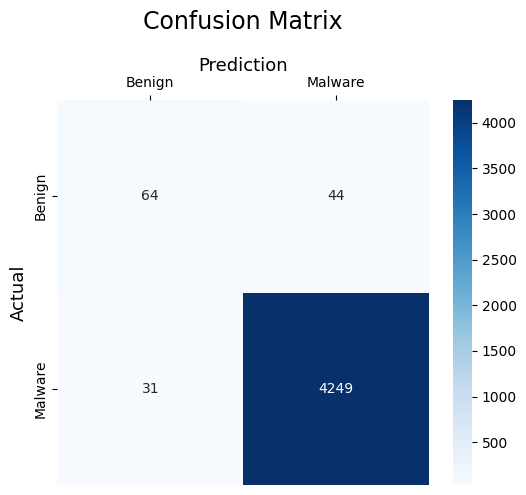


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9829 | F1-Score: 0.9913 | Loss: 0.0704 | Recall: 0.9928 | Precision: 0.9898 | TNR: 0.5926

===== RUNNING WITH EPOCH=200  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0376 | Val Acc: 0.9827 | Val F1: 0.9911 | Val Precision: 0.9904 | Val Recall: 0.9918 | Val TNR: 0.6204
Epoch 2 | Train Loss: 0.0361 | Val Acc: 0.9672 | Val F1: 0.9830 | Val Precision: 0.9924 | Val Recall: 0.9738 | Val TNR: 0.7037
Epoch 3 | Train Loss: 0.0380 | Val Acc: 0.9708 | Val F1: 0.9849 | Val Precision: 0.9922 | Val Recall: 0.9778 | Val TNR: 0.6944
Epoch 4 | Train Loss: 0.0363 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9907 | Val Recall: 0.9911 | Val TNR: 0.6296
Epoch 5 | Train Loss: 0.0358 | Val Acc: 0.9822 | Val F1: 0.9909 | Val Precision: 0.9907 | Val Recall: 0.9911 | Val TNR: 0.6296
Epoch 6 | Train Loss: 0.0365 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9891 | Val Recall: 0.9930 | Val TNR: 0.5648
Epoch 7 | Train Loss: 0.0345 | Val Acc: 0.9

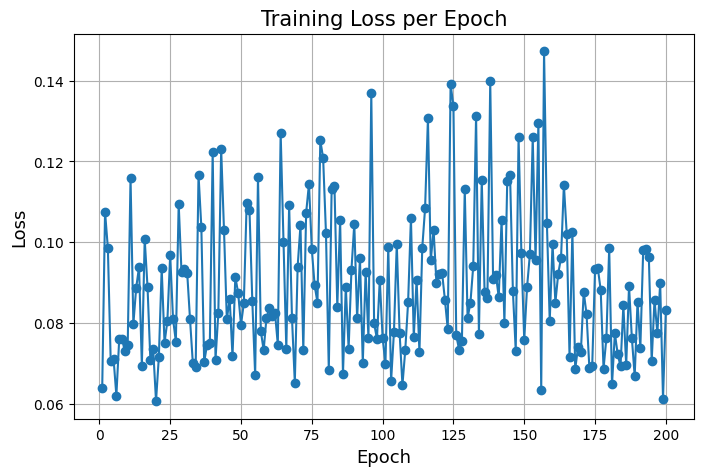

==================== TESTING ====================


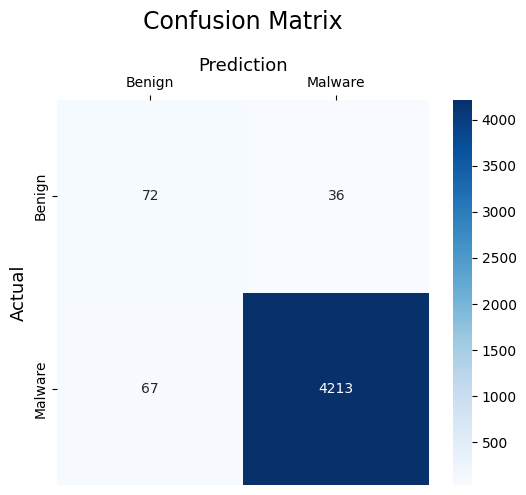


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9765 | F1-Score: 0.9879 | Loss: 0.0817 | Recall: 0.9843 | Precision: 0.9915 | TNR: 0.6667

===== RUNNING WITH EPOCH=200  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0365 | Val Acc: 0.9724 | Val F1: 0.9858 | Val Precision: 0.9929 | Val Recall: 0.9787 | Val TNR: 0.7222
Epoch 2 | Train Loss: 0.0345 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9904 | Val Recall: 0.9890 | Val TNR: 0.6204
Epoch 3 | Train Loss: 0.0343 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9908 | Val Recall: 0.9864 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0345 | Val Acc: 0.9683 | Val F1: 0.9836 | Val Precision: 0.9919 | Val Recall: 0.9755 | Val TNR: 0.6852
Epoch 5 | Train Loss: 0.0355 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9918 | Val Recall: 0.9864 | Val TNR: 0.6759
Epoch 6 | Train Loss: 0.0345 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9911 | Val Recall: 0.9883 | Val TNR: 0.6481
Epoch 7 | Train Loss: 0.0379 | Val Acc: 0.9

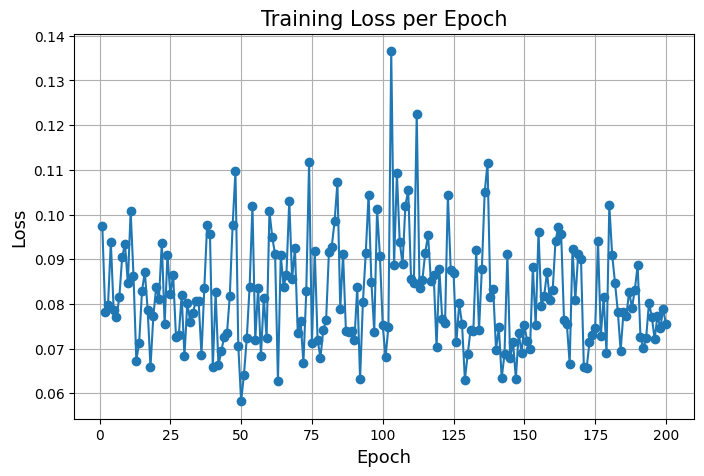

==================== TESTING ====================


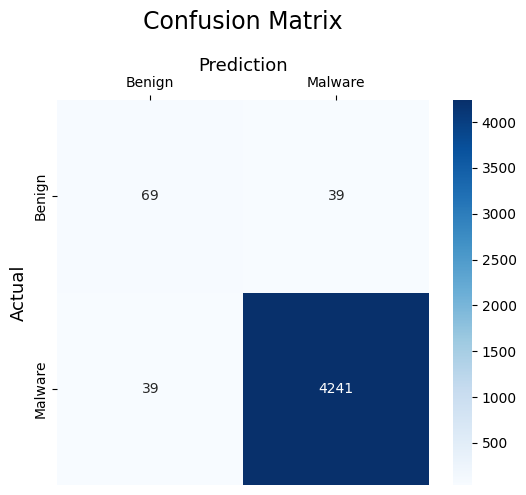


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9822 | F1-Score: 0.9909 | Loss: 0.0741 | Recall: 0.9909 | Precision: 0.9909 | TNR: 0.6389

===== RUNNING WITH EPOCH=200  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0356 | Val Acc: 0.9815 | Val F1: 0.9905 | Val Precision: 0.9909 | Val Recall: 0.9902 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0342 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9913 | Val Recall: 0.9813 | Val TNR: 0.6574
Epoch 3 | Train Loss: 0.0346 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9908 | Val Recall: 0.9850 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0344 | Val Acc: 0.9774 | Val F1: 0.9884 | Val Precision: 0.9908 | Val Recall: 0.9860 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0349 | Val Acc: 0.9713 | Val F1: 0.9852 | Val Precision: 0.9912 | Val Recall: 0.9792 | Val TNR: 0.6574
Epoch 6 | Train Loss: 0.0359 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9906 | Val Recall: 0.9902 | Val TNR: 0.6296
Epoch 7 | Train Loss: 0.0338 | Val Acc: 0.

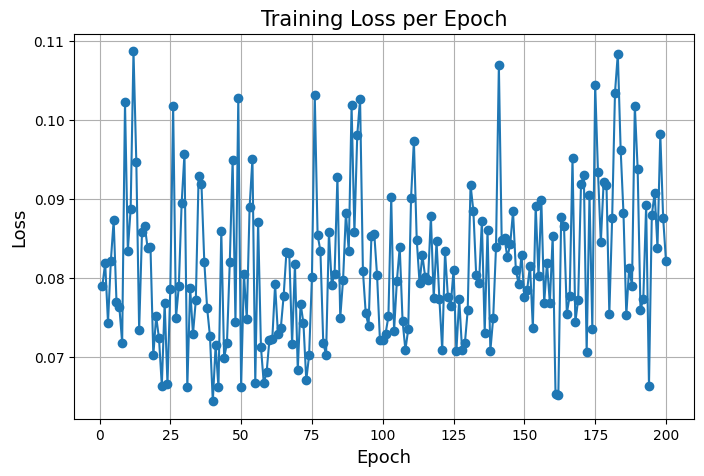

==================== TESTING ====================


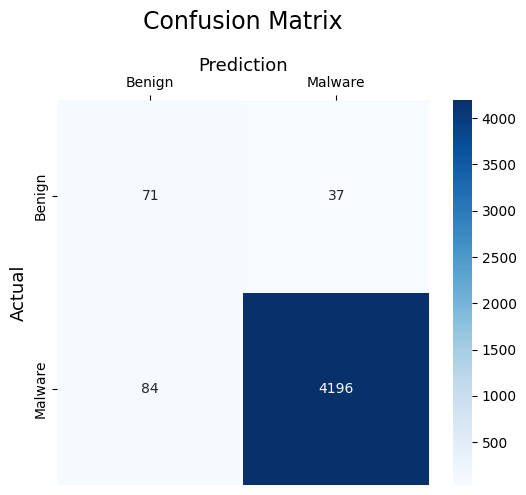


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9724 | F1-Score: 0.9858 | Loss: 0.0819 | Recall: 0.9804 | Precision: 0.9913 | TNR: 0.6574

===== RUNNING WITH EPOCH=200  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0345 | Val Acc: 0.9715 | Val F1: 0.9853 | Val Precision: 0.9919 | Val Recall: 0.9787 | Val TNR: 0.6852
Epoch 2 | Train Loss: 0.0323 | Val Acc: 0.9695 | Val F1: 0.9842 | Val Precision: 0.9922 | Val Recall: 0.9764 | Val TNR: 0.6944
Epoch 3 | Train Loss: 0.0327 | Val Acc: 0.9654 | Val F1: 0.9821 | Val Precision: 0.9926 | Val Recall: 0.9717 | Val TNR: 0.7130
Epoch 4 | Train Loss: 0.0338 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9908 | Val Recall: 0.9857 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0342 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9909 | Val Recall: 0.9881 | Val TNR: 0.6389
Epoch 6 | Train Loss: 0.0352 | Val Acc: 0.9736 | Val F1: 0.9864 | Val Precision: 0.9922 | Val Recall: 0.9806 | Val TNR: 0.6944
Epoch 7 | Train Loss: 0.0352 | Val Acc: 0.

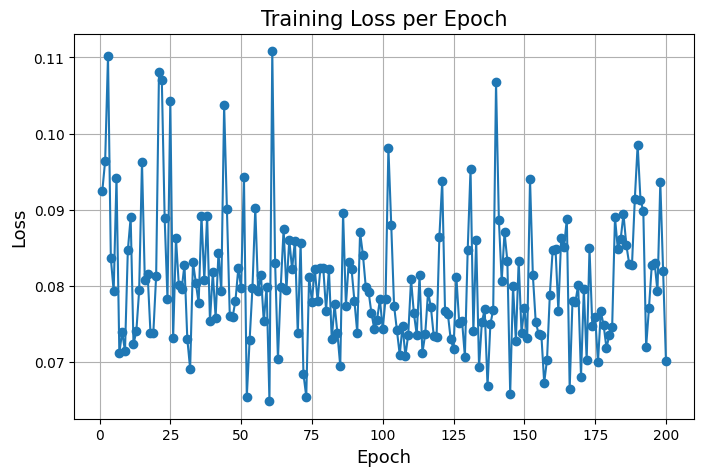

==================== TESTING ====================


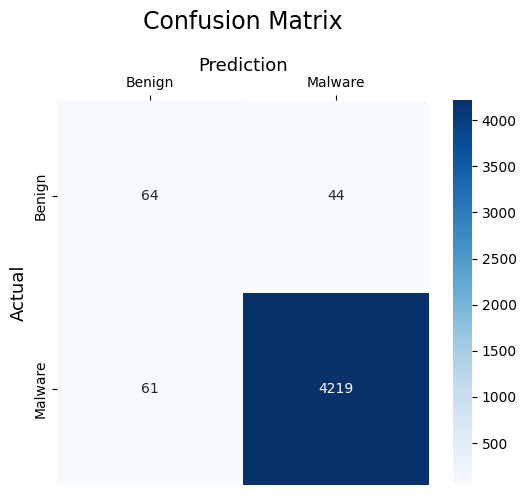


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9761 | F1-Score: 0.9877 | Loss: 0.0683 | Recall: 0.9857 | Precision: 0.9897 | TNR: 0.5926

===== RUNNING WITH EPOCH=200  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0336 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9915 | Val Recall: 0.9841 | Val TNR: 0.6667
Epoch 2 | Train Loss: 0.0333 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9913 | Val Recall: 0.9843 | Val TNR: 0.6574
Epoch 3 | Train Loss: 0.0347 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9902 | Val Recall: 0.9904 | Val TNR: 0.6111
Epoch 4 | Train Loss: 0.0336 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9904 | Val Recall: 0.9900 | Val TNR: 0.6204
Epoch 5 | Train Loss: 0.0343 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9911 | Val Recall: 0.9895 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0338 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9902 | Val Recall: 0.9907 | Val TNR: 0.6111
Epoch 7 | Train Loss: 0.0349 | Val Acc: 0.

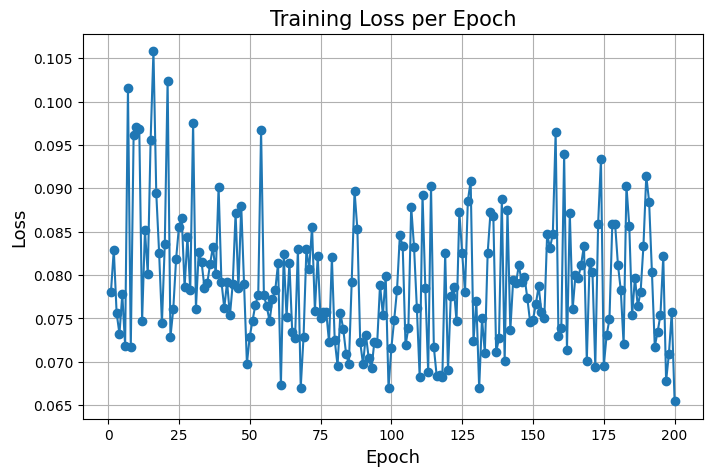

==================== TESTING ====================


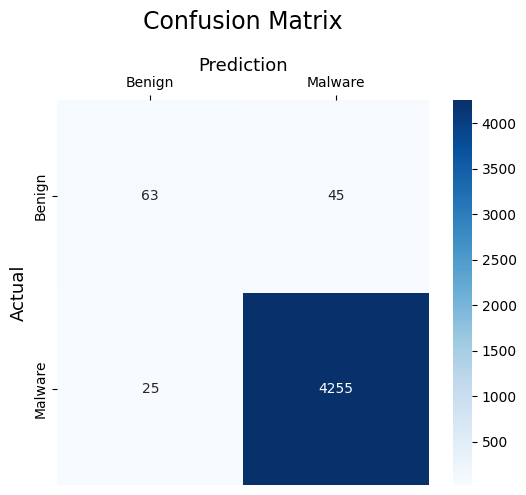


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9840 | F1-Score: 0.9918 | Loss: 0.0638 | Recall: 0.9942 | Precision: 0.9895 | TNR: 0.5833

===== RUNNING WITH EPOCH=200  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0342 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9904 | Val Recall: 0.9909 | Val TNR: 0.6204
Epoch 2 | Train Loss: 0.0333 | Val Acc: 0.9779 | Val F1: 0.9887 | Val Precision: 0.9902 | Val Recall: 0.9871 | Val TNR: 0.6111
Epoch 3 | Train Loss: 0.0339 | Val Acc: 0.9831 | Val F1: 0.9914 | Val Precision: 0.9904 | Val Recall: 0.9923 | Val TNR: 0.6204
Epoch 4 | Train Loss: 0.0341 | Val Acc: 0.9825 | Val F1: 0.9910 | Val Precision: 0.9902 | Val Recall: 0.9918 | Val TNR: 0.6111
Epoch 5 | Train Loss: 0.0322 | Val Acc: 0.9820 | Val F1: 0.9908 | Val Precision: 0.9891 | Val Recall: 0.9925 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0330 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9909 | Val Recall: 0.9904 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0332 | Val Acc: 0.

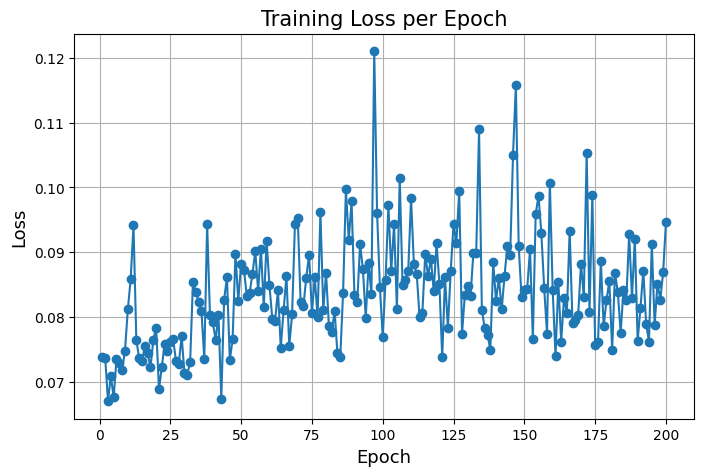

==================== TESTING ====================


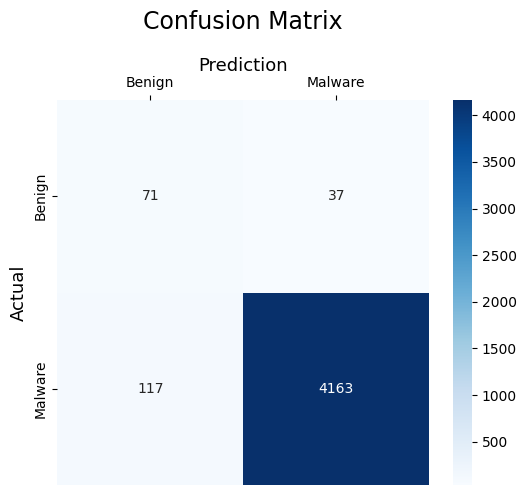


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9649 | F1-Score: 0.9818 | Loss: 0.0937 | Recall: 0.9727 | Precision: 0.9912 | TNR: 0.6574

===== RUNNING WITH EPOCH=225  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0375 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9906 | Val Recall: 0.9900 | Val TNR: 0.6296
Epoch 2 | Train Loss: 0.0351 | Val Acc: 0.9654 | Val F1: 0.9821 | Val Precision: 0.9928 | Val Recall: 0.9715 | Val TNR: 0.7222
Epoch 3 | Train Loss: 0.0339 | Val Acc: 0.9811 | Val F1: 0.9903 | Val Precision: 0.9884 | Val Recall: 0.9923 | Val TNR: 0.5370
Epoch 4 | Train Loss: 0.0360 | Val Acc: 0.9740 | Val F1: 0.9866 | Val Precision: 0.9910 | Val Recall: 0.9822 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0366 | Val Acc: 0.9768 | Val F1: 0.9881 | Val Precision: 0.9904 | Val Recall: 0.9857 | Val TNR: 0.6204
Epoch 6 | Train Loss: 0.0354 | Val Acc: 0.9745 | Val F1: 0.9869 | Val Precision: 0.9910 | Val Recall: 0.9827 | Val TNR: 0.6481
Epoch 7 | Train Loss: 0.0355 | Val Acc: 0.9

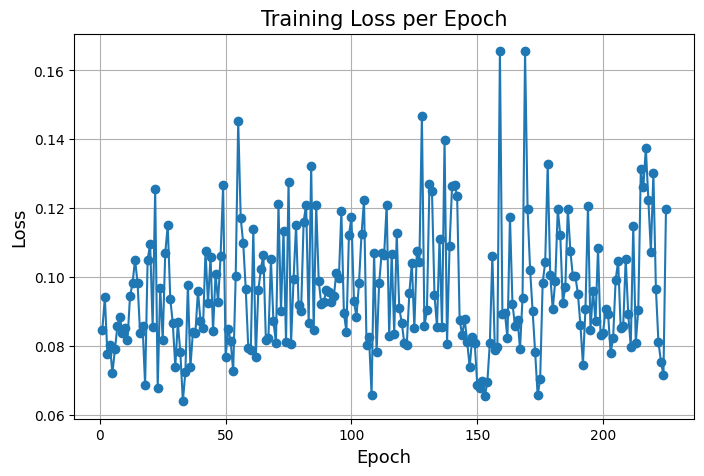

==================== TESTING ====================


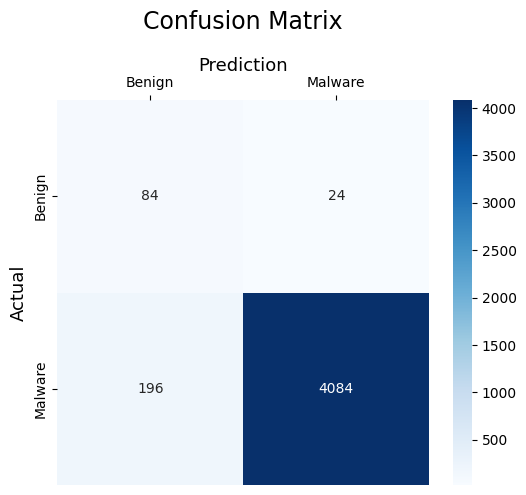


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9499 | F1-Score: 0.9738 | Loss: 0.1210 | Recall: 0.9542 | Precision: 0.9942 | TNR: 0.7778

===== RUNNING WITH EPOCH=225  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0353 | Val Acc: 0.9622 | Val F1: 0.9804 | Val Precision: 0.9933 | Val Recall: 0.9678 | Val TNR: 0.7407
Epoch 2 | Train Loss: 0.0348 | Val Acc: 0.9692 | Val F1: 0.9841 | Val Precision: 0.9922 | Val Recall: 0.9762 | Val TNR: 0.6944
Epoch 3 | Train Loss: 0.0349 | Val Acc: 0.9745 | Val F1: 0.9869 | Val Precision: 0.9908 | Val Recall: 0.9829 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0334 | Val Acc: 0.9658 | Val F1: 0.9823 | Val Precision: 0.9924 | Val Recall: 0.9724 | Val TNR: 0.7037
Epoch 5 | Train Loss: 0.0360 | Val Acc: 0.9594 | Val F1: 0.9789 | Val Precision: 0.9930 | Val Recall: 0.9652 | Val TNR: 0.7315
Epoch 6 | Train Loss: 0.0353 | Val Acc: 0.9569 | Val F1: 0.9776 | Val Precision: 0.9928 | Val Recall: 0.9629 | Val TNR: 0.7222
Epoch 7 | Train Loss: 0.0337 | Val Acc: 0.9

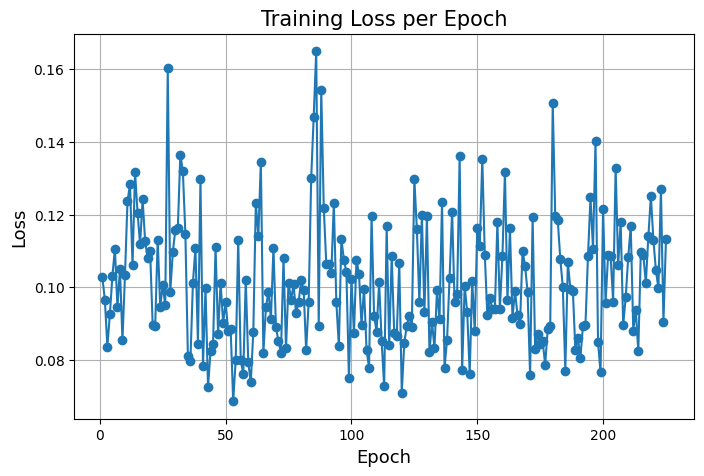

==================== TESTING ====================


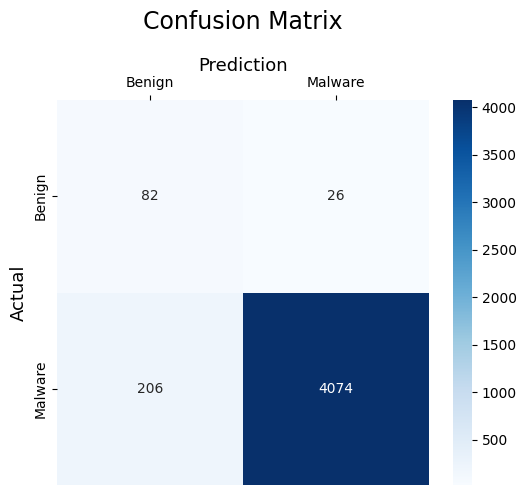


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9471 | F1-Score: 0.9723 | Loss: 0.1160 | Recall: 0.9519 | Precision: 0.9937 | TNR: 0.7593

===== RUNNING WITH EPOCH=225  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0366 | Val Acc: 0.9720 | Val F1: 0.9856 | Val Precision: 0.9910 | Val Recall: 0.9801 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0347 | Val Acc: 0.9777 | Val F1: 0.9885 | Val Precision: 0.9908 | Val Recall: 0.9862 | Val TNR: 0.6389
Epoch 3 | Train Loss: 0.0336 | Val Acc: 0.9676 | Val F1: 0.9833 | Val Precision: 0.9917 | Val Recall: 0.9750 | Val TNR: 0.6759
Epoch 4 | Train Loss: 0.0336 | Val Acc: 0.9692 | Val F1: 0.9841 | Val Precision: 0.9915 | Val Recall: 0.9769 | Val TNR: 0.6667
Epoch 5 | Train Loss: 0.0345 | Val Acc: 0.9724 | Val F1: 0.9858 | Val Precision: 0.9915 | Val Recall: 0.9801 | Val TNR: 0.6667
Epoch 6 | Train Loss: 0.0338 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9913 | Val Recall: 0.9864 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0351 | Val Acc: 0.

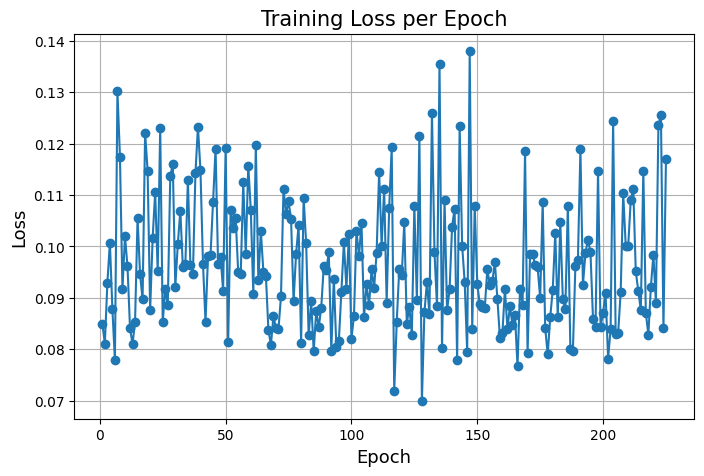

==================== TESTING ====================


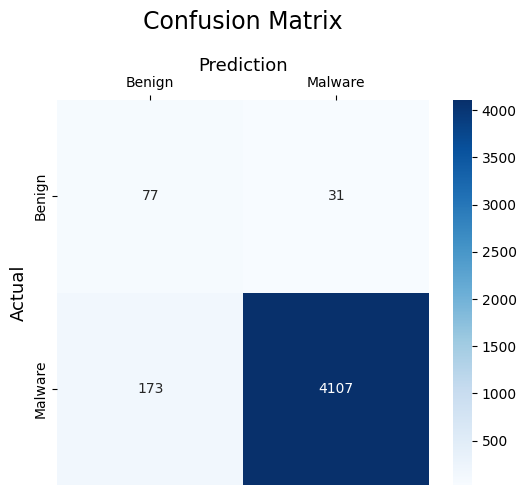


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9535 | F1-Score: 0.9758 | Loss: 0.1192 | Recall: 0.9596 | Precision: 0.9925 | TNR: 0.7130

===== RUNNING WITH EPOCH=225  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0334 | Val Acc: 0.9720 | Val F1: 0.9855 | Val Precision: 0.9913 | Val Recall: 0.9799 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0345 | Val Acc: 0.9706 | Val F1: 0.9848 | Val Precision: 0.9919 | Val Recall: 0.9778 | Val TNR: 0.6852
Epoch 3 | Train Loss: 0.0329 | Val Acc: 0.9617 | Val F1: 0.9801 | Val Precision: 0.9926 | Val Recall: 0.9680 | Val TNR: 0.7130
Epoch 4 | Train Loss: 0.0340 | Val Acc: 0.9701 | Val F1: 0.9846 | Val Precision: 0.9922 | Val Recall: 0.9771 | Val TNR: 0.6944
Epoch 5 | Train Loss: 0.0337 | Val Acc: 0.9603 | Val F1: 0.9794 | Val Precision: 0.9928 | Val Recall: 0.9664 | Val TNR: 0.7222
Epoch 6 | Train Loss: 0.0345 | Val Acc: 0.9619 | Val F1: 0.9803 | Val Precision: 0.9919 | Val Recall: 0.9689 | Val TNR: 0.6852
Epoch 7 | Train Loss: 0.0336 | Val Acc: 0.

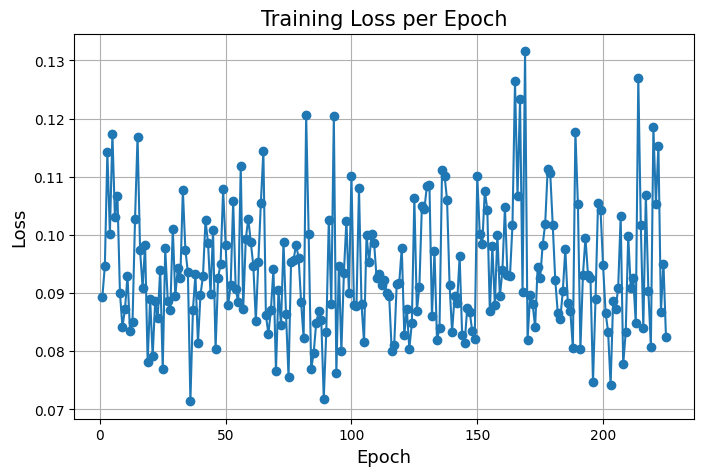

==================== TESTING ====================


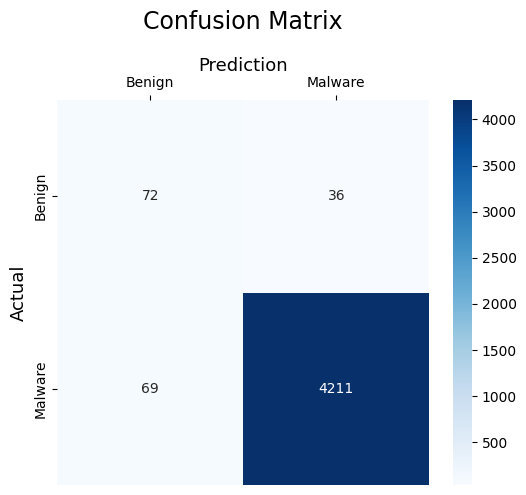


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9761 | F1-Score: 0.9877 | Loss: 0.0805 | Recall: 0.9839 | Precision: 0.9915 | TNR: 0.6667

===== RUNNING WITH EPOCH=225  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0328 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9911 | Val Recall: 0.9846 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0347 | Val Acc: 0.9752 | Val F1: 0.9872 | Val Precision: 0.9911 | Val Recall: 0.9834 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0345 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9908 | Val Recall: 0.9850 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0325 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9904 | Val Recall: 0.9855 | Val TNR: 0.6204
Epoch 5 | Train Loss: 0.0341 | Val Acc: 0.9747 | Val F1: 0.9870 | Val Precision: 0.9917 | Val Recall: 0.9822 | Val TNR: 0.6759
Epoch 6 | Train Loss: 0.0312 | Val Acc: 0.9692 | Val F1: 0.9841 | Val Precision: 0.9922 | Val Recall: 0.9762 | Val TNR: 0.6944
Epoch 7 | Train Loss: 0.0341 | Val Acc: 0.

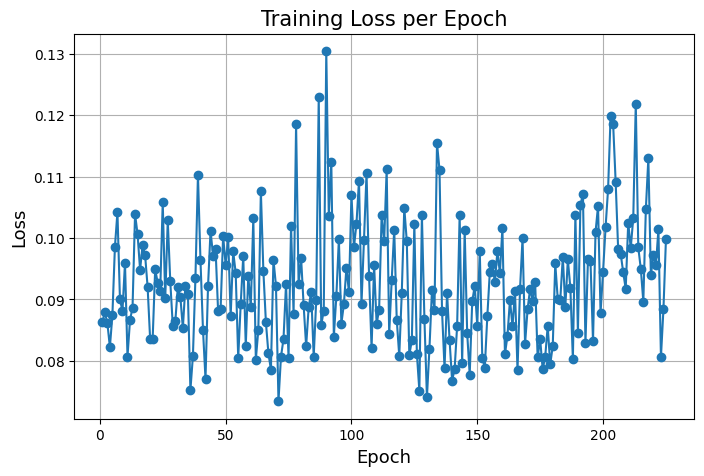

==================== TESTING ====================


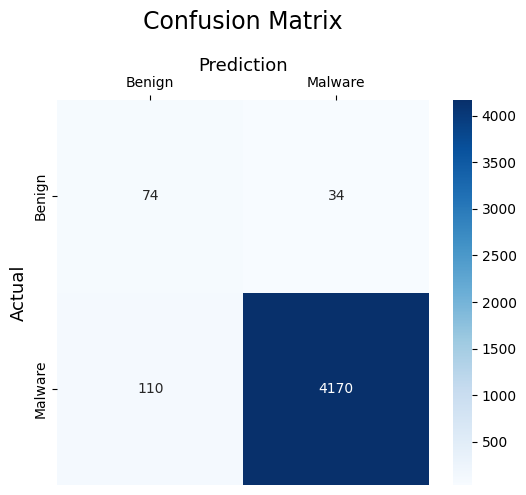


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9672 | F1-Score: 0.9830 | Loss: 0.0995 | Recall: 0.9743 | Precision: 0.9919 | TNR: 0.6852

===== RUNNING WITH EPOCH=225  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0321 | Val Acc: 0.9733 | Val F1: 0.9863 | Val Precision: 0.9913 | Val Recall: 0.9813 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0339 | Val Acc: 0.9638 | Val F1: 0.9812 | Val Precision: 0.9921 | Val Recall: 0.9706 | Val TNR: 0.6944
Epoch 3 | Train Loss: 0.0331 | Val Acc: 0.9711 | Val F1: 0.9851 | Val Precision: 0.9899 | Val Recall: 0.9804 | Val TNR: 0.6019
Epoch 4 | Train Loss: 0.0320 | Val Acc: 0.9695 | Val F1: 0.9842 | Val Precision: 0.9922 | Val Recall: 0.9764 | Val TNR: 0.6944
Epoch 5 | Train Loss: 0.0341 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9911 | Val Recall: 0.9843 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0335 | Val Acc: 0.9699 | Val F1: 0.9845 | Val Precision: 0.9915 | Val Recall: 0.9776 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0332 | Val Acc: 0.

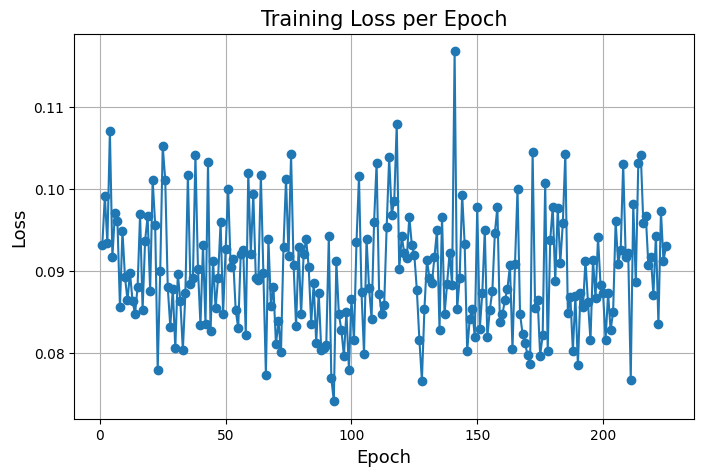

==================== TESTING ====================


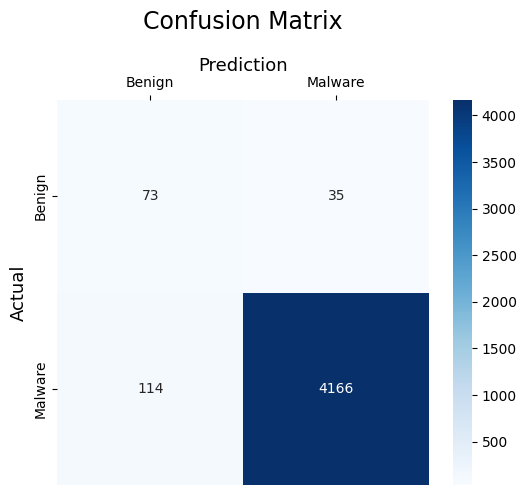


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9660 | F1-Score: 0.9824 | Loss: 0.0907 | Recall: 0.9734 | Precision: 0.9917 | TNR: 0.6759

===== RUNNING WITH EPOCH=250  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0359 | Val Acc: 0.9681 | Val F1: 0.9835 | Val Precision: 0.9912 | Val Recall: 0.9759 | Val TNR: 0.6574
Epoch 2 | Train Loss: 0.0351 | Val Acc: 0.9745 | Val F1: 0.9869 | Val Precision: 0.9890 | Val Recall: 0.9848 | Val TNR: 0.5648
Epoch 3 | Train Loss: 0.0366 | Val Acc: 0.9649 | Val F1: 0.9818 | Val Precision: 0.9907 | Val Recall: 0.9731 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0339 | Val Acc: 0.9688 | Val F1: 0.9839 | Val Precision: 0.9910 | Val Recall: 0.9769 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0345 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9901 | Val Recall: 0.9853 | Val TNR: 0.6111
Epoch 6 | Train Loss: 0.0355 | Val Acc: 0.9654 | Val F1: 0.9821 | Val Precision: 0.9914 | Val Recall: 0.9729 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0344 | Val Acc: 0.9

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 25 | Train Loss: 0.0343 | Val Acc: 0.9535 | Val F1: 0.9758 | Val Precision: 0.9927 | Val Recall: 0.9593 | Val TNR: 0.7222
Epoch 26 | Train Loss: 0.0347 | Val Acc: 0.9492 | Val F1: 0.9734 | Val Precision: 0.9934 | Val Recall: 0.9542 | Val TNR: 0.7500
Epoch 27 | Train Loss: 0.0365 | Val Acc: 0.9603 | Val F1: 0.9795 | Val Precision: 0.9902 | Val Recall: 0.9689 | Val TNR: 0.6204
Epoch 28 | Train Loss: 0.0347 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9897 | Val Recall: 0.9855 | Val TNR: 0.5926
Epoch 29 | Train Loss: 0.0342 | Val Acc: 0.9626 | Val F1: 0.9806 | Val Precision: 0.9914 | Val Recall: 0.9701 | Val TNR: 0.6667
Epoch 30 | Train Loss: 0.0334 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9886 | Val Recall: 0.9923 | Val TNR: 0.5463
Epoch 31 | Train Loss: 0.0329 | Val Acc: 0.9537 | Val F1: 0.9759 | Val Precision: 0.9932 | Val Recall: 0.9591 | Val TNR: 0.7407
Epoch 32 | Train Loss: 0.0338 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9906 | Val Recall: 0

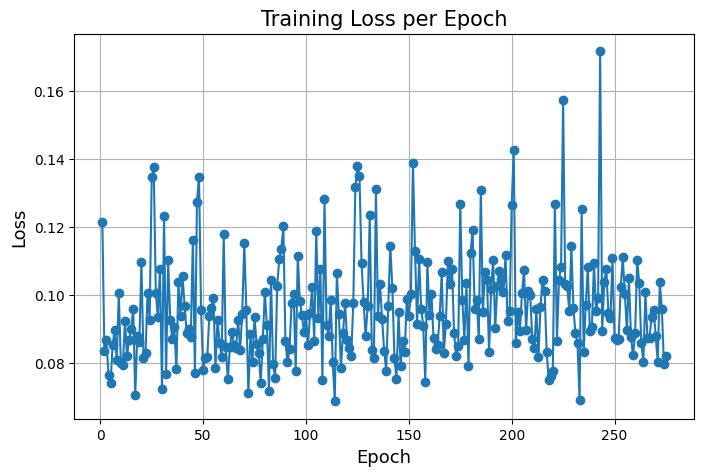

==================== TESTING ====================


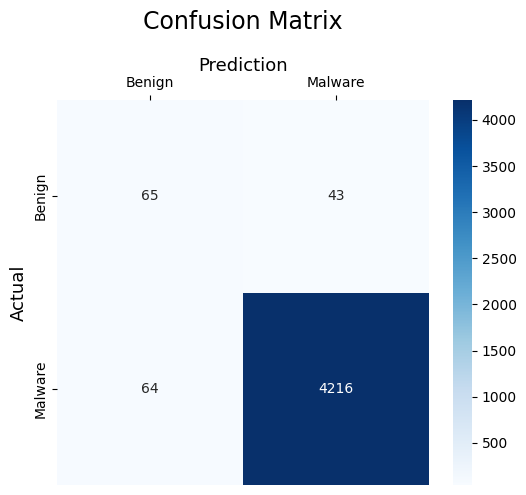


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9756 | F1-Score: 0.9875 | Loss: 0.0781 | Recall: 0.9850 | Precision: 0.9899 | TNR: 0.6019

===== RUNNING WITH EPOCH=275  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0355 | Val Acc: 0.9633 | Val F1: 0.9810 | Val Precision: 0.9914 | Val Recall: 0.9708 | Val TNR: 0.6667
Epoch 2 | Train Loss: 0.0328 | Val Acc: 0.9715 | Val F1: 0.9853 | Val Precision: 0.9915 | Val Recall: 0.9792 | Val TNR: 0.6667
Epoch 3 | Train Loss: 0.0345 | Val Acc: 0.9777 | Val F1: 0.9885 | Val Precision: 0.9908 | Val Recall: 0.9862 | Val TNR: 0.6389
Epoch 4 | Train Loss: 0.0337 | Val Acc: 0.9770 | Val F1: 0.9882 | Val Precision: 0.9908 | Val Recall: 0.9855 | Val TNR: 0.6389
Epoch 5 | Train Loss: 0.0333 | Val Acc: 0.9729 | Val F1: 0.9860 | Val Precision: 0.9913 | Val Recall: 0.9808 | Val TNR: 0.6574
Epoch 6 | Train Loss: 0.0341 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9915 | Val Recall: 0.9850 | Val TNR: 0.6667
Epoch 7 | Train Loss: 0.0322 | Val Acc: 0.9

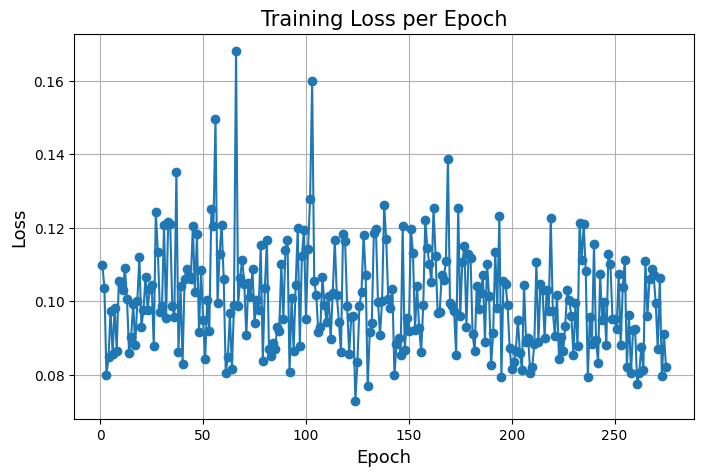

==================== TESTING ====================


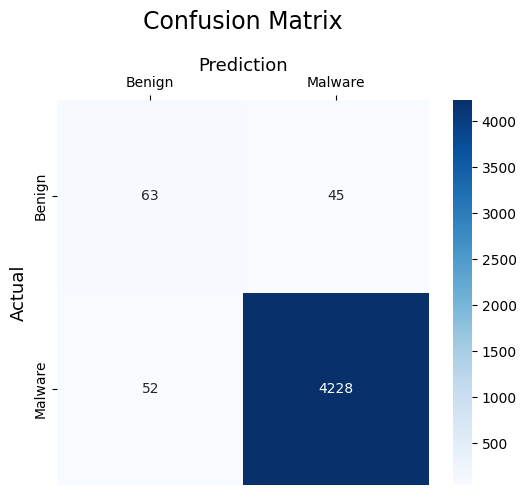


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9779 | F1-Score: 0.9887 | Loss: 0.0770 | Recall: 0.9879 | Precision: 0.9895 | TNR: 0.5833

===== RUNNING WITH EPOCH=275  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0323 | Val Acc: 0.9784 | Val F1: 0.9889 | Val Precision: 0.9911 | Val Recall: 0.9867 | Val TNR: 0.6481
Epoch 2 | Train Loss: 0.0320 | Val Acc: 0.9713 | Val F1: 0.9852 | Val Precision: 0.9917 | Val Recall: 0.9787 | Val TNR: 0.6759
Epoch 3 | Train Loss: 0.0341 | Val Acc: 0.9774 | Val F1: 0.9884 | Val Precision: 0.9911 | Val Recall: 0.9857 | Val TNR: 0.6481
Epoch 4 | Train Loss: 0.0330 | Val Acc: 0.9640 | Val F1: 0.9814 | Val Precision: 0.9917 | Val Recall: 0.9713 | Val TNR: 0.6759
Epoch 5 | Train Loss: 0.0345 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9911 | Val Recall: 0.9855 | Val TNR: 0.6481
Epoch 6 | Train Loss: 0.0327 | Val Acc: 0.9765 | Val F1: 0.9879 | Val Precision: 0.9908 | Val Recall: 0.9850 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0330 | Val Acc: 0.

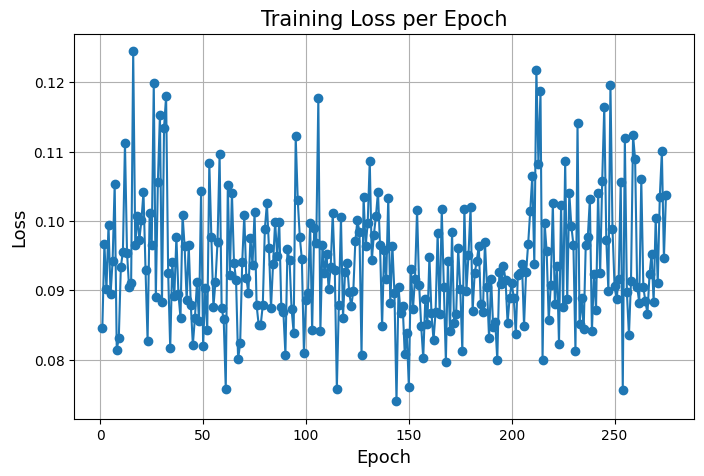

==================== TESTING ====================


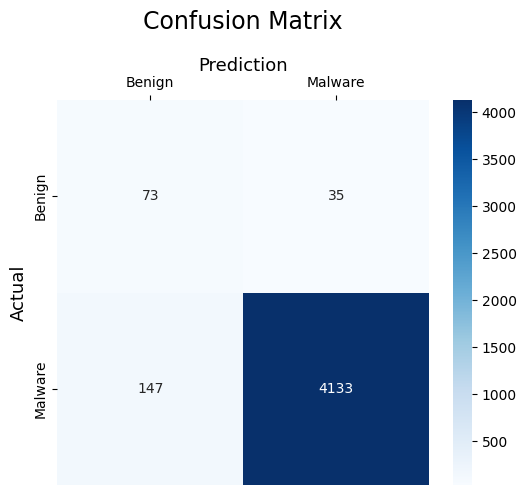


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9585 | F1-Score: 0.9785 | Loss: 0.1042 | Recall: 0.9657 | Precision: 0.9916 | TNR: 0.6759

===== RUNNING WITH EPOCH=275  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0329 | Val Acc: 0.9711 | Val F1: 0.9851 | Val Precision: 0.9917 | Val Recall: 0.9785 | Val TNR: 0.6759
Epoch 2 | Train Loss: 0.0337 | Val Acc: 0.9699 | Val F1: 0.9845 | Val Precision: 0.9922 | Val Recall: 0.9769 | Val TNR: 0.6944
Epoch 3 | Train Loss: 0.0334 | Val Acc: 0.9706 | Val F1: 0.9848 | Val Precision: 0.9919 | Val Recall: 0.9778 | Val TNR: 0.6852
Epoch 4 | Train Loss: 0.0321 | Val Acc: 0.9622 | Val F1: 0.9804 | Val Precision: 0.9919 | Val Recall: 0.9692 | Val TNR: 0.6852
Epoch 5 | Train Loss: 0.0328 | Val Acc: 0.9594 | Val F1: 0.9789 | Val Precision: 0.9921 | Val Recall: 0.9661 | Val TNR: 0.6944
Epoch 6 | Train Loss: 0.0324 | Val Acc: 0.9779 | Val F1: 0.9886 | Val Precision: 0.9913 | Val Recall: 0.9860 | Val TNR: 0.6574
Epoch 7 | Train Loss: 0.0328 | Val Acc: 0.

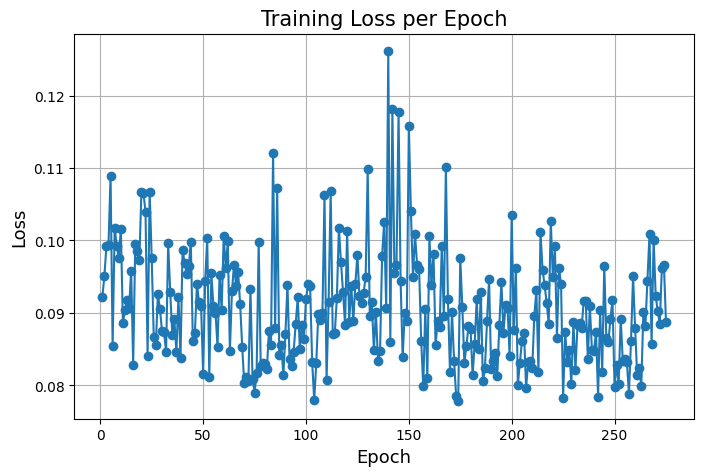

==================== TESTING ====================


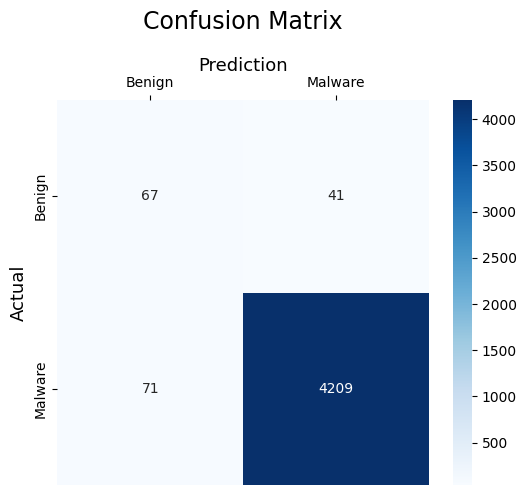


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9745 | F1-Score: 0.9869 | Loss: 0.0874 | Recall: 0.9834 | Precision: 0.9904 | TNR: 0.6204

===== RUNNING WITH EPOCH=275  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0326 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9899 | Val Recall: 0.9857 | Val TNR: 0.6019
Epoch 2 | Train Loss: 0.0332 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9888 | Val Recall: 0.9864 | Val TNR: 0.5556
Epoch 3 | Train Loss: 0.0308 | Val Acc: 0.9686 | Val F1: 0.9838 | Val Precision: 0.9912 | Val Recall: 0.9764 | Val TNR: 0.6574
Epoch 4 | Train Loss: 0.0326 | Val Acc: 0.9740 | Val F1: 0.9866 | Val Precision: 0.9897 | Val Recall: 0.9836 | Val TNR: 0.5926
Epoch 5 | Train Loss: 0.0321 | Val Acc: 0.9742 | Val F1: 0.9868 | Val Precision: 0.9890 | Val Recall: 0.9846 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0324 | Val Acc: 0.9715 | Val F1: 0.9853 | Val Precision: 0.9896 | Val Recall: 0.9811 | Val TNR: 0.5926
Epoch 7 | Train Loss: 0.0321 | Val Acc: 0.

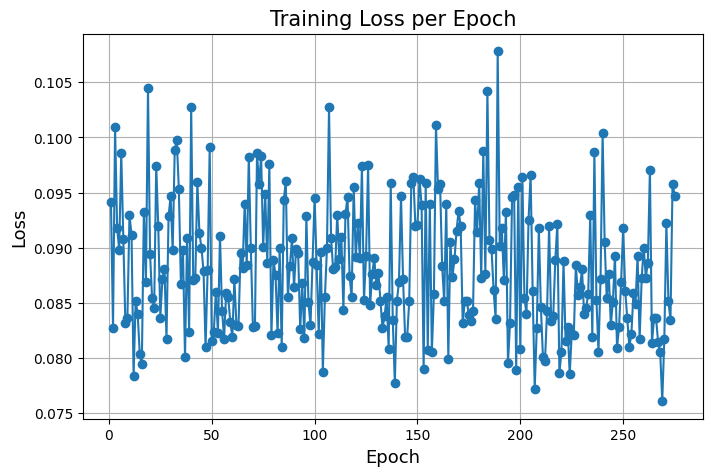

==================== TESTING ====================


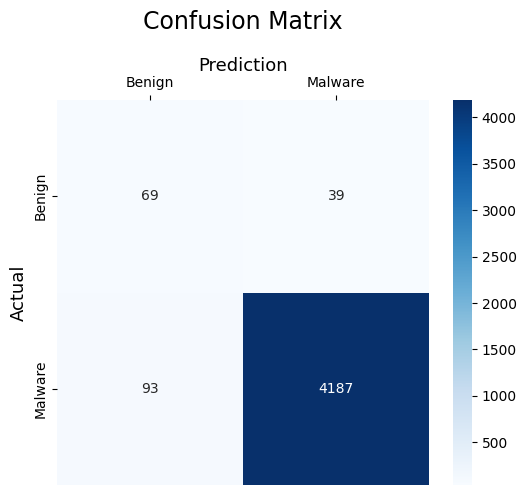


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9699 | F1-Score: 0.9845 | Loss: 0.0922 | Recall: 0.9783 | Precision: 0.9908 | TNR: 0.6389

===== RUNNING WITH EPOCH=275  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0309 | Val Acc: 0.9765 | Val F1: 0.9880 | Val Precision: 0.9885 | Val Recall: 0.9874 | Val TNR: 0.5463
Epoch 2 | Train Loss: 0.0311 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9890 | Val Recall: 0.9862 | Val TNR: 0.5648
Epoch 3 | Train Loss: 0.0299 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9892 | Val Recall: 0.9862 | Val TNR: 0.5741
Epoch 4 | Train Loss: 0.0315 | Val Acc: 0.9720 | Val F1: 0.9856 | Val Precision: 0.9896 | Val Recall: 0.9815 | Val TNR: 0.5926
Epoch 5 | Train Loss: 0.0314 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9890 | Val Recall: 0.9864 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0330 | Val Acc: 0.9706 | Val F1: 0.9849 | Val Precision: 0.9899 | Val Recall: 0.9799 | Val TNR: 0.6019
Epoch 7 | Train Loss: 0.0329 | Val Acc: 0.

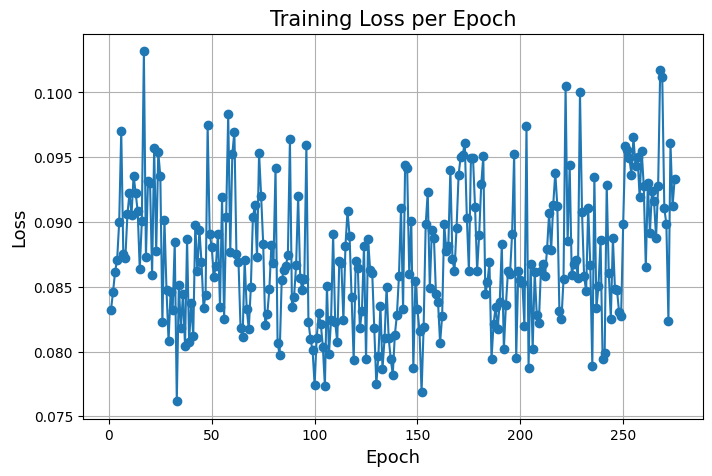

==================== TESTING ====================


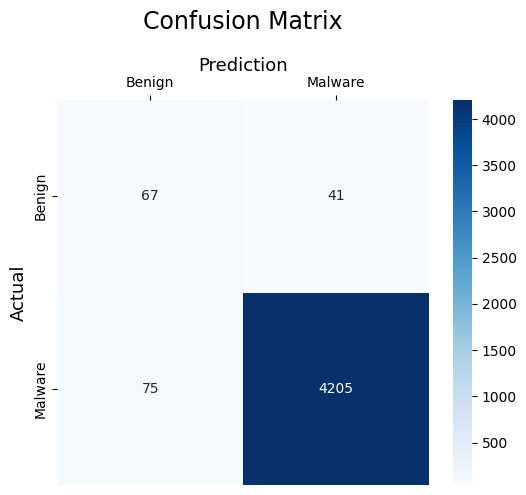


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9736 | F1-Score: 0.9864 | Loss: 0.0885 | Recall: 0.9825 | Precision: 0.9903 | TNR: 0.6204

===== RUNNING WITH EPOCH=300  |  BATCH=32 =====
Epoch 1 | Train Loss: 0.0348 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9892 | Val Recall: 0.9860 | Val TNR: 0.5741
Epoch 2 | Train Loss: 0.0356 | Val Acc: 0.9818 | Val F1: 0.9907 | Val Precision: 0.9884 | Val Recall: 0.9930 | Val TNR: 0.5370
Epoch 3 | Train Loss: 0.0348 | Val Acc: 0.9724 | Val F1: 0.9858 | Val Precision: 0.9892 | Val Recall: 0.9825 | Val TNR: 0.5741
Epoch 4 | Train Loss: 0.0338 | Val Acc: 0.9706 | Val F1: 0.9849 | Val Precision: 0.9894 | Val Recall: 0.9804 | Val TNR: 0.5833
Epoch 5 | Train Loss: 0.0335 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9895 | Val Recall: 0.9862 | Val TNR: 0.5833
Epoch 6 | Train Loss: 0.0361 | Val Acc: 0.9772 | Val F1: 0.9883 | Val Precision: 0.9885 | Val Recall: 0.9881 | Val TNR: 0.5463
Epoch 7 | Train Loss: 0.0319 | Val Acc: 0.9

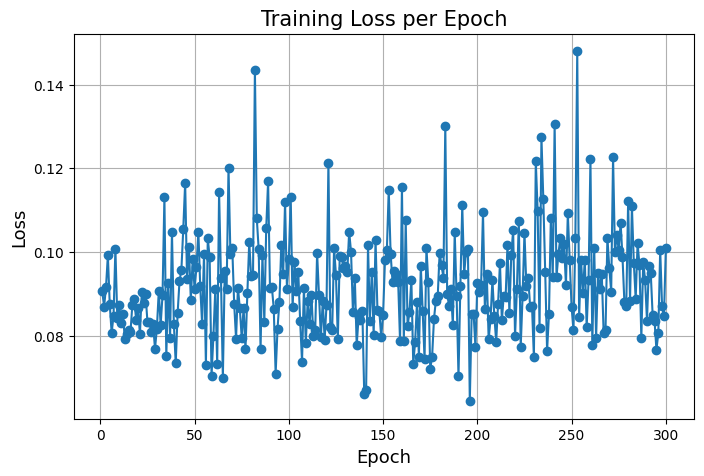

==================== TESTING ====================


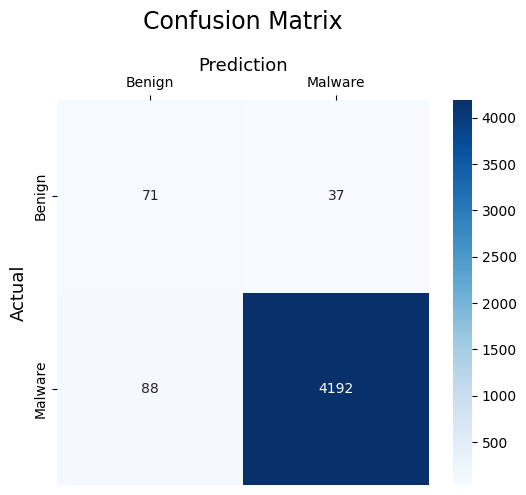


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9715 | F1-Score: 0.9853 | Loss: 0.0975 | Recall: 0.9794 | Precision: 0.9913 | TNR: 0.6574

===== RUNNING WITH EPOCH=300  |  BATCH=64 =====
Epoch 1 | Train Loss: 0.0326 | Val Acc: 0.9722 | Val F1: 0.9857 | Val Precision: 0.9908 | Val Recall: 0.9806 | Val TNR: 0.6389
Epoch 2 | Train Loss: 0.0325 | Val Acc: 0.9729 | Val F1: 0.9860 | Val Precision: 0.9899 | Val Recall: 0.9822 | Val TNR: 0.6019
Epoch 3 | Train Loss: 0.0335 | Val Acc: 0.9697 | Val F1: 0.9844 | Val Precision: 0.9896 | Val Recall: 0.9792 | Val TNR: 0.5926
Epoch 4 | Train Loss: 0.0333 | Val Acc: 0.9692 | Val F1: 0.9841 | Val Precision: 0.9910 | Val Recall: 0.9773 | Val TNR: 0.6481
Epoch 5 | Train Loss: 0.0319 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9901 | Val Recall: 0.9853 | Val TNR: 0.6111
Epoch 6 | Train Loss: 0.0332 | Val Acc: 0.9683 | Val F1: 0.9836 | Val Precision: 0.9908 | Val Recall: 0.9766 | Val TNR: 0.6389
Epoch 7 | Train Loss: 0.0324 | Val Acc: 0.9

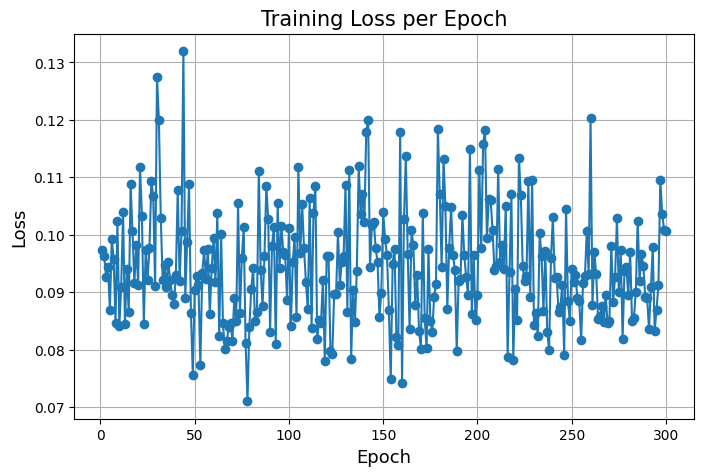

==================== TESTING ====================


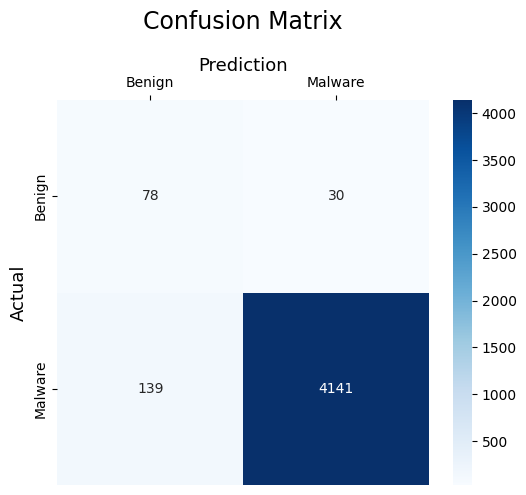


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9615 | F1-Score: 0.9800 | Loss: 0.0991 | Recall: 0.9675 | Precision: 0.9928 | TNR: 0.7222

===== RUNNING WITH EPOCH=300  |  BATCH=128 =====
Epoch 1 | Train Loss: 0.0333 | Val Acc: 0.9770 | Val F1: 0.9882 | Val Precision: 0.9906 | Val Recall: 0.9857 | Val TNR: 0.6296
Epoch 2 | Train Loss: 0.0311 | Val Acc: 0.9774 | Val F1: 0.9884 | Val Precision: 0.9911 | Val Recall: 0.9857 | Val TNR: 0.6481
Epoch 3 | Train Loss: 0.0337 | Val Acc: 0.9724 | Val F1: 0.9858 | Val Precision: 0.9913 | Val Recall: 0.9804 | Val TNR: 0.6574
Epoch 4 | Train Loss: 0.0317 | Val Acc: 0.9717 | Val F1: 0.9854 | Val Precision: 0.9913 | Val Recall: 0.9797 | Val TNR: 0.6574
Epoch 5 | Train Loss: 0.0315 | Val Acc: 0.9768 | Val F1: 0.9881 | Val Precision: 0.9885 | Val Recall: 0.9876 | Val TNR: 0.5463
Epoch 6 | Train Loss: 0.0335 | Val Acc: 0.9715 | Val F1: 0.9853 | Val Precision: 0.9896 | Val Recall: 0.9811 | Val TNR: 0.5926
Epoch 7 | Train Loss: 0.0326 | Val Acc: 0.

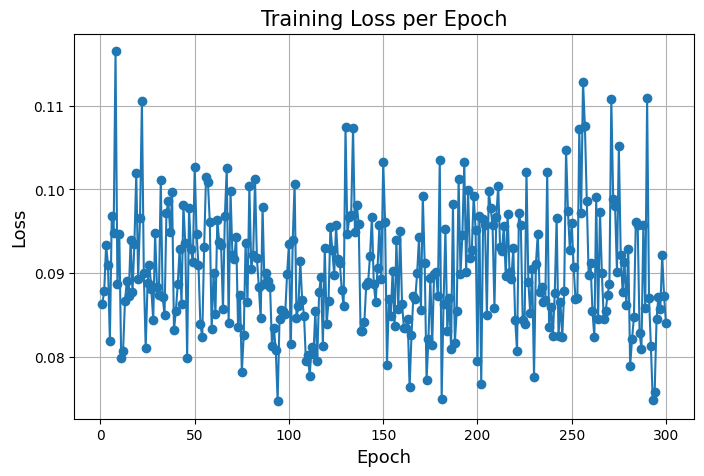

==================== TESTING ====================


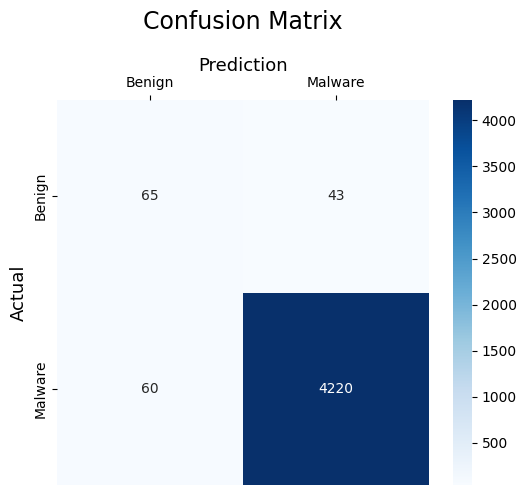


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9765 | F1-Score: 0.9879 | Loss: 0.0824 | Recall: 0.9860 | Precision: 0.9899 | TNR: 0.6019

===== RUNNING WITH EPOCH=300  |  BATCH=192 =====
Epoch 1 | Train Loss: 0.0324 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9890 | Val Recall: 0.9907 | Val TNR: 0.5648
Epoch 2 | Train Loss: 0.0322 | Val Acc: 0.9749 | Val F1: 0.9871 | Val Precision: 0.9899 | Val Recall: 0.9843 | Val TNR: 0.6019
Epoch 3 | Train Loss: 0.0310 | Val Acc: 0.9720 | Val F1: 0.9856 | Val Precision: 0.9899 | Val Recall: 0.9813 | Val TNR: 0.6019
Epoch 4 | Train Loss: 0.0329 | Val Acc: 0.9701 | Val F1: 0.9846 | Val Precision: 0.9896 | Val Recall: 0.9797 | Val TNR: 0.5926
Epoch 5 | Train Loss: 0.0325 | Val Acc: 0.9701 | Val F1: 0.9846 | Val Precision: 0.9898 | Val Recall: 0.9794 | Val TNR: 0.6019
Epoch 6 | Train Loss: 0.0303 | Val Acc: 0.9717 | Val F1: 0.9854 | Val Precision: 0.9910 | Val Recall: 0.9799 | Val TNR: 0.6481
Epoch 7 | Train Loss: 0.0322 | Val Acc: 0.

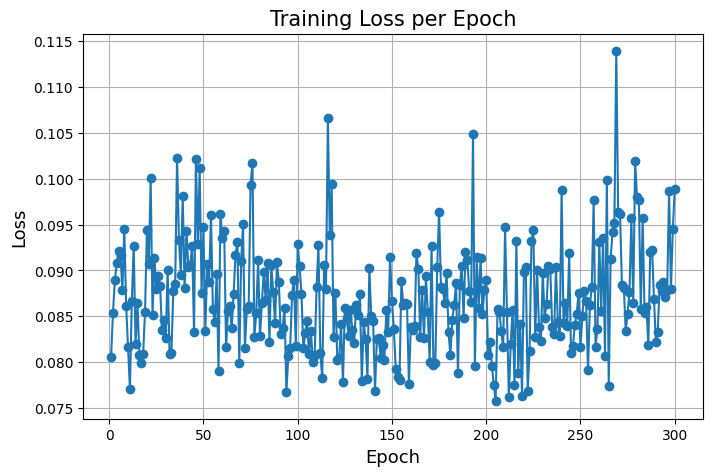

==================== TESTING ====================


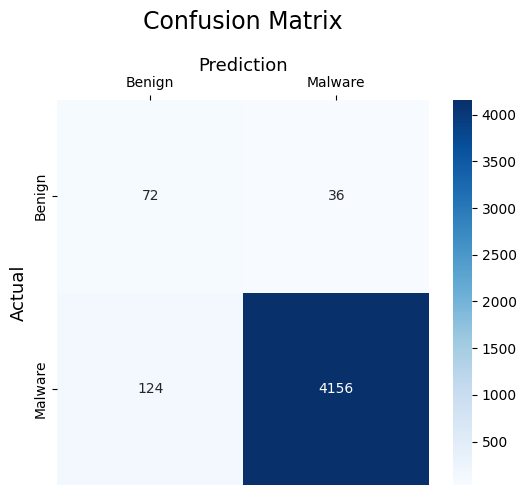


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9635 | F1-Score: 0.9811 | Loss: 0.0924 | Recall: 0.9710 | Precision: 0.9914 | TNR: 0.6667

===== RUNNING WITH EPOCH=300  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0305 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9888 | Val Recall: 0.9864 | Val TNR: 0.5556
Epoch 2 | Train Loss: 0.0317 | Val Acc: 0.9763 | Val F1: 0.9878 | Val Precision: 0.9888 | Val Recall: 0.9869 | Val TNR: 0.5556
Epoch 3 | Train Loss: 0.0322 | Val Acc: 0.9754 | Val F1: 0.9874 | Val Precision: 0.9888 | Val Recall: 0.9860 | Val TNR: 0.5556
Epoch 4 | Train Loss: 0.0329 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9890 | Val Recall: 0.9907 | Val TNR: 0.5648
Epoch 5 | Train Loss: 0.0324 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9881 | Val Recall: 0.9914 | Val TNR: 0.5278
Epoch 6 | Train Loss: 0.0321 | Val Acc: 0.9756 | Val F1: 0.9875 | Val Precision: 0.9885 | Val Recall: 0.9864 | Val TNR: 0.5463
Epoch 7 | Train Loss: 0.0314 | Val Acc: 0.

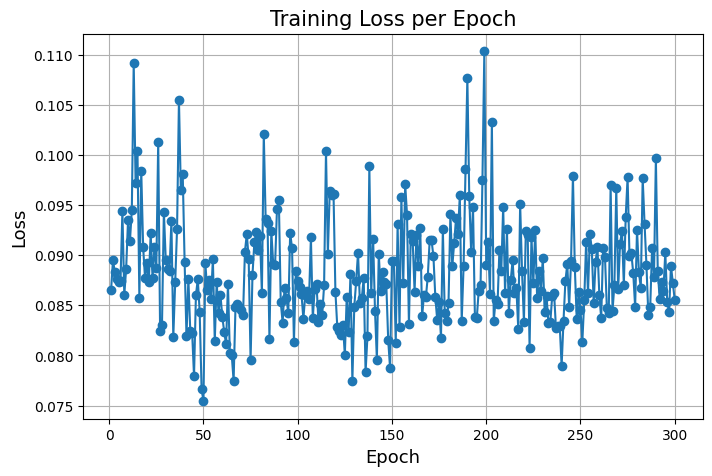

==================== TESTING ====================


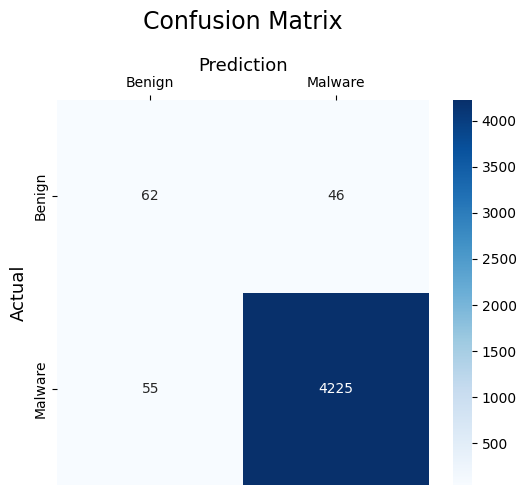


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9770 | F1-Score: 0.9882 | Loss: 0.0786 | Recall: 0.9871 | Precision: 0.9892 | TNR: 0.5741

===== RUNNING WITH EPOCH=300  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0314 | Val Acc: 0.9738 | Val F1: 0.9865 | Val Precision: 0.9892 | Val Recall: 0.9839 | Val TNR: 0.5741
Epoch 2 | Train Loss: 0.0295 | Val Acc: 0.9745 | Val F1: 0.9869 | Val Precision: 0.9890 | Val Recall: 0.9848 | Val TNR: 0.5648
Epoch 3 | Train Loss: 0.0313 | Val Acc: 0.9758 | Val F1: 0.9876 | Val Precision: 0.9892 | Val Recall: 0.9860 | Val TNR: 0.5741
Epoch 4 | Train Loss: 0.0313 | Val Acc: 0.9761 | Val F1: 0.9877 | Val Precision: 0.9892 | Val Recall: 0.9862 | Val TNR: 0.5741
Epoch 5 | Train Loss: 0.0319 | Val Acc: 0.9756 | Val F1: 0.9875 | Val Precision: 0.9890 | Val Recall: 0.9860 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0317 | Val Acc: 0.9697 | Val F1: 0.9844 | Val Precision: 0.9896 | Val Recall: 0.9792 | Val TNR: 0.5926
Epoch 7 | Train Loss: 0.0303 | Val Acc: 0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 241 | Train Loss: 0.0316 | Val Acc: 0.9806 | Val F1: 0.9901 | Val Precision: 0.9888 | Val Recall: 0.9914 | Val TNR: 0.5556
Epoch 242 | Train Loss: 0.0314 | Val Acc: 0.9790 | Val F1: 0.9893 | Val Precision: 0.9890 | Val Recall: 0.9895 | Val TNR: 0.5648
Epoch 243 | Train Loss: 0.0310 | Val Acc: 0.9809 | Val F1: 0.9902 | Val Precision: 0.9884 | Val Recall: 0.9921 | Val TNR: 0.5370
Epoch 244 | Train Loss: 0.0325 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9886 | Val Recall: 0.9911 | Val TNR: 0.5463
Epoch 245 | Train Loss: 0.0315 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9888 | Val Recall: 0.9902 | Val TNR: 0.5556
Epoch 246 | Train Loss: 0.0314 | Val Acc: 0.9777 | Val F1: 0.9885 | Val Precision: 0.9895 | Val Recall: 0.9876 | Val TNR: 0.5833
Epoch 247 | Train Loss: 0.0309 | Val Acc: 0.9729 | Val F1: 0.9860 | Val Precision: 0.9899 | Val Recall: 0.9822 | Val TNR: 0.6019
Epoch 248 | Train Loss: 0.0319 | Val Acc: 0.9660 | Val F1: 0.9824 | Val Precision: 0.9912 | Val R

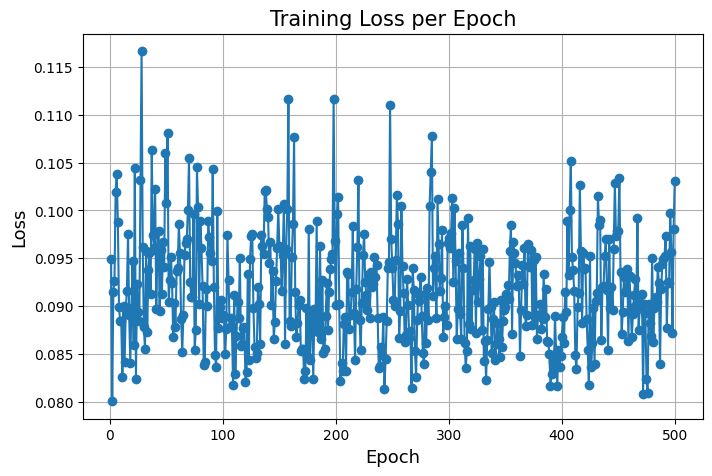

==================== TESTING ====================


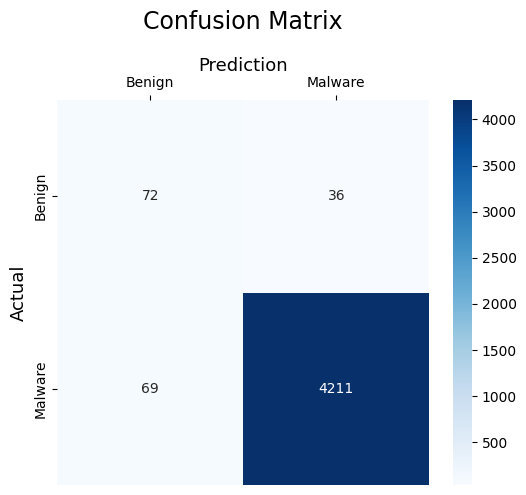


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9761 | F1-Score: 0.9877 | Loss: 0.0951 | Recall: 0.9839 | Precision: 0.9915 | TNR: 0.6667

===== RUNNING WITH EPOCH=500  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.0312 | Val Acc: 0.9793 | Val F1: 0.9894 | Val Precision: 0.9893 | Val Recall: 0.9895 | Val TNR: 0.5741
Epoch 2 | Train Loss: 0.0307 | Val Acc: 0.9795 | Val F1: 0.9895 | Val Precision: 0.9893 | Val Recall: 0.9897 | Val TNR: 0.5741
Epoch 3 | Train Loss: 0.0310 | Val Acc: 0.9797 | Val F1: 0.9896 | Val Precision: 0.9888 | Val Recall: 0.9904 | Val TNR: 0.5556
Epoch 4 | Train Loss: 0.0323 | Val Acc: 0.9754 | Val F1: 0.9874 | Val Precision: 0.9892 | Val Recall: 0.9855 | Val TNR: 0.5741
Epoch 5 | Train Loss: 0.0314 | Val Acc: 0.9813 | Val F1: 0.9904 | Val Precision: 0.9888 | Val Recall: 0.9921 | Val TNR: 0.5556
Epoch 6 | Train Loss: 0.0309 | Val Acc: 0.9742 | Val F1: 0.9868 | Val Precision: 0.9892 | Val Recall: 0.9843 | Val TNR: 0.5741
Epoch 7 | Train Loss: 0.0314 | Val Acc: 0.

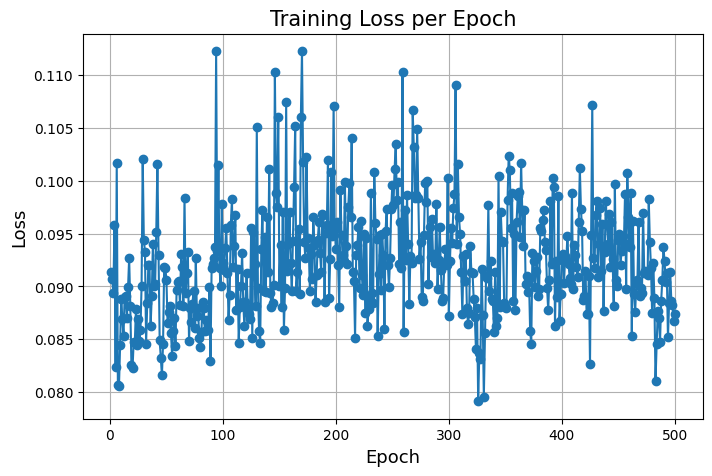

==================== TESTING ====================


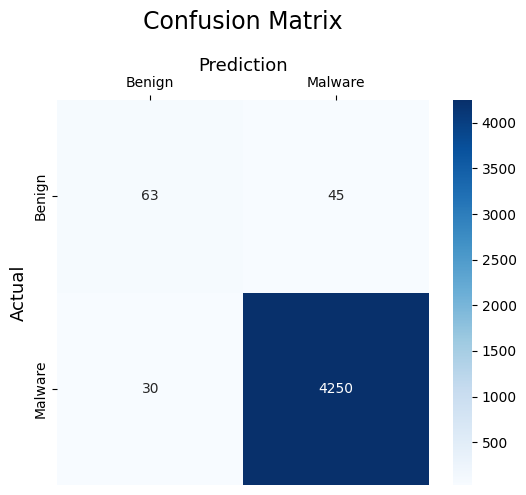


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9829 | F1-Score: 0.9913 | Loss: 0.0776 | Recall: 0.9930 | Precision: 0.9895 | TNR: 0.5833

===== RUNNING WITH EPOCH=500  |  BATCH=512 =====
Epoch 1 | Train Loss: 0.0312 | Val Acc: 0.9799 | Val F1: 0.9897 | Val Precision: 0.9890 | Val Recall: 0.9904 | Val TNR: 0.5648
Epoch 2 | Train Loss: 0.0314 | Val Acc: 0.9790 | Val F1: 0.9893 | Val Precision: 0.9890 | Val Recall: 0.9895 | Val TNR: 0.5648
Epoch 3 | Train Loss: 0.0299 | Val Acc: 0.9786 | Val F1: 0.9890 | Val Precision: 0.9890 | Val Recall: 0.9890 | Val TNR: 0.5648
Epoch 4 | Train Loss: 0.0316 | Val Acc: 0.9779 | Val F1: 0.9887 | Val Precision: 0.9890 | Val Recall: 0.9883 | Val TNR: 0.5648
Epoch 5 | Train Loss: 0.0309 | Val Acc: 0.9788 | Val F1: 0.9891 | Val Precision: 0.9890 | Val Recall: 0.9893 | Val TNR: 0.5648
Epoch 6 | Train Loss: 0.0307 | Val Acc: 0.9802 | Val F1: 0.9898 | Val Precision: 0.9890 | Val Recall: 0.9907 | Val TNR: 0.5648
Epoch 7 | Train Loss: 0.0306 | Val Acc: 0.

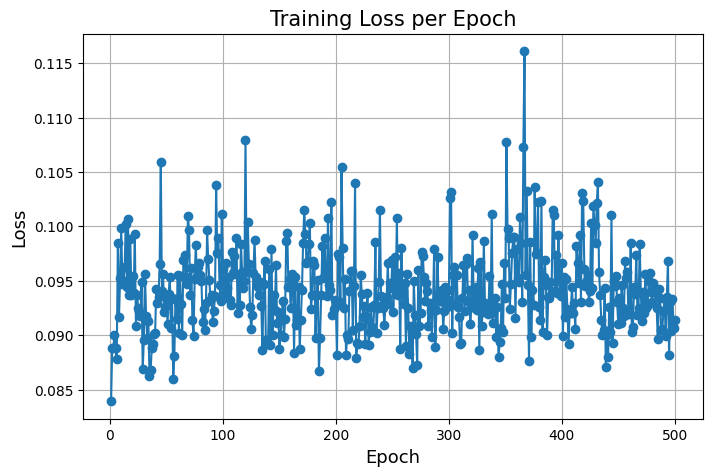

==================== TESTING ====================


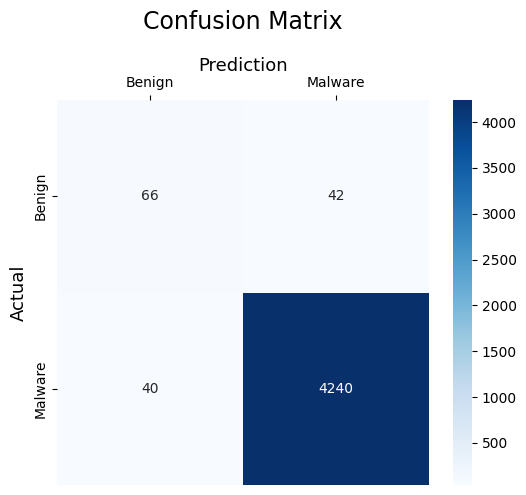


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9813 | F1-Score: 0.9904 | Loss: 0.0814 | Recall: 0.9907 | Precision: 0.9902 | TNR: 0.6111


In [7]:
# if __name__ == "__main__":
print("==================== TRAINING ====================")
model, test_loader, criterion = main_train_test_gat()

In [8]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(EPOCHS_LOSS)+1), EPOCHS_LOSS, marker='o', linestyle='-')
# plt.title("Training Loss per Epoch", fontsize=15)
# plt.xlabel("Epoch", fontsize=13)
# plt.ylabel("Loss", fontsize=13)
# plt.grid(True)
# plt.show()

# chart_path = f"{SAVE_FOLDER}/Loss_E{epoch}_B{batch}.png"
# plt.savefig(chart_path, dpi=300)    
# plt.close()

In [9]:
# print("==================== TESTING ====================")
# test_loss, test_acc, test_f1, test_precision, test_recall, test_TNR, cumulative_testing_time = evaluate_model(model, test_loader, DEVICE, criterion, val_test="Test", training_time=0, cumulative_testing_time=0)
# print("\n=======================================================")
# print(f"✅ FINAL TEST PERFORMANCE (GAT Classifier):")
# print(f"Accuracy: {test_acc:.4f} | F1-Score: {test_f1:.4f} | Loss: {test_loss:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f} | TNR: {test_TNR:.4f}")
# print("=======================================================")